In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from praatio import tgio
import os
import matplotlib.pyplot as plot

from scipy.io import wavfile


import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps

import os

from Signal_Analysis.features import signal


from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier


import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

import librosa
import librosa.display

import math
from python_speech_features import mfcc, logfbank



def print_stats(duration_mp):

    duration_ls = [(y, x) for (x, y) in duration_mp.items()]

    duration_ls.sort()

    duration_ls.reverse()

    for labelStat in duration_ls:
        print("Label " + labelStat[1] + " ; Total duration: " + str(round(labelStat[0], 2)) + " seconds")
        
        
        
        
        
##VAD using short term energy

def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, stride_length),
                                           strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
 
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length


def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2


def naive_frame_energy_vad(sig, fs, threshold=-20, win_len=0.25, win_hop=0.25, E0=1e7):
    # framing
    frames, frames_len = framing(sig=sig, fs=fs, win_len=win_len, win_hop=win_hop)

    # compute short time energies to get voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    orig_energy = energy
    log_energy = 10 * np.log10(energy / E0)

    # normalize energy to 0 dB then filter and format
    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)

    # compute vad and get speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return orig_energy, energy, vad, np.array(vframes, dtype=np.float64)


def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # first fig
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()

    # second fig
    sig, vad = data[0], data[-2]
    # plot VAD and orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()



def extract_features(soundData, samplingFrequency):

    soundData = np.array(soundData, dtype="float")
       #--------Energy----------------
    energy = librosa.feature.rms(y=soundData)
    
        #------melspectogram----------
#     mel_spectrum = librosa.feature.melspectrogram(y=soundData, sr=samplingFrequency, center=False, 
#                                                   n_mels=40,hop_length=hopLength)
        #-------MFCC------------------
#     mfcc= librosa.feature.mfcc(y=soundData,sr=samplingFrequency, n_mfcc=13, hop_length=hopLength)
        #--------Spec Centroid---------
    spec_centr = librosa.feature.spectral_centroid(y=soundData)
        #--------Spec_bandwidth--------
    spec_bandwidth = librosa.feature.spectral_bandwidth(y = soundData)
        #--------Spec_contrast---------
    spec_contrast = librosa.feature.spectral_contrast(y = soundData)
        #------Spec Rolloff--------------
    spec_rolloff = librosa.feature.spectral_rolloff(y=soundData, roll_percent=0.80)
        #------Tonal Centroid------------
    #tonal_centroid = librosa.feature.tonnetz(y=t['data'], sr=t['FS'])
        #------ZCR---------------------
    zcr = librosa.zero_crossings(y=soundData)
    zcr = (np.nonzero(zcr)[0].shape[0])
    print ("zcr", zcr)
    
    ##Other Features
    
    fourier_transform = np.fft.rfft(soundData)
    
    print(soundData)

    abs_fourier_transform = np.abs(fourier_transform)

    power_spectrum = np.square(abs_fourier_transform)
    
#     print(fourier_transform)

    frequency = np.linspace(0, samplingFrequency/2, len(power_spectrum))
    
    ##Calculate the features for cough
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        
        if frequency[i]>0 and frequency[i]<=8000:
            low_sp += power_spectrum[i]
        elif frequency[i]>8000:
            high_sp += power_spectrum[i]

    mean_power = sum(power_spectrum)/len(power_spectrum) 
    power_below16 = low_sp
    power_above16 = high_sp
#     print(power_spectrum)
    
    ##Speech features
    ##Calculate the ratio of (base + first harmonic energy) to total energy
    max_power = max(power_spectrum)
    print(max_power)
    print(np.argmax(power_spectrum))
    base_frequency = frequency[np.argmax(power_spectrum)]
    print (f"Maximum power is {max_power} at frequency {base_frequency}")
    first_harmonic_frequency = 2*base_frequency

    if first_harmonic_frequency not in frequency.tolist():
        first_harmonic_frequency = min(frequency.tolist(),key=lambda x:abs(x-first_harmonic_frequency))
          
    power_at_harmonic = power_spectrum[frequency.tolist().index(first_harmonic_frequency)]
    print (f"Power at first harmonic is {power_at_harmonic} at frequency {first_harmonic_frequency}")
    power_ratio = (max_power+power_at_harmonic)/sum(power_spectrum)
    
    ##VAD
    
    STenergy, energy2, vad, voiced = naive_frame_energy_vad(soundData, samplingFrequency, threshold=-35,
                                                     win_len=1, win_hop=1)
    
    
    ##Mask features
    ##energy ratio between 0–1 and 1–8 kHz (LH1000)
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        if frequency[i]>0 and frequency[i]<=1000:
            low_sp += power_spectrum[i]
        elif frequency[i]>1000 and frequency[i]<=25000:
            high_sp += power_spectrum[i]
            
    print ("Energy in 0 Hz - 1 kHz", low_sp)
    print ("Energy in 1 kHz - 8 kHz", high_sp)
    print ("energy ratio between 0–1 and 1–8 kHz (LH1000)", low_sp/high_sp)
    LH_ratio = low_sp/high_sp
    
    ## HNR
    
    HNR = signal.get_HNR( soundData, samplingFrequency )
    
    fb_feat = logfbank(soundData, samplingFrequency, nfilt=12)
#     fb_feat = fb_feat.T
    avg_fb = np.average(fb_feat, axis=0)
    print(fb_feat.shape, fb_feat[0].shape, avg_fb.shape)
    fb1 = fb_feat[0]
    print("Filter bank: ", fb_feat.shape)
#     plt.matshow(fb_feat)
    fb_beat_1 = fb_feat.flatten()
## index - feature
#     0 - energy      
#     1 - mel_spectrum (40, 12)
#     2 - mfcc (13, 16)
#     3 - spec_centr (1, 12)
#     4 - spec_bandwidth (1, 12)
#     5 - spec_contrast (7, 12)
#     6 - spec_rolloff (1, 12)
#     7 - zcr 
#     8 - mean_power  
#     9 - power_below16
#     10 - power_above16
#     11 - base_frequency
#     12 - power_ratio
#     13 - STenergy
#     14 - LH_ratio
#     15 - HNR
    features_all = [energy, spec_centr, spec_bandwidth, spec_contrast, spec_rolloff, zcr, mean_power,power_below16,power_above16, base_frequency, power_ratio, STenergy, LH_ratio, HNR]
#     print("Shape of all features")
#     for i in features_all:
#         i = np.array(i)
#         print(i.shape)
        
    features = [np.average(energy), np.average(spec_centr), np.average(spec_bandwidth),  np.average(spec_rolloff), zcr, mean_power, power_below16, power_above16, base_frequency, power_ratio, np.average(STenergy), LH_ratio, HNR] 

    for i in fb1:
        features.append(i)
    
    selected_features = []
#     for index in indices:
#         selected_features.append(features[index])

    non_privacy_features = abs_fourier_transform
    
    
    return features,selected_features,non_privacy_features

In [3]:
var = pd.read_csv('AIM_exp1_editted.csv')
var = var[25:]
var.head()

,Sample #,Start Date,Start Time,Sample Length,Averaging Interval (s),Title,Instrument ID,Instrument Errors,Conc Mean,Conc Min,Conc Max,Conc Std Dev
25,26,06/06/22,14:17:14,10,1,NaN,3775 71025228 2.16,None,0.8859,0.000,1.969,0.624020
26,27,06/06/22,14:17:25,10,1,NaN,3775 71025228 2.16,None,0.2364,0.000,0.788,0.229740
27,28,06/06/22,14:17:36,10,1,NaN,3775 71025228 2.16,None,0.1969,0.000,0.394,0.152467
28,29,06/06/22,14:17:47,10,1,NaN,3775 71025228 2.16,None,0.0197,0.000,0.197,0.059100
29,30,06/06/22,14:17:58,10,1,NaN,3775 71025228 2.16,None,0.5513,0.394,0.984,0.211748


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_15885/61590351.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=10, axis='x')


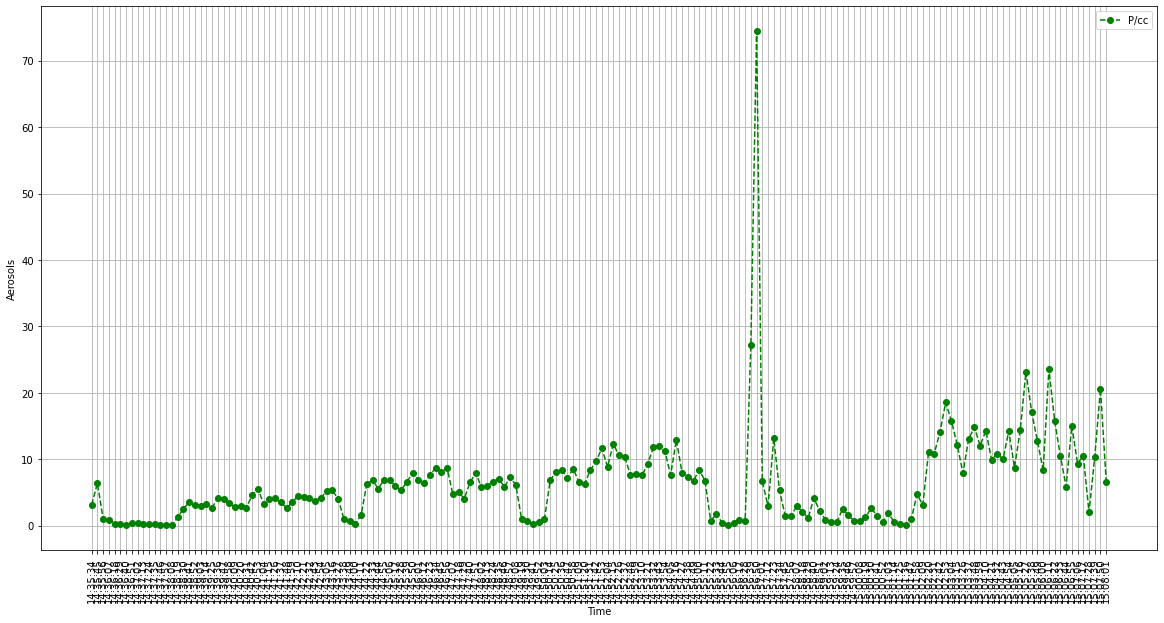

In [4]:
x = var['Start Time'][100:]
y = var['Conc Mean'][100:]

plt.figure(figsize=(20,10))
plt.plot(x, y , color = 'g', linestyle = 'dashed',
         marker = 'o',label = "P/cc")


plt.locator_params(nbins=10, axis='x')
plt.xticks(rotation = 90)
plt.xlabel('Time')
plt.ylabel('Aerosols')

plt.grid()
plt.legend()
plt.show()

In [5]:
y

125     3.16720
126     6.39260
127     1.04290
128     0.88570
129     0.23640
         ...   
298    10.52350
299     2.00630
300    10.38770
301    20.62260
302     6.59125
Name: Conc Mean, Length: 178, dtype: float64

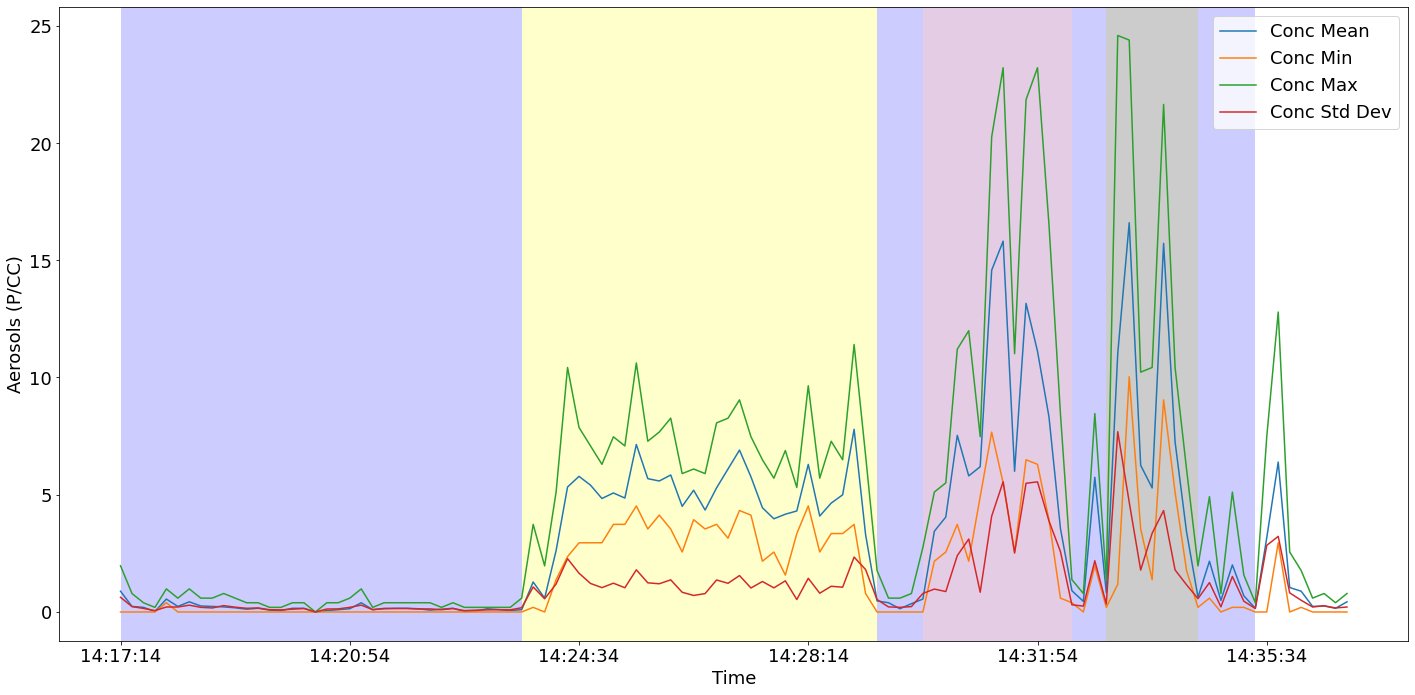

In [6]:

df = var[:108]
df_type = df
df = df.drop('Sample #', 1)
df = df.drop('Sample Length', 1)
df = df.drop('Averaging Interval (s)', 1)
df = df.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 35 , color='blue', alpha=0.2, lw=0)
plt.axvspan(35, 66 , color='yellow', alpha=0.2, lw=0)
plt.axvspan(66, 70 , color='blue', alpha=0.2, lw=0)
plt.axvspan(70, 83 , color='purple', alpha=0.2, lw=0)
plt.axvspan(83, 86 , color='blue', alpha=0.2, lw=0)
plt.axvspan(86, 94 , color='black', alpha=0.2, lw=0)
plt.axvspan(94, 99 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_type.jpg')

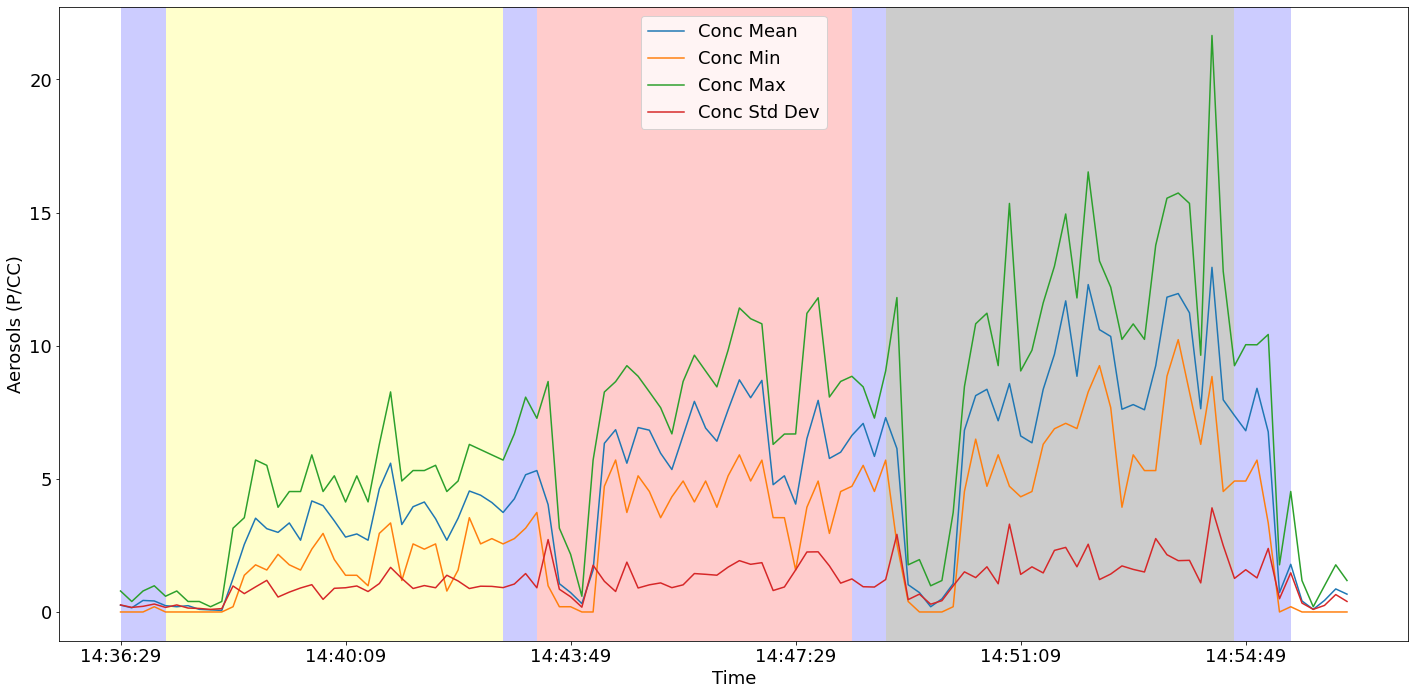

In [7]:


df2 = var[105:215]
df_level = df2
df2 = df2.drop('Sample #', 1)
df2 = df2.drop('Sample Length', 1)
df2 = df2.drop('Averaging Interval (s)', 1)
df2 = df2.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df2.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 4 , color='blue', alpha=0.2, lw=0)
plt.axvspan(4, 34 , color='yellow', alpha=0.2, lw=0)
plt.axvspan(34, 37 , color='blue', alpha=0.2, lw=0)
plt.axvspan(37, 65 , color='red', alpha=0.2, lw=0)
plt.axvspan(65, 68 , color='blue', alpha=0.2, lw=0)
plt.axvspan(68, 99 , color='black', alpha=0.2, lw=0)
plt.axvspan(99, 104 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_level.jpg')

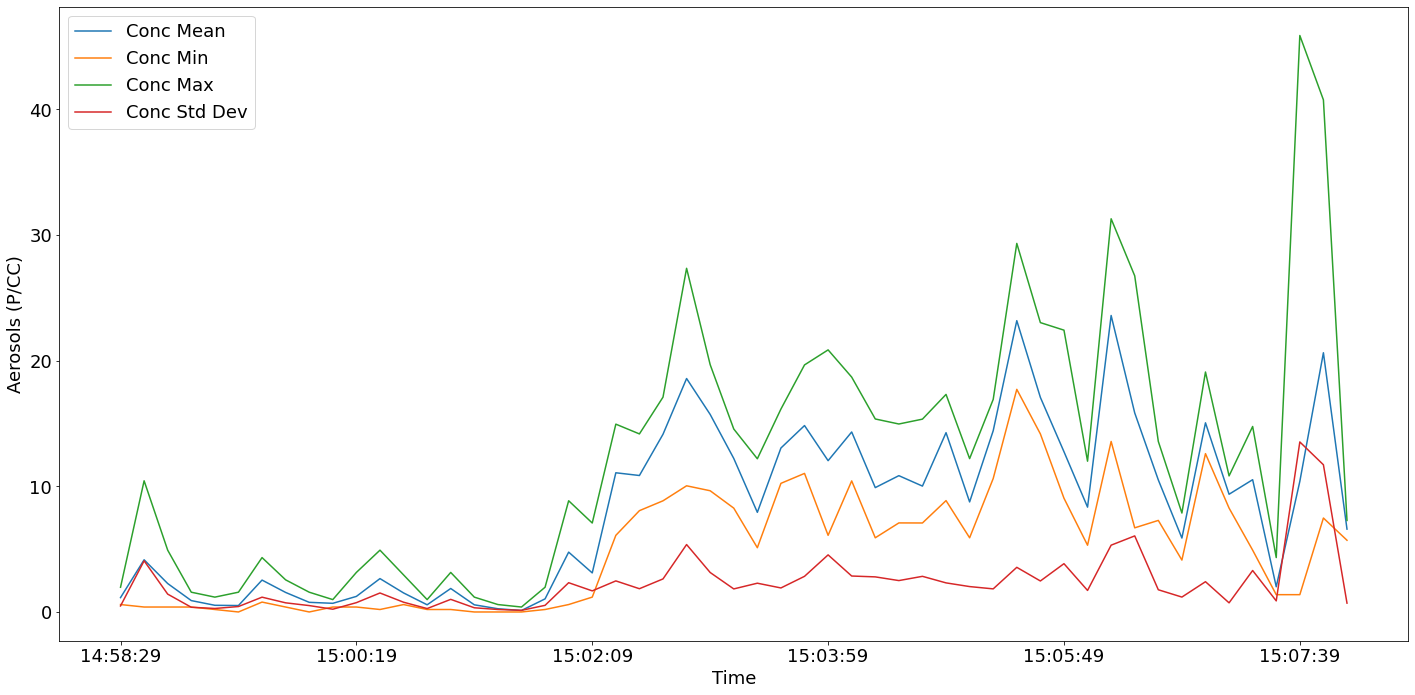

In [8]:

df3 = var[225:]
df3 = df3.drop('Sample #', 1)
df3 = df3.drop('Sample Length', 1)
df3 = df3.drop('Averaging Interval (s)', 1)
df3 = df3.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df3.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

# plt.axvspan(0, 106 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(106, 151 , color='yellow', alpha=0.2, lw=0)
# plt.axvspan(151, 160 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(160, 221 , color='red', alpha=0.2, lw=0)
# plt.axvspan(221, 237 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(237, 294 , color='black', alpha=0.2, lw=0)
# plt.axvspan(294, 306 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_graph.jpg')

In [9]:
import matplotlib.pyplot as plot

from scipy.io import wavfile

import statistics 
import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps
import math
import os

from Signal_Analysis.features import signal



# Read the wav file (mono)
def wav_plot(filename, m,n):
    WAV_FILE_NAME  = filename
    samplingFrequency, signalData = wavfile.read(WAV_FILE_NAME)
    
#     signalData = signalData[m:n]
    times = np.arange(len(signalData))/samplingFrequency
    print (len(times), times[-1])

    
    print(samplingFrequency)
    numchunks = 10
    chunks = np.array_split(signalData, numchunks)
    dbs = [20*math.log10( math.sqrt(statistics.mean(chunk**2)) ) for chunk in chunks]
    print ("average power", dbs)
    
    
    plt.figure(figsize=(20,7))

    # Plot the signal read from wav file

    plot.subplot(311)

    plot.title('Spectrogram of a wav file with air')



    plot.plot(times,signalData)

    plot.xlabel('Sample')

    plot.ylabel('Amplitude')



    plot.subplot(312)

    plot.specgram(signalData,Fs=samplingFrequency)

    plot.xlabel('Time')

    plot.ylabel('Frequency')
    

    plot.show()
    
    return samplingFrequency, signalData

(479620,)
zcr 5240
[-693. -846. -904. ... 1701. 1930. 2111.]
4.6361760407315014e+17
1199
Maximum power is 4.6361760407315014e+17 at frequency 119.9949960385305
Power at first harmonic is 1377210343794881.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1646323470290819e+18
Energy in 1 kHz - 8 kHz 1.0052811296978272e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.85140838952715


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5025
[2270. 2414. 2575. ... 2266. 2095. 1872.]
3.983142621658808e+17
1199
Maximum power is 3.983142621658808e+17 at frequency 119.9949960385305
Power at first harmonic is 300608955473476.4 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1670322551352225e+18
Energy in 1 kHz - 8 kHz 9833546158068228.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.67867769936646


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5100
[ 1641.  1429.  1202. ... -7519. -7351. -7202.]
3.500717910332682e+17
1199
Maximum power is 3.500717910332682e+17 at frequency 119.9949960385305
Power at first harmonic is 271875057251504.25 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.117584727359477e+18
Energy in 1 kHz - 8 kHz 1.0196923217320392e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.60019052228998


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5218
[-7138. -7179. -7252. ...  3617.  3648.  3693.]
3.069584593923716e+17
1199
Maximum power is 3.069584593923716e+17 at frequency 119.9949960385305
Power at first harmonic is 362487087032148.4 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1265655989759348e+18
Energy in 1 kHz - 8 kHz 1.0033247495622008e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.28324622386819


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5145
[3743. 3747. 3688. ...  233.  448.  788.]
2.4622071434729885e+17
1199
Maximum power is 2.4622071434729885e+17 at frequency 119.9949960385305
Power at first harmonic is 5539011759682.772 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1596758443427333e+18
Energy in 1 kHz - 8 kHz 9774384744951580.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.64438270057867


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5097
[1103. 1394. 1645. ... 1513. 1550. 1624.]
2.5232551800360486e+17
1200
Maximum power is 2.5232551800360486e+17 at frequency 120.09507526792044
Power at first harmonic is 74134688836399.77 at frequency 240.19015053584087
Energy in 0 Hz - 1 kHz 1.182376739789197e+18
Energy in 1 kHz - 8 kHz 9935573549055082.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.00437694426272


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5223
[1661. 1688. 1709. ... 2358. 2408. 2367.]
2.1044587493959776e+17
1200
Maximum power is 2.1044587493959776e+17 at frequency 120.09507526792044
Power at first harmonic is 10451590183736.324 at frequency 240.19015053584087
Energy in 0 Hz - 1 kHz 1.1358661801179503e+18
Energy in 1 kHz - 8 kHz 9903861306882864.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.68922523466277


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5142
[ 2237.  2144.  2200. ... -2067. -2022. -1956.]
2.6831724497697686e+17
1199
Maximum power is 2.6831724497697686e+17 at frequency 119.9949960385305
Power at first harmonic is 74428227020451.58 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1523395302757427e+18
Energy in 1 kHz - 8 kHz 9957437917733318.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.72650914785295


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5326
[-1938. -2002. -2106. ...   795.   755.   731.]
3.3452120844849664e+17
1199
Maximum power is 3.3452120844849664e+17 at frequency 119.9949960385305
Power at first harmonic is 1232588384347701.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1067980083565042e+18
Energy in 1 kHz - 8 kHz 9982494845184176.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.87388729185804


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7625
[ 790.  915. 1086. ... 1891. 1846. 1905.]
4.146402323497088e+17
1199
Maximum power is 4.146402323497088e+17 at frequency 119.9949960385305
Power at first harmonic is 1516735156070591.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.3301240640617815e+18
Energy in 1 kHz - 8 kHz 3.0916810504213624e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.02268061838074


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 6852
[ 2002.  2064.  2029. ... -3208. -3059. -2835.]
4.492758726492072e+17
1199
Maximum power is 4.492758726492072e+17 at frequency 119.9949960385305
Power at first harmonic is 1050159835865883.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4035400653913748e+18
Energy in 1 kHz - 8 kHz 2.7120324477208204e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.752333072965385


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7116
[-2709. -2694. -2857. ...  -509.   -48.   235.]
4.433791734330965e+17
1199
Maximum power is 4.433791734330965e+17 at frequency 119.9949960385305
Power at first harmonic is 1904372755211343.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4204015435518036e+18
Energy in 1 kHz - 8 kHz 2.3703360090160692e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.924058789513765


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7449
[ 453.  729. 1132. ... 3545. 3734. 3953.]
4.346014337706545e+17
1199
Maximum power is 4.346014337706545e+17 at frequency 119.9949960385305
Power at first harmonic is 2760051154149597.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.3841420021837059e+18
Energy in 1 kHz - 8 kHz 2.6731067438288908e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.78027422133901


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7384
[ 4129.  4240.  4275. ... -1600. -1590. -1534.]
3.436047194471565e+17
1199
Maximum power is 3.436047194471565e+17 at frequency 119.9949960385305
Power at first harmonic is 458966697069745.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4954778581393172e+18
Energy in 1 kHz - 8 kHz 3.0829964512244548e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.507284448717655


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7352
[-1478. -1455. -1432. ...  3104.  3070.  2986.]
3.031776865053066e+17
1199
Maximum power is 3.031776865053066e+17 at frequency 119.9949960385305
Power at first harmonic is 573040333931038.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.3341106069031875e+18
Energy in 1 kHz - 8 kHz 2.6911824948362916e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.5733979194281


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7821
[2927. 2938. 2955. ... 4253. 3631. 3001.]
3.660970721647597e+17
1199
Maximum power is 3.660970721647597e+17 at frequency 119.9949960385305
Power at first harmonic is 363933127754155.94 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.34119437563902e+18
Energy in 1 kHz - 8 kHz 3.0809738768776876e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.53150754391367


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7411
[2511. 2129. 1767. ... -216.  165.  551.]
3.498881212968714e+17
1199
Maximum power is 3.498881212968714e+17 at frequency 119.9949960385305
Power at first harmonic is 210668158939035.4 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.3896774656277722e+18
Energy in 1 kHz - 8 kHz 3.0236105286157296e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.96086210428678


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 8018
[  888.  1231.  1569. ... -3921. -4065. -4326.]
3.693191338461103e+17
1199
Maximum power is 3.693191338461103e+17 at frequency 119.9949960385305
Power at first harmonic is 371424693434858.25 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4030064998279552e+18
Energy in 1 kHz - 8 kHz 3.918694768381733e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.80290333271713


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7773
[-4538. -4657. -4688. ... -4602. -4806. -4964.]
3.7044868325974374e+17
1199
Maximum power is 3.7044868325974374e+17 at frequency 119.9949960385305
Power at first harmonic is 818514982257295.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4288819542159214e+18
Energy in 1 kHz - 8 kHz 2.915432965762767e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.01096924525177


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7278
[-5010. -5022. -5007. ...   222.   217.   205.]
4.174338940947081e+17
1199
Maximum power is 4.174338940947081e+17 at frequency 119.9949960385305
Power at first harmonic is 756502605016418.6 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.446993651761324e+18
Energy in 1 kHz - 8 kHz 3.467204015310379e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.733732580250006


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7601
[ 223.  202.  135. ... 4788. 4831. 4818.]
4.2261081588846925e+17
1199
Maximum power is 4.2261081588846925e+17 at frequency 119.9949960385305
Power at first harmonic is 1199949282941267.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.5925493182885243e+18
Energy in 1 kHz - 8 kHz 4.078958211425277e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.04304078987004


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 6990
[ 4716.  4586.  4466. ... -1963. -2041. -2143.]
3.3431529868877997e+17
1199
Maximum power is 3.3431529868877997e+17 at frequency 119.9949960385305
Power at first harmonic is 379599954674989.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4423375189225638e+18
Energy in 1 kHz - 8 kHz 3.6153584312798776e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.89473094682787


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7282
[-2292. -2470. -2626. ...  1694.  1843.  1879.]
3.076359888557217e+17
1199
Maximum power is 3.076359888557217e+17 at frequency 119.9949960385305
Power at first harmonic is 780860808582695.1 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4413307327843988e+18
Energy in 1 kHz - 8 kHz 3.368136249831068e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.793124323776695


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7524
[ 1831.  1755.  1597. ... -1620. -1694. -1839.]
3.7334919616501037e+17
1199
Maximum power is 3.7334919616501037e+17 at frequency 119.9949960385305
Power at first harmonic is 2264567039964862.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.5317945520864402e+18
Energy in 1 kHz - 8 kHz 4.171399651892474e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.721356856600835


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7125
[-1996. -2154. -2311. ... -1764. -1811. -1789.]
4.469219806583146e+17
1199
Maximum power is 4.469219806583146e+17 at frequency 119.9949960385305
Power at first harmonic is 989719662487272.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.418154387447666e+18
Energy in 1 kHz - 8 kHz 2.9417144796797e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.20843073805305


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 6962
[-1747. -1781. -1869. ...   581.   531.   534.]
3.9126582877215514e+17
1199
Maximum power is 3.9126582877215514e+17 at frequency 119.9949960385305
Power at first harmonic is 857902223747647.6 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.5792553084942075e+18
Energy in 1 kHz - 8 kHz 4.783097142570811e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.017420751053194


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7402
[  548.   597.   673. ... -6086. -7067. -7775.]
4.25815081928775e+17
1199
Maximum power is 4.25815081928775e+17 at frequency 119.9949960385305
Power at first harmonic is 930463895585972.9 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.493100714602494e+18
Energy in 1 kHz - 8 kHz 3.786964560371026e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.42737490144899


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7855
[-8275. -8611. -8838. ...  -366.  -397.  -466.]
4.389084317143378e+17
1199
Maximum power is 4.389084317143378e+17 at frequency 119.9949960385305
Power at first harmonic is 1085134438617153.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.5123544933331244e+18
Energy in 1 kHz - 8 kHz 4.39477675289886e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.41254421707662


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7885
[-520. -595. -703. ...  269.   95.  -92.]
4.575658039470311e+17
1199
Maximum power is 4.575658039470311e+17 at frequency 119.9949960385305
Power at first harmonic is 1439052178552833.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.6749034069962808e+18
Energy in 1 kHz - 8 kHz 3.354863828268035e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.924631601544256


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7512
[-190. -239. -333. ... 3277. 3160. 2994.]
4.4015061692813754e+17
1199
Maximum power is 4.4015061692813754e+17 at frequency 119.9949960385305
Power at first harmonic is 2184005485143902.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4517889118704028e+18
Energy in 1 kHz - 8 kHz 3.4204320138759524e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.444606587144825


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7213
[2664. 2090. 1446. ... 1881. 1774. 1644.]
2.756824533469992e+17
1199
Maximum power is 2.756824533469992e+17 at frequency 119.9949960385305
Power at first harmonic is 18522367223218.56 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.3226608318228352e+18
Energy in 1 kHz - 8 kHz 2.7168529680470164e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.68356320267185


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 8202
[ 1561.  1552.  1522. ... -5673. -5586. -5517.]
2.656393577484741e+17
1199
Maximum power is 2.656393577484741e+17 at frequency 119.9949960385305
Power at first harmonic is 572480294009800.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4088277751442314e+18
Energy in 1 kHz - 8 kHz 4.537928323552709e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.04561541512562


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7236
[-5483. -5496. -5503. ...  8926.  9645. 10025.]
3.0763025764613165e+17
1199
Maximum power is 3.0763025764613165e+17 at frequency 119.9949960385305
Power at first harmonic is 199893925279183.62 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.310512606713156e+18
Energy in 1 kHz - 8 kHz 3.537088087250489e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.050607007411756


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 8179
[10333. 10661. 10777. ...  1791.  2162.  2591.]
3.124706151340898e+17
1199
Maximum power is 3.124706151340898e+17 at frequency 119.9949960385305
Power at first harmonic is 7992154182859.692 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4757055990269727e+18
Energy in 1 kHz - 8 kHz 4.4876442388154296e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.883747474075705


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7614
[2973. 3339. 3639. ... 1082.  562.   -4.]
2.637845636633268e+17
1199
Maximum power is 2.637845636633268e+17 at frequency 119.9949960385305
Power at first harmonic is 29770134594121.15 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.421586964091369e+18
Energy in 1 kHz - 8 kHz 4.61653879475035e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.793350327910424


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7708
[ -578. -1192. -1783. ...  7477.  7482.  7544.]
2.8396951868674707e+17
1199
Maximum power is 2.8396951868674707e+17 at frequency 119.9949960385305
Power at first harmonic is 195514372893588.53 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.3609586046597379e+18
Energy in 1 kHz - 8 kHz 3.770812945445135e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.0919150419189


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 6997
[7666. 7806. 7860. ... 4340. 4625. 4845.]
4.313115005189046e+17
1199
Maximum power is 4.313115005189046e+17 at frequency 119.9949960385305
Power at first harmonic is 644519138737831.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.588784523207783e+18
Energy in 1 kHz - 8 kHz 3.6144719516459256e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.95620008848863


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 8201
[4896. 4871. 4774. ...  771. 1094. 1456.]
4.319479543166096e+17
1199
Maximum power is 4.319479543166096e+17 at frequency 119.9949960385305
Power at first harmonic is 1710995941663866.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.596450238662204e+18
Energy in 1 kHz - 8 kHz 4.168723274373782e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.29590341186702


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 7402
[ 1797.  1989.  2053. ... -2586. -2568. -2541.]
4.580300753758359e+17
1199
Maximum power is 4.580300753758359e+17 at frequency 119.9949960385305
Power at first harmonic is 1399266934467189.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.545518255166655e+18
Energy in 1 kHz - 8 kHz 5.206843681723483e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.682440066168514


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 6391
[-2569. -2628. -2637. ... -1877. -1689. -1480.]
4.524655666887646e+17
1199
Maximum power is 4.524655666887646e+17 at frequency 119.9949960385305
Power at first harmonic is 1400248059330340.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.366490291058116e+18
Energy in 1 kHz - 8 kHz 2.2949345356673464e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.543759084210784


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5186
[-1232.  -919.  -590. ...  1671.  1688.  1773.]
4.753197577194269e+17
1199
Maximum power is 4.753197577194269e+17 at frequency 119.9949960385305
Power at first harmonic is 1629165089258010.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1510047304869059e+18
Energy in 1 kHz - 8 kHz 9938840308580542.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.80875582568763


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5350
[ 1889.  1923.  1848. ... -1406. -1489. -1512.]
3.7679976887229485e+17
1199
Maximum power is 3.7679976887229485e+17 at frequency 119.9949960385305
Power at first harmonic is 528208290944658.44 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.0625396680449189e+18
Energy in 1 kHz - 8 kHz 1.0006021792051024e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.19002138182637


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5189
[-1506. -1443. -1338. ... -2832. -2971. -3085.]
4.225897479659373e+17
1199
Maximum power is 4.225897479659373e+17 at frequency 119.9949960385305
Power at first harmonic is 765444359620056.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.181442078483571e+18
Energy in 1 kHz - 8 kHz 1.0184907690174834e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.99929173862648


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5218
[-3194. -3222. -3151. ...  5325.  5283.  5181.]
3.5047423545286637e+17
1199
Maximum power is 3.5047423545286637e+17 at frequency 119.9949960385305
Power at first harmonic is 680943968926723.1 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1214138348996177e+18
Energy in 1 kHz - 8 kHz 9970675018804614.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.47120508738276


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9043
[5097. 5064. 4975. ... 2082. 2019. 1959.]
2.5581375703228746e+17
1199
Maximum power is 2.5581375703228746e+17 at frequency 119.9949960385305
Power at first harmonic is 480947627654842.1 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.6330212427044178e+18
Energy in 1 kHz - 8 kHz 8.243882748563794e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.80888487271261


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9130
[ 1954.  2035.  2169. ... -6146. -6593. -7022.]
3.1722069098961574e+17
1199
Maximum power is 3.1722069098961574e+17 at frequency 119.9949960385305
Power at first harmonic is 346525577849262.3 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.9429204792036e+18
Energy in 1 kHz - 8 kHz 1.669973845635316e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.634436576846182


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10027
[-7365. -7620. -7780. ...  -727.  -828.  -971.]
4.096351602818096e+17
1199
Maximum power is 4.096351602818096e+17 at frequency 119.9949960385305
Power at first harmonic is 550754139782465.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.985442539380726e+18
Energy in 1 kHz - 8 kHz 8.865303419694634e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.395652414670707


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9942
[-1076. -1139. -1156. ...  4129.  4105.  4131.]
4.5856123332454234e+17
1199
Maximum power is 4.5856123332454234e+17 at frequency 119.9949960385305
Power at first harmonic is 1849885047096507.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.1643950238752678e+18
Energy in 1 kHz - 8 kHz 1.4597769363345232e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.826888752674977


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9417
[4105. 4011. 3937. ... 2661. 2387. 2124.]
4.549828488007836e+17
1199
Maximum power is 4.549828488007836e+17 at frequency 119.9949960385305
Power at first harmonic is 1479804289073201.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.997351806202144e+18
Energy in 1 kHz - 8 kHz 1.157130664682494e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.261246868349122


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9546
[ 1865.  1652.  1612. ... -1754. -1933. -2320.]
4.4038081688238637e+17
1199
Maximum power is 4.4038081688238637e+17 at frequency 119.9949960385305
Power at first harmonic is 1470416446403430.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.883566718011674e+18
Energy in 1 kHz - 8 kHz 8.949036316042438e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.04770448450532


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9289
[-2731. -3060. -3259. ... -2359. -2332. -2337.]
3.946782703996749e+17
1199
Maximum power is 3.946782703996749e+17 at frequency 119.9949960385305
Power at first harmonic is 840332170001337.4 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.8807600654490573e+18
Energy in 1 kHz - 8 kHz 8.616864549316264e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.826501445915067


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9942
[-2442. -2577. -2693. ...    30.    99.   198.]
3.629638531287583e+17
1199
Maximum power is 3.629638531287583e+17 at frequency 119.9949960385305
Power at first harmonic is 359881900325961.56 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.7267981927575846e+18
Energy in 1 kHz - 8 kHz 8.637750122867488e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.991295976322323


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9216
[  300.   237.   168. ... -3345. -3364. -3415.]
4.665327517523888e+17
1199
Maximum power is 4.665327517523888e+17 at frequency 119.9949960385305
Power at first harmonic is 1863382481120000.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.745530175346507e+18
Energy in 1 kHz - 8 kHz 6.96400746202651e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.0650244828796


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9782
[-3462. -3360. -3187. ...  3362.  3323.  3401.]
4.238903657879617e+17
1199
Maximum power is 4.238903657879617e+17 at frequency 119.9949960385305
Power at first harmonic is 984776536871929.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.1856279759385523e+18
Energy in 1 kHz - 8 kHz 1.1405770885317123e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.162474837646922


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10037
[3541. 3711. 3860. ...  935. 1045. 1167.]
4.579205430647606e+17
1199
Maximum power is 4.579205430647606e+17 at frequency 119.9949960385305
Power at first harmonic is 1773487732901140.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.5762760427455754e+18
Energy in 1 kHz - 8 kHz 1.8832929801430838e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.679634926212287


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9734
[ 1364.  1650.  1978. ... -1550. -1876. -2156.]
4.2439123295217645e+17
1199
Maximum power is 4.2439123295217645e+17 at frequency 119.9949960385305
Power at first harmonic is 1344158582229059.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.227346059798798e+18
Energy in 1 kHz - 8 kHz 1.306275851398173e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.051115638513544


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9563
[-2454. -2774. -3135. ... -1250.  -971. -1213.]
4.2238653849041094e+17
1199
Maximum power is 4.2238653849041094e+17 at frequency 119.9949960385305
Power at first harmonic is 1479545166935537.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.3020455466279388e+18
Energy in 1 kHz - 8 kHz 1.4262948841549112e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.140039287821715


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9544
[-1854. -2056. -2281. ...   460.   264.   173.]
4.459863135645034e+17
1199
Maximum power is 4.459863135645034e+17 at frequency 119.9949960385305
Power at first harmonic is 2173960898792489.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.9199745188301586e+18
Energy in 1 kHz - 8 kHz 1.089710183481633e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.619129819415143


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9725
[ 137.  -93. -279. ... 6808. 6554. 6360.]
4.366737830937037e+17
1199
Maximum power is 4.366737830937037e+17 at frequency 119.9949960385305
Power at first harmonic is 1405703323347945.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.3209669176311516e+18
Energy in 1 kHz - 8 kHz 1.5945614027265597e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.555519239726376


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 8810
[ 6202.  5941.  5655. ... -1336. -1194. -1100.]
3.130750461443412e+17
1199
Maximum power is 3.130750461443412e+17 at frequency 119.9949960385305
Power at first harmonic is 1133346117723631.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.7567128588120576e+18
Energy in 1 kHz - 8 kHz 7.50379554860403e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.410990443881


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10385
[-1038. -1056. -1140. ... -3340. -3280. -3309.]
3.539375445859194e+17
1199
Maximum power is 3.539375445859194e+17 at frequency 119.9949960385305
Power at first harmonic is 139213306131686.05 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.1468901204748882e+18
Energy in 1 kHz - 8 kHz 1.382752302872976e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.526208967537032


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9831
[-3370. -3414. -3466. ... -4850. -5011. -5161.]
4.716068219017986e+17
1199
Maximum power is 4.716068219017986e+17 at frequency 119.9949960385305
Power at first harmonic is 403778416631514.7 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.8308057901177718e+18
Energy in 1 kHz - 8 kHz 9.191216463264984e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.919080324514706


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11555
[-5327. -5439. -5477. ... -1342. -1319. -1397.]
4.4937572060466355e+17
1199
Maximum power is 4.4937572060466355e+17 at frequency 119.9949960385305
Power at first harmonic is 269195694503897.03 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.982032216705583e+18
Energy in 1 kHz - 8 kHz 1.072733006144312e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.47647276025872


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9395
[-1418. -1527. -1647. ... -4712. -4901. -4968.]
4.270027264099063e+17
1199
Maximum power is 4.270027264099063e+17 at frequency 119.9949960385305
Power at first harmonic is 517005777479818.44 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.7050230253033295e+18
Energy in 1 kHz - 8 kHz 1.4229634732645549e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.982198119194692


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11008
[-5008. -5036. -5085. ...  3423.  3312.  3066.]
3.044491040076593e+17
1199
Maximum power is 3.044491040076593e+17 at frequency 119.9949960385305
Power at first harmonic is 5053367209058.324 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.8852470513946982e+18
Energy in 1 kHz - 8 kHz 1.2381837323881371e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.2259071257425


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9012
[ 2835.  2731.  2690. ... -5428. -3830. -2058.]
2.2944935188865146e+17
1199
Maximum power is 2.2944935188865146e+17 at frequency 119.9949960385305
Power at first harmonic is 294629401218.3342 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.208570164215994e+18
Energy in 1 kHz - 8 kHz 1.9123553056847062e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.54895305098772


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11257
[-2709. -4063. -3819. ...  -554.  -414.  -287.]
3.39350329237051e+17
1199
Maximum power is 3.39350329237051e+17 at frequency 119.9949960385305
Power at first harmonic is 19229714439708.742 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.2911315726302193e+18
Energy in 1 kHz - 8 kHz 1.917055932464567e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.951302691960274


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10766
[-154.  -22.   85. ...  473.  684.  816.]
4.701971205354601e+17
1199
Maximum power is 4.701971205354601e+17 at frequency 119.9949960385305
Power at first harmonic is 1022786726725238.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.5793997873433267e+18
Energy in 1 kHz - 8 kHz 1.6133666934053862e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.987684621770036


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 8801
[844. 851. 927. ... 448. 408. 444.]
4.6151607540500896e+17
1199
Maximum power is 4.6151607540500896e+17 at frequency 119.9949960385305
Power at first harmonic is 907168678855614.1 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.4095108755595807e+18
Energy in 1 kHz - 8 kHz 1.3220274209080432e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.225876691003826


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10439
[ 586.  763.  854. ... 3457. 3539. 3473.]
4.412403905207258e+17
1199
Maximum power is 4.412403905207258e+17 at frequency 119.9949960385305
Power at first harmonic is 615916594696773.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.5199329435844613e+18
Energy in 1 kHz - 8 kHz 1.498868035518012e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.812240196406396


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10924
[ 3410.  3440.  3528. ... -4007. -4167. -4208.]
4.700624330568223e+17
1199
Maximum power is 4.700624330568223e+17 at frequency 119.9949960385305
Power at first harmonic is 706045384788503.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.974837931580114e+18
Energy in 1 kHz - 8 kHz 1.1200748116694277e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.631303829042412


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11068
[-4064. -3890. -3780. ...   504.   626.   753.]
4.165909176889438e+17
1199
Maximum power is 4.165909176889438e+17 at frequency 119.9949960385305
Power at first harmonic is 241276601476099.03 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.976099297145777e+18
Energy in 1 kHz - 8 kHz 1.4337997934085251e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.782254023402116


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 13025
[ 882.  958.  994. ... 1034. 1158. 1167.]
2.06423279711865e+17
1200
Maximum power is 2.06423279711865e+17 at frequency 120.09507526792044
Power at first harmonic is 52279057634754.164 at frequency 240.19015053584087
Energy in 0 Hz - 1 kHz 2.572075468234734e+18
Energy in 1 kHz - 8 kHz 2.703144206963732e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.515124874243321


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 9488
[ 1084.   981.   916. ... -1342. -1285. -1177.]
1.9035768812134614e+17
1200
Maximum power is 1.9035768812134614e+17 at frequency 120.09507526792044
Power at first harmonic is 155901074751625.75 at frequency 240.19015053584087
Energy in 0 Hz - 1 kHz 1.9329182952353124e+18
Energy in 1 kHz - 8 kHz 1.184139128205457e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.323405326235758


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5170
[-1043.  -905.  -824. ...  3983.  3885.  3743.]
2.5343143552391722e+17
1199
Maximum power is 2.5343143552391722e+17 at frequency 119.9949960385305
Power at first harmonic is 5935837931384.828 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1883543491579297e+18
Energy in 1 kHz - 8 kHz 1.0024884552457646e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.54045230541824


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5430
[ 3573.  3410.  3329. ... -2149. -2148. -2141.]
3.113101963761377e+17
1199
Maximum power is 3.113101963761377e+17 at frequency 119.9949960385305
Power at first harmonic is 160894675256138.53 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1272810702777773e+18
Energy in 1 kHz - 8 kHz 1.0157071786846862e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.98484818602704


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5178
[-2132. -2107. -2089. ...  1058.  1200.  1302.]
3.932353123337775e+17
1199
Maximum power is 3.932353123337775e+17 at frequency 119.9949960385305
Power at first harmonic is 545034584970183.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1438844929422843e+18
Energy in 1 kHz - 8 kHz 9980465625774368.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.6123373230427


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5379
[1328. 1271. 1259. ... 4458. 4375. 4322.]
3.3106835399250106e+17
1199
Maximum power is 3.3106835399250106e+17 at frequency 119.9949960385305
Power at first harmonic is 231305954054832.66 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1043998552845972e+18
Energy in 1 kHz - 8 kHz 9718829202155436.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.63507191171382


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5207
[4292. 4313. 4366. ... 2710. 2606. 2523.]
3.8384368397940794e+17
1199
Maximum power is 3.8384368397940794e+17 at frequency 119.9949960385305
Power at first harmonic is 221105699071548.16 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1611547969586258e+18
Energy in 1 kHz - 8 kHz 9838469550400708.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.02189263383282


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 5304
[ 2431.  2380.  2389. ... -2259. -2345. -2391.]
4.1841006315038496e+17
1199
Maximum power is 4.1841006315038496e+17 at frequency 119.9949960385305
Power at first harmonic is 492683933122170.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1344116811816462e+18
Energy in 1 kHz - 8 kHz 9812129944410418.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.61319383340165


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11209
[-2444. -2505. -2611. ... -5662. -5530. -5408.]
4.546149825084462e+17
1199
Maximum power is 4.546149825084462e+17 at frequency 119.9949960385305
Power at first harmonic is 1292352787613766.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.2807235999054295e+18
Energy in 1 kHz - 8 kHz 3.2999492989046995e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.941739410948976


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11319
[-5258. -5149. -5030. ...  -786.  -951. -1186.]
4.338917686642089e+17
1199
Maximum power is 4.338917686642089e+17 at frequency 119.9949960385305
Power at first harmonic is 1340933515666033.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.2989384492798167e+18
Energy in 1 kHz - 8 kHz 4.960773698819301e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.650048257724369


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11588
[-1350. -1396. -1330. ...  9987.  9343.  8531.]
4.232121888121971e+17
1199
Maximum power is 4.232121888121971e+17 at frequency 119.9949960385305
Power at first harmonic is 1051982393598312.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.214109501266033e+18
Energy in 1 kHz - 8 kHz 2.6553788101293328e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.104146832102975


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11379
[7879. 7651. 7732. ... 4843. 4388. 4015.]
4.2567295463412506e+17
1199
Maximum power is 4.2567295463412506e+17 at frequency 119.9949960385305
Power at first harmonic is 831107591666601.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.75067617028685e+18
Energy in 1 kHz - 8 kHz 2.2006092312153613e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.499612067734969


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11642
[ 3769.  3573.  3410. ... -9333. -9193. -8808.]
4.003417190797631e+17
1199
Maximum power is 4.003417190797631e+17 at frequency 119.9949960385305
Power at first harmonic is 494306287506874.9 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.565675016975311e+18
Energy in 1 kHz - 8 kHz 2.2436653142579203e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.435194904833182


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 12527
[-8303. -7707. -6885. ... -9203. -9542. -9959.]
4.2477989938302554e+17
1199
Maximum power is 4.2477989938302554e+17 at frequency 119.9949960385305
Power at first harmonic is 175006175899335.78 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.849992447478238e+18
Energy in 1 kHz - 8 kHz 2.2983445403887552e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.400196738980545


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 12683
[-10383. -10748. -10990. ...    860.    271.   -112.]
4.335702208650373e+17
1199
Maximum power is 4.335702208650373e+17 at frequency 119.9949960385305
Power at first harmonic is 1209937004654871.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.7888688883271014e+18
Energy in 1 kHz - 8 kHz 2.008982248540726e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.881998660530053


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 12003
[ 1372.   809. -3261. ...  7980.  7837.  7805.]
4.018320766062154e+17
1199
Maximum power is 4.018320766062154e+17 at frequency 119.9949960385305
Power at first harmonic is 536804679067758.9 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.8332231915366687e+18
Energy in 1 kHz - 8 kHz 3.109970008677397e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.11013027016803


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 12789
[7980. 8101. 8050. ...  583.  640.  709.]
4.646645573893847e+17
1199
Maximum power is 4.646645573893847e+17 at frequency 119.9949960385305
Power at first harmonic is 1509919081846892.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.482062627620558e+18
Energy in 1 kHz - 8 kHz 3.6272362191369485e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.599768025168945


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 12467
[ 847.  992. 1142. ...  301.  464.  497.]
4.4198582265093037e+17
1199
Maximum power is 4.4198582265093037e+17 at frequency 119.9949960385305
Power at first harmonic is 2125479124588196.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.4310622461059e+18
Energy in 1 kHz - 8 kHz 3.3722620783710483e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.174364169712618


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10251
[ 564.  692.  937. ...  991. 1132.  950.]
2.73799038078519e+17
1199
Maximum power is 2.73799038078519e+17 at frequency 119.9949960385305
Power at first harmonic is 43460740433140.25 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.188378574948546e+18
Energy in 1 kHz - 8 kHz 3.167170031909073e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.066963702061456


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10881
[ 543. -124. -940. ... 2201. 2078. 1946.]
2.419494286267884e+17
1199
Maximum power is 2.419494286267884e+17 at frequency 119.9949960385305
Power at first harmonic is 140255029873787.88 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.835306670056552e+18
Energy in 1 kHz - 8 kHz 2.3104063352289725e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.271896189098527


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11319
[1881. 1831. 1857. ...  860. 2545. 2479.]
3.702634977166259e+17
1199
Maximum power is 3.702634977166259e+17 at frequency 119.9949960385305
Power at first harmonic is 266698793273607.16 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.413106567284723e+18
Energy in 1 kHz - 8 kHz 3.022220220750084e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.293374797279416


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11303
[ 113. -431. 1573. ... 1297. 1430. 1587.]
4.574806032126313e+17
1199
Maximum power is 4.574806032126313e+17 at frequency 119.9949960385305
Power at first harmonic is 871419222839702.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.177264027692247e+18
Energy in 1 kHz - 8 kHz 3.9211280940882323e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.102933521816114


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11520
[ 1694.  1687.  1628. ... -3740. -3836. -3874.]
4.7755477421489754e+17
1199
Maximum power is 4.7755477421489754e+17 at frequency 119.9949960385305
Power at first harmonic is 792993108835048.6 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.111926201133093e+18
Energy in 1 kHz - 8 kHz 2.8481519580729238e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.926124191908075


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11188
[-3962. -4072. -4148. ...  8909.  9099.  9265.]
4.1913624900317504e+17
1199
Maximum power is 4.1913624900317504e+17 at frequency 119.9949960385305
Power at first harmonic is 1121812831193409.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.538981674609621e+18
Energy in 1 kHz - 8 kHz 2.6580809191354643e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.551935218869936


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11727
[9417. 9663. 9937. ... 7355. 7350. 7375.]
4.055102688410887e+17
1199
Maximum power is 4.055102688410887e+17 at frequency 119.9949960385305
Power at first harmonic is 586145402246709.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.8924017179293594e+18
Energy in 1 kHz - 8 kHz 2.1091091294216035e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.713855189288209


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11120
[7465. 7593. 7692. ... -438. -449. -459.]
4.51144874101571e+17
1199
Maximum power is 4.51144874101571e+17 at frequency 119.9949960385305
Power at first harmonic is 1860774842268535.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.7949891086017065e+18
Energy in 1 kHz - 8 kHz 2.5814532605957658e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.827192385256122


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 11114
[-441. -298. -209. ... 4392. 4392. 4432.]
4.681852489118076e+17
1199
Maximum power is 4.681852489118076e+17 at frequency 119.9949960385305
Power at first harmonic is 615455816285552.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.802642721031439e+18
Energy in 1 kHz - 8 kHz 1.520869985244587e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.42789158983052


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479620,)
zcr 10822
[ 4425.  4370.  4246. ... -1554. -1653. -1769.]
4.1618793306697043e+17
1199
Maximum power is 4.1618793306697043e+17 at frequency 119.9949960385305
Power at first harmonic is 1793806653394229.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.7710126998316616e+18
Energy in 1 kHz - 8 kHz 2.8278985627441827e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.798840511247619


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 13600
[-1909. -2063. -2243. ...  2807.  3443.  3896.]
4.493459839490214e+17
1199
Maximum power is 4.493459839490214e+17 at frequency 119.99549641589766
Power at first harmonic is 932525513115973.2 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 3.28906934338184e+18
Energy in 1 kHz - 8 kHz 4.569773577568988e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.197444878946381


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 12968
[ 4221.  4488.  4783. ... -1285. -2292. -2589.]
4.419185442417114e+17
1199
Maximum power is 4.419185442417114e+17 at frequency 119.99549641589766
Power at first harmonic is 1294419717221153.8 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 4.0372782914133074e+18
Energy in 1 kHz - 8 kHz 5.739247800351061e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.034507712258657


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 13014
[-1671.  -549.  -710. ...  3437.  2569.  1833.]
4.6873885167937165e+17
1199
Maximum power is 4.6873885167937165e+17 at frequency 119.99549641589766
Power at first harmonic is 1091321032856288.4 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 4.5800990577516687e+18
Energy in 1 kHz - 8 kHz 5.0052811457020576e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.15053305583946


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 13514
[ 1286.   685.    62. ... -1557. -1124.  -723.]
4.6475513141569715e+17
1199
Maximum power is 4.6475513141569715e+17 at frequency 119.99549641589766
Power at first harmonic is 1848990304438352.2 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 3.6963456939806003e+18
Energy in 1 kHz - 8 kHz 3.529399361784168e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.473016270145294


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 11209
[ -148.   751.  1815. ... -8192. -8552. -8771.]
4.450169215077854e+17
1199
Maximum power is 4.450169215077854e+17 at frequency 119.99549641589766
Power at first harmonic is 922297165236532.6 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 3.1890260370160594e+18
Energy in 1 kHz - 8 kHz 3.3032883131676006e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.654095357961738


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 12313
[-8601. -8681. -9402. ...  -168.  -492. -1557.]
3.678158474507225e+17
1199
Maximum power is 3.678158474507225e+17 at frequency 119.99549641589766
Power at first harmonic is 674183640836670.9 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 3.7919170786235924e+18
Energy in 1 kHz - 8 kHz 3.4368863897587706e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.033000945049396


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 12625
[-3504. -5964. -8486. ...  -409.  -539.  -600.]
4.298534014617538e+17
1199
Maximum power is 4.298534014617538e+17 at frequency 119.99549641589766
Power at first harmonic is 520485112836704.0 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 3.120043290830591e+18
Energy in 1 kHz - 8 kHz 2.429202874797412e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.843897573152647


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 10214
[ -678.  -884. -1261. ...  -774.  -275.   240.]
4.370302855278851e+17
1199
Maximum power is 4.370302855278851e+17 at frequency 119.99549641589766
Power at first harmonic is 1168789946852895.2 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 2.5242919773080253e+18
Energy in 1 kHz - 8 kHz 1.922262293355658e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.131881044711205


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 12394
[  759.  1310.  1949. ... -8067. -8042. -7943.]
4.719460157227414e+17
1199
Maximum power is 4.719460157227414e+17 at frequency 119.99549641589766
Power at first harmonic is 1475353186309172.8 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 2.5565540848825293e+18
Energy in 1 kHz - 8 kHz 1.843009620749617e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.871626366457537


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 10592
[-7871. -7697. -7319. ...  3000.  3001.  2942.]
4.617594838898191e+17
1199
Maximum power is 4.617594838898191e+17 at frequency 119.99549641589766
Power at first harmonic is 1611640113850334.5 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 3.180807581583849e+18
Energy in 1 kHz - 8 kHz 2.483978182399195e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.805295972896223


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 6779
[2725. 2463. 2254. ... 1828. 1918. 2094.]
4.664414438154699e+17
1199
Maximum power is 4.664414438154699e+17 at frequency 119.99549641589766
Power at first harmonic is 1149784086111232.2 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 1.4451978411383718e+18
Energy in 1 kHz - 8 kHz 4.431902834734736e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.60896944336713


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 5150
[2274. 2406. 2482. ... -773. -663. -659.]
4.750011782990454e+17
1199
Maximum power is 4.750011782990454e+17 at frequency 119.99549641589766
Power at first harmonic is 1341120397321191.8 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 1.1600172781878515e+18
Energy in 1 kHz - 8 kHz 1.0122273026154838e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.60047315365775


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 5302
[-704. -722. -676. ... 1862. 1963. 2023.]
3.6943373342232237e+17
1199
Maximum power is 3.6943373342232237e+17 at frequency 119.99549641589766
Power at first harmonic is 839163870134319.6 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 1.1191871932831267e+18
Energy in 1 kHz - 8 kHz 1.0151080322384636e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.25301324974772


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 5172
[ 2105.  2200.  2290. ... -5472. -5405. -5416.]
2.1337683865121658e+17
1199
Maximum power is 2.1337683865121658e+17 at frequency 119.99549641589766
Power at first harmonic is 16817292073368.734 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 1.1681386707827274e+18
Energy in 1 kHz - 8 kHz 1.0050918835429714e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.22207779302848


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 5210
[-5453. -5514. -5544. ...  1078.  1122.  1196.]
2.2332622892331648e+17
1200
Maximum power is 2.2332622892331648e+17 at frequency 120.0955760626165
Power at first harmonic is 168318585883653.9 at frequency 240.191152125233
Energy in 0 Hz - 1 kHz 1.1819468047466944e+18
Energy in 1 kHz - 8 kHz 9830399560640604.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.2338518852302


(998, 12) (12,) (12,)
Filter bank:  (998, 12)
(479619,)
zcr 5320
[ 1224.  1200.  1202. ... -2717. -2483. -2262.]
2.7646576868878618e+17
1199
Maximum power is 2.7646576868878618e+17 at frequency 119.99549641589766
Power at first harmonic is 276587883924939.16 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 1.1248720218340671e+18
Energy in 1 kHz - 8 kHz 9840231292798310.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.31357539911872


(998, 12) (12,) (12,)
Filter bank:  (998, 12)


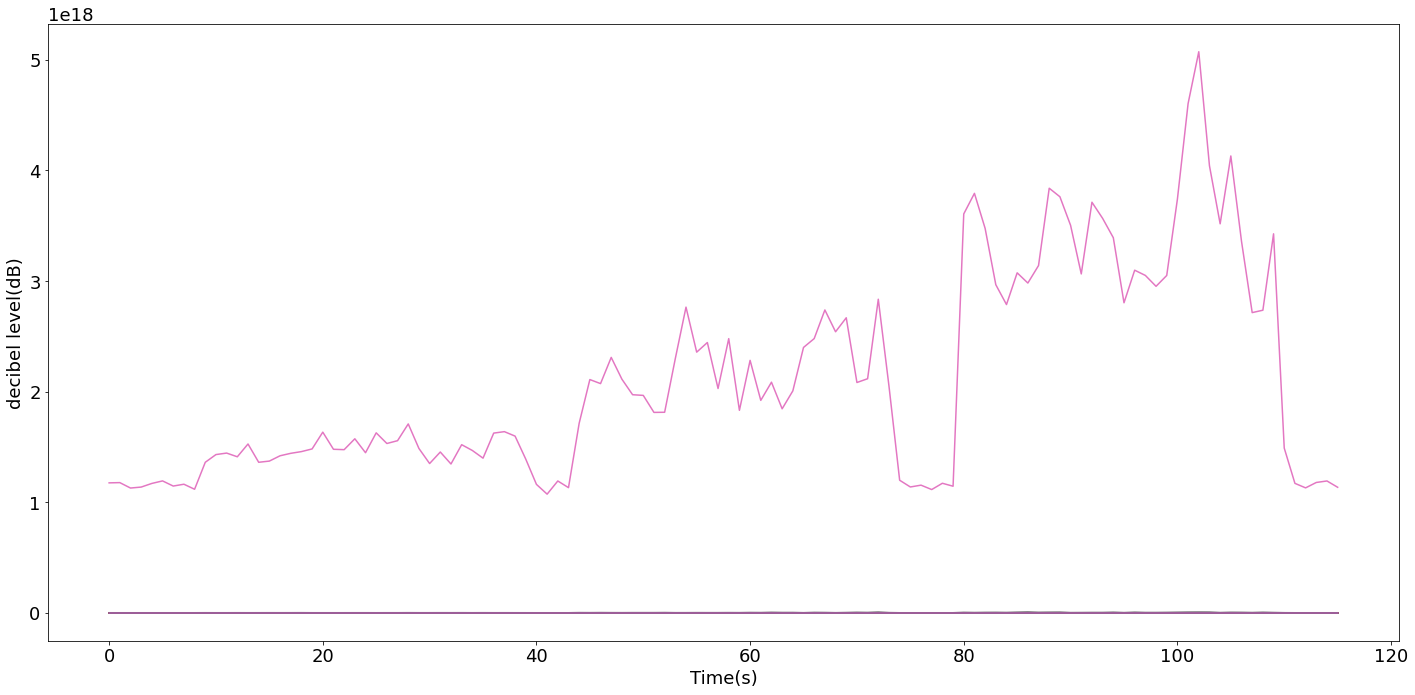

In [10]:
from scipy.io.wavfile import read
samprate, wavdata = read('0606_exp_actlevel.wav')
import numpy as np
import math
import statistics 
# import pyaudio
import time
from math import log10
import audioop  
# basically taking a reading every half a second - the size of the data 
# divided by the sample rate gives us 1 second chunks so I chop 
# sample rate in half for half second chunks
dbs1 = []
WIDTH = 2

chunks = np.array_split(wavdata, 116)
for chunk in chunks:
    print(chunk.shape)
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs1.append(a)
# print(dbs)
x = range(0,11600)
plt.plot(dbs1)
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_actlevel.png")

(478834,)
zcr 5104
[-1622. -1486. -1302. ...  3605.  3362.  3200.]
4.760531120581478e+17
1197
Maximum power is 4.760531120581478e+17 at frequency 119.99147930180396
Power at first harmonic is 2576278690465810.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1915516846388114e+18
Energy in 1 kHz - 8 kHz 9898305238449814.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.37936353086458


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 4998
[ 3057.  2954.  2955. ... -1181. -1216. -1234.]
4.475240426609729e+17
1197
Maximum power is 4.475240426609729e+17 at frequency 119.99147930180396
Power at first harmonic is 1478577712678259.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1294272960986455e+18
Energy in 1 kHz - 8 kHz 9767670903914570.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.62913075275777


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5314
[-1321. -1407. -1560. ...  1295.  1513.  1750.]
4.0267252883647366e+17
1197
Maximum power is 4.0267252883647366e+17 at frequency 119.99147930180396
Power at first harmonic is 1131767443293409.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1387016359219314e+18
Energy in 1 kHz - 8 kHz 9614996424950520.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.4297513587262


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5196
[1942. 2082. 2161. ... -152. -236. -319.]
3.9416886946840576e+17
1197
Maximum power is 3.9416886946840576e+17 at frequency 119.99147930180396
Power at first harmonic is 670509133947199.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1094484728593676e+18
Energy in 1 kHz - 8 kHz 9383341199663608.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.23597258715704


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5087
[ -402.  -481.  -615. ... -3986. -3834. -3777.]
4.3709359849337434e+17
1197
Maximum power is 4.3709359849337434e+17 at frequency 119.99147930180396
Power at first harmonic is 1471313001531765.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1308684064278568e+18
Energy in 1 kHz - 8 kHz 9887432050352218.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.37432901372729


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5124
[-3723. -3732. -3767. ...  1308.  1382.  1475.]
3.661718806449644e+17
1197
Maximum power is 3.661718806449644e+17 at frequency 119.99147930180396
Power at first harmonic is 1334077408763771.8 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1616058315575844e+18
Energy in 1 kHz - 8 kHz 9569680296351380.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.3839747604179


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5069
[1617. 1721. 1801. ... 4656. 4711. 4816.]
3.223309017365241e+17
1197
Maximum power is 3.223309017365241e+17 at frequency 119.99147930180396
Power at first harmonic is 368152445220365.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.127521974420145e+18
Energy in 1 kHz - 8 kHz 9638595420829688.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.979904767399


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5032
[ 4896.  4900.  4856. ... -8182. -8164. -8152.]
3.524878078163653e+17
1197
Maximum power is 3.524878078163653e+17 at frequency 119.99147930180396
Power at first harmonic is 413911676267708.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.149226045383533e+18
Energy in 1 kHz - 8 kHz 9698149998124246.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.49951234058135


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5031
[-8121. -7994. -7845. ... -2127. -2248. -2323.]
2.957584145362885e+17
1197
Maximum power is 2.957584145362885e+17 at frequency 119.99147930180396
Power at first harmonic is 246082362097375.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1300330586420797e+18
Energy in 1 kHz - 8 kHz 9524583122735568.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.64383396945162


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5072
[-2361. -2344. -2321. ...   278.   258.   154.]
2.656833365299038e+17
1197
Maximum power is 2.656833365299038e+17 at frequency 119.99147930180396
Power at first harmonic is 191447964390478.12 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.119084080235104e+18
Energy in 1 kHz - 8 kHz 9774788794939256.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.48677855980809


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5082
[ -11. -140. -258. ... 3547. 3520. 3475.]
2.0949807347425382e+17
1197
Maximum power is 2.0949807347425382e+17 at frequency 119.99147930180396
Power at first harmonic is 51408563987117.38 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.138947855091225e+18
Energy in 1 kHz - 8 kHz 9828395148614630.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.88340088786177


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5091
[3347. 3125. 2885. ... 2285. 2292. 2264.]
2.658656858279156e+17
1196
Maximum power is 2.658656858279156e+17 at frequency 119.89123579361532
Power at first harmonic is 8188529291550.595 at frequency 239.78247158723065
Energy in 0 Hz - 1 kHz 1.1557635836976852e+18
Energy in 1 kHz - 8 kHz 9883003662231288.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.94456697557757


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5301
[2164. 2043. 1980. ...  493.  355.  292.]
2.1086852143053834e+17
1196
Maximum power is 2.1086852143053834e+17 at frequency 119.89123579361532
Power at first harmonic is 83263901382864.69 at frequency 239.78247158723065
Energy in 0 Hz - 1 kHz 1.1287779133476515e+18
Energy in 1 kHz - 8 kHz 9705827133211438.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.29899212661584


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5136
[  362.   499.   728. ... -6327. -6311. -6355.]
1.812216614644955e+17
1196
Maximum power is 1.812216614644955e+17 at frequency 119.89123579361532
Power at first harmonic is 116966917032873.22 at frequency 239.78247158723065
Energy in 0 Hz - 1 kHz 1.1332366948229453e+18
Energy in 1 kHz - 8 kHz 9736668306167516.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.38854885352488


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5190
[-6410. -6462. -6502. ...  5389.  5322.  5282.]
1.9854544653151958e+17
1197
Maximum power is 1.9854544653151958e+17 at frequency 119.99147930180396
Power at first harmonic is 271935306034231.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1637122531718408e+18
Energy in 1 kHz - 8 kHz 9698296440922880.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.99140882737372


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5127
[5267. 5251. 5244. ... 1411. 1437. 1528.]
2.8797024671356666e+17
1197
Maximum power is 2.8797024671356666e+17 at frequency 119.99147930180396
Power at first harmonic is 248261706694188.94 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1277098342626633e+18
Energy in 1 kHz - 8 kHz 9957516696172212.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.25211583086458


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5110
[ 1661.  1771.  1817. ... -6988. -7057. -7164.]
4.001484901479938e+17
1197
Maximum power is 4.001484901479938e+17 at frequency 119.99147930180396
Power at first harmonic is 441230717576019.94 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.153833199938896e+18
Energy in 1 kHz - 8 kHz 9785280989100528.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.91518314334654


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5210
[-7212. -7106. -6995. ...  3757.  3659.  3562.]
3.1903924158900224e+17
1197
Maximum power is 3.1903924158900224e+17 at frequency 119.99147930180396
Power at first harmonic is 797584173008308.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1240672230815415e+18
Energy in 1 kHz - 8 kHz 9717478725497958.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.67478096268643


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5147
[3477. 3426. 3386. ...  193.  440.  659.]
2.1923612202942368e+17
1197
Maximum power is 2.1923612202942368e+17 at frequency 119.99147930180396
Power at first harmonic is 74968071957076.84 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1461511007739681e+18
Energy in 1 kHz - 8 kHz 9580935537788244.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.6283073039605


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5196
[  813.   866.   843. ... -4587. -4562. -4595.]
3.0766154574149856e+17
1197
Maximum power is 3.0766154574149856e+17 at frequency 119.99147930180396
Power at first harmonic is 163758017442840.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1255756572607328e+18
Energy in 1 kHz - 8 kHz 9909318619559924.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.5875937058849


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5126
[-4728. -4892. -4999. ...  5293.  5375.  5442.]
3.2626937387512e+17
1197
Maximum power is 3.2626937387512e+17 at frequency 119.99147930180396
Power at first harmonic is 633464321458796.6 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1320990611696329e+18
Energy in 1 kHz - 8 kHz 9681230713419382.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.93751493809602


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5127
[5432. 5335. 5228. ... 4489. 4626. 4785.]
3.096530839310258e+17
1197
Maximum power is 3.096530839310258e+17 at frequency 119.99147930180396
Power at first harmonic is 455401999398552.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1626281576977917e+18
Energy in 1 kHz - 8 kHz 9587812243939096.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.2610476840265


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5132
[ 4958.  5149.  5317. ... -5952. -5864. -5825.]
3.594527964301601e+17
1197
Maximum power is 3.594527964301601e+17 at frequency 119.99147930180396
Power at first harmonic is 522328496971200.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1429029804775226e+18
Energy in 1 kHz - 8 kHz 9724724427387998.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.5254876383679


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5152
[-5890. -6015. -6078. ...  2556.  2609.  2668.]
3.308220902843086e+17
1197
Maximum power is 3.308220902843086e+17 at frequency 119.99147930180396
Power at first harmonic is 187887949658907.38 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1364118040243726e+18
Energy in 1 kHz - 8 kHz 9512884651653618.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.46027368542


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5195
[2687. 2626. 2548. ... 1193. 1088. 1056.]
3.6482790237361766e+17
1197
Maximum power is 3.6482790237361766e+17 at frequency 119.99147930180396
Power at first harmonic is 540425313246480.4 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.156064714828225e+18
Energy in 1 kHz - 8 kHz 9666366459413880.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.59661571720746


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5035
[1019.  954.  917. ...  420.  568.  547.]
3.730019087292888e+17
1197
Maximum power is 3.730019087292888e+17 at frequency 119.99147930180396
Power at first harmonic is 317335420008225.7 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1317654913909265e+18
Energy in 1 kHz - 8 kHz 9767405609967804.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.87165892199056


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5126
[  584.   720.   867. ... -1275. -1332. -1439.]
3.278091012528435e+17
1197
Maximum power is 3.278091012528435e+17 at frequency 119.99147930180396
Power at first harmonic is 481394192523436.94 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1412705578340849e+18
Energy in 1 kHz - 8 kHz 9534533300179096.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.69862833376935


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5190
[-1591. -1737. -1834. ...  2236.  2088.  1907.]
2.901797034478536e+17
1197
Maximum power is 2.901797034478536e+17 at frequency 119.99147930180396
Power at first harmonic is 116103075423727.17 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1466313760026708e+18
Energy in 1 kHz - 8 kHz 9799868789605802.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.00476818820692


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5313
[1717. 1518. 1383. ... 1661. 1786. 1904.]
3.237959890714793e+17
1197
Maximum power is 3.237959890714793e+17 at frequency 119.99147930180396
Power at first harmonic is 847030837418625.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1014050567373434e+18
Energy in 1 kHz - 8 kHz 9718997495217692.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.32496559231528


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5116
[ 2020.  2195.  2391. ... -1530. -1447. -1355.]
4.581453796267785e+17
1197
Maximum power is 4.581453796267785e+17 at frequency 119.99147930180396
Power at first harmonic is 1198903930973758.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1323590408005568e+18
Energy in 1 kHz - 8 kHz 9681545007127142.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.96057188878038


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5288
[-1255. -1181. -1117. ...  2123.  2025.  1825.]
4.244232817494721e+17
1197
Maximum power is 4.244232817494721e+17 at frequency 119.99147930180396
Power at first harmonic is 2380125568178542.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.178299400521305e+18
Energy in 1 kHz - 8 kHz 9634538445912502.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.29951721467302


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5241
[1567. 1331. 1153. ... 2972. 2932. 2873.]
3.2640683738791686e+17
1197
Maximum power is 3.2640683738791686e+17 at frequency 119.99147930180396
Power at first harmonic is 616502430728923.9 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1324242611523319e+18
Energy in 1 kHz - 8 kHz 9899646830613996.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.39036973019942


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5086
[ 2814.  2771.  2687. ... -2121. -2150. -2178.]
3.6469460039027936e+17
1197
Maximum power is 3.6469460039027936e+17 at frequency 119.99147930180396
Power at first harmonic is 420768461051521.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1831854930324293e+18
Energy in 1 kHz - 8 kHz 1.0080221886904148e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.37692942747424


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5207
[-2098. -1965. -1806. ... -4859. -4733. -4643.]
4.0063200803245325e+17
1197
Maximum power is 4.0063200803245325e+17 at frequency 119.99147930180396
Power at first harmonic is 1220099554628824.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.153881420718203e+18
Energy in 1 kHz - 8 kHz 9831308238543938.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.36804428472462


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5217
[-4519. -4327. -4131. ... -2545. -2473. -2429.]
3.1529150696816557e+17
1197
Maximum power is 3.1529150696816557e+17 at frequency 119.99147930180396
Power at first harmonic is 328563271964563.44 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1188846160944221e+18
Energy in 1 kHz - 8 kHz 9721761772026804.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.09072556312556


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5140
[-2412. -2422. -2414. ...  3183.  3252.  3189.]
2.958230021394201e+17
1197
Maximum power is 2.958230021394201e+17 at frequency 119.99147930180396
Power at first harmonic is 23392632236073.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1562382933450772e+18
Energy in 1 kHz - 8 kHz 9771412375694320.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.32867643792582


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 6756
[  3144.   3090.   3194. ... -11199. -10863. -10634.]
2.889595591936639e+17
1197
Maximum power is 2.889595591936639e+17 at frequency 119.99147930180396
Power at first harmonic is 373996071015639.25 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.5127871556210204e+18
Energy in 1 kHz - 8 kHz 4.311098719618105e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.09052457409348


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 8893
[-10502. -10452. -10257. ...  -1682.  -1704.  -1631.]
2.5847284338539597e+17
1197
Maximum power is 2.5847284338539597e+17 at frequency 119.99147930180396
Power at first harmonic is 65290183037772.83 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.0333441352085798e+18
Energy in 1 kHz - 8 kHz 1.2664801533700037e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.055080924861016


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9657
[-1631. -1783. -1951. ...  -715.  -930. -1031.]
3.2388022934644134e+17
1197
Maximum power is 3.2388022934644134e+17 at frequency 119.99147930180396
Power at first harmonic is 113380995275672.6 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.0358765649641454e+18
Energy in 1 kHz - 8 kHz 1.0648019910447491e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.11976669922085


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9013
[-1078. -1169. -1277. ... -1063. -1640. -2369.]
3.205471125470137e+17
1197
Maximum power is 3.205471125470137e+17 at frequency 119.99147930180396
Power at first harmonic is 275525067611335.12 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.186264566351072e+18
Energy in 1 kHz - 8 kHz 9.14691753662717e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.901653836897214


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9102
[-3145. -3850. -4449. ... -1449.  -281.   787.]
3.931572871733728e+17
1197
Maximum power is 3.931572871733728e+17 at frequency 119.99147930180396
Power at first harmonic is 1364052242156525.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.1078103540071468e+18
Energy in 1 kHz - 8 kHz 1.1990200037825898e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.579442772910916


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9131
[1489. 1786. 1704. ... 2389. 2407. 2480.]
4.680791730351443e+17
1197
Maximum power is 4.680791730351443e+17 at frequency 119.99147930180396
Power at first harmonic is 1357099624530344.8 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.1091672049076467e+18
Energy in 1 kHz - 8 kHz 1.1559011993383554e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.246950570818218


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9559
[2567. 2637. 2673. ... 2249. 2374. 2510.]
4.549801546466033e+17
1197
Maximum power is 4.549801546466033e+17 at frequency 119.99147930180396
Power at first harmonic is 633909056661299.4 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.1727371316435597e+18
Energy in 1 kHz - 8 kHz 1.0941977488184094e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.85689637901222


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10433
[2575. 2625. 2631. ... 1335. 1520. 1687.]
3.775323906393312e+17
1197
Maximum power is 3.775323906393312e+17 at frequency 119.99147930180396
Power at first harmonic is 1158210932589183.8 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.2851604884243366e+18
Energy in 1 kHz - 8 kHz 1.29021665646604e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.71144773997486


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9468
[ 1755.  1677.  1541. ... -2887. -3248. -3465.]
3.156304004095978e+17
1197
Maximum power is 3.156304004095978e+17 at frequency 119.99147930180396
Power at first harmonic is 405503055529030.25 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.9838218978232584e+18
Energy in 1 kHz - 8 kHz 8.368102342358021e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.70695071188916


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10558
[-3614. -3864. -4217. ...  1164.   948.   692.]
4.031723563385214e+17
1197
Maximum power is 4.031723563385214e+17 at frequency 119.99147930180396
Power at first harmonic is 1232177893111370.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.4803213685106273e+18
Energy in 1 kHz - 8 kHz 1.4367661934965568e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.263221947576895


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9599
[469. 367. 309. ... 558. 620. 634.]
4.0151016259518144e+17
1197
Maximum power is 4.0151016259518144e+17 at frequency 119.99147930180396
Power at first harmonic is 2251795881105202.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.535091144297785e+18
Energy in 1 kHz - 8 kHz 1.809733708083564e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.008089328138476


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9196
[ 681.  799.  969. ... -236. -143.  -37.]
3.636853190778934e+17
1197
Maximum power is 3.636853190778934e+17 at frequency 119.99147930180396
Power at first harmonic is 779306474550771.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.1244011352369544e+18
Energy in 1 kHz - 8 kHz 9.500406458546245e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.36116048830642


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9516
[   92.   261.   463. ... -2903. -2440. -2070.]
3.254451504137427e+17
1197
Maximum power is 3.254451504137427e+17 at frequency 119.99147930180396
Power at first harmonic is 903174553314648.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.0753598940481994e+18
Energy in 1 kHz - 8 kHz 7.94234481695197e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.130317203284804


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9636
[-2359. -3237. -3419. ...  9091.  9063.  8888.]
3.980264731766104e+17
1197
Maximum power is 3.980264731766104e+17 at frequency 119.99147930180396
Power at first harmonic is 1692855486049501.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.877574771798927e+18
Energy in 1 kHz - 8 kHz 1.6348637090262064e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.601312916248727


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9373
[8672. 8526. 8505. ... 4451. 4135. 3735.]
4.51436186678839e+17
1197
Maximum power is 4.51436186678839e+17 at frequency 119.99147930180396
Power at first harmonic is 958801847609333.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.1104280528033894e+18
Energy in 1 kHz - 8 kHz 1.3057671342580485e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.162361553100034


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9912
[ 3292.  2886.  2526. ... -1075. -1307. -1505.]
4.6380996643679866e+17
1197
Maximum power is 4.6380996643679866e+17 at frequency 119.99147930180396
Power at first harmonic is 1030554603216776.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.435548937168985e+18
Energy in 1 kHz - 8 kHz 1.671650477812198e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.569725965421627


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9728
[-1678. -1756. -1741. ...  3168.  3165.  3152.]
4.706779257538234e+17
1197
Maximum power is 4.706779257538234e+17 at frequency 119.99147930180396
Power at first harmonic is 1611920697836892.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.2738161745128353e+18
Energy in 1 kHz - 8 kHz 1.6157016030224944e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.07324329108299


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10165
[3166. 3163. 3218. ... -275.  297.  872.]
4.563684374809268e+17
1197
Maximum power is 4.563684374809268e+17 at frequency 119.99147930180396
Power at first harmonic is 2392180826943122.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 3.1878827353478984e+18
Energy in 1 kHz - 8 kHz 2.4940175076691242e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.78211851177922


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 11123
[1489. 2088. 2682. ... 7666. 7739. 7921.]
4.362847954266115e+17
1197
Maximum power is 4.362847954266115e+17 at frequency 119.99147930180396
Power at first harmonic is 2249163489570550.8 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.727952669254686e+18
Energy in 1 kHz - 8 kHz 1.9694746124243456e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.851169505032026


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9495
[7918. 7838. 7828. ... 2398. 3233. 4185.]
4.581123970371226e+17
1197
Maximum power is 4.581123970371226e+17 at frequency 119.99147930180396
Power at first harmonic is 1636632813173233.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.8888383792987873e+18
Energy in 1 kHz - 8 kHz 1.735946771712474e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.64128432030788


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10647
[5302. 6478. 7505. ... 5776. 5701. 5557.]
4.8099684938795264e+17
1197
Maximum power is 4.8099684938795264e+17 at frequency 119.99147930180396
Power at first harmonic is 1944046731971517.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.2395923209242463e+18
Energy in 1 kHz - 8 kHz 2.2313103903027693e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.037116891748768


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10696
[ 5432.  5405.  5494. ... -1969. -1879. -1788.]
3.924057982304141e+17
1197
Maximum power is 3.924057982304141e+17 at frequency 119.99147930180396
Power at first harmonic is 800272239835348.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.5063851484486574e+18
Energy in 1 kHz - 8 kHz 1.8504412196218304e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.544797434640374


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9675
[-1748. -1770. -1748. ...  -968. -1513. -1760.]
4.052228662825772e+17
1197
Maximum power is 4.052228662825772e+17 at frequency 119.99147930180396
Power at first harmonic is 671218124807835.1 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 3.0528169317198126e+18
Energy in 1 kHz - 8 kHz 1.342711608927415e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.73620717525831


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10672
[-2201. -2451. -2138. ...   850.   778.   837.]
3.8291087752504026e+17
1197
Maximum power is 3.8291087752504026e+17 at frequency 119.99147930180396
Power at first harmonic is 97229069190772.88 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.6340123959319716e+18
Energy in 1 kHz - 8 kHz 1.2518397449152182e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.04113091656442


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9628
[859. 812. 813. ... 525. 130. -44.]
3.302224504656404e+17
1197
Maximum power is 3.302224504656404e+17 at frequency 119.99147930180396
Power at first harmonic is 1178213410538585.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.437251814714708e+18
Energy in 1 kHz - 8 kHz 1.4580753315933814e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.715541110288758


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9674
[  184.   449.   535. ... -2452. -2486. -2700.]
2.5651841624569472e+17
1197
Maximum power is 2.5651841624569472e+17 at frequency 119.99147930180396
Power at first harmonic is 66506250306193.586 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.8349697704530673e+18
Energy in 1 kHz - 8 kHz 1.202499926398633e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.575633629712712


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10280
[-2821. -2828. -2852. ...  4846.  4821.  4796.]
2.2801423829775354e+17
1197
Maximum power is 2.2801423829775354e+17 at frequency 119.99147930180396
Power at first harmonic is 266577102013326.94 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.6545059452330834e+18
Energy in 1 kHz - 8 kHz 1.4782430733596173e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.957168161797384


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 9880
[ 4695.  4566.  4416. ... -4194. -4340. -4556.]
2.204841168691616e+17
1197
Maximum power is 2.204841168691616e+17 at frequency 119.99147930180396
Power at first harmonic is 52254393140545.21 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.0799506125435886e+18
Energy in 1 kHz - 8 kHz 1.1455988990911291e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.156010923140162


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10906
[-4806. -5103. -5454. ...  3639.  3702.  3704.]
2.730312350560817e+17
1197
Maximum power is 2.730312350560817e+17 at frequency 119.99147930180396
Power at first harmonic is 561310217113513.25 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.7104499369684265e+18
Energy in 1 kHz - 8 kHz 1.5724537576501997e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.237072465767096


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 10290
[3662. 3645. 3710. ... -184. -274. -447.]
3.7484530493245075e+17
1197
Maximum power is 3.7484530493245075e+17 at frequency 119.99147930180396
Power at first harmonic is 367678553857955.7 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.4400403889934735e+18
Energy in 1 kHz - 8 kHz 1.2627911365388024e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.322596733466202


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 8116
[ -720.  -970. -1199. ...  4836.  4804.  4756.]
4.643726786052188e+17
1197
Maximum power is 4.643726786052188e+17 at frequency 119.99147930180396
Power at first harmonic is 2161473286037199.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.8953333995459822e+18
Energy in 1 kHz - 8 kHz 1.0112043298526618e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.74332757081987


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5195
[4594. 4399. 4256. ...  922. 1099. 1222.]
3.588168487243336e+17
1197
Maximum power is 3.588168487243336e+17 at frequency 119.99147930180396
Power at first harmonic is 587462457810996.9 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1431404085261115e+18
Energy in 1 kHz - 8 kHz 9922544046927926.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.20638287113817


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5099
[1239. 1225. 1275. ... 4114. 4368. 4623.]
4.307459226224618e+17
1197
Maximum power is 4.307459226224618e+17 at frequency 119.99147930180396
Power at first harmonic is 725768673336957.6 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1846039970763523e+18
Energy in 1 kHz - 8 kHz 9870815049821868.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.01075808808007


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5064
[ 4828.  4921.  4888. ... -1566. -1585. -1518.]
4.742090577928976e+17
1197
Maximum power is 4.742090577928976e+17 at frequency 119.99147930180396
Power at first harmonic is 2076830275744662.8 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1634173060435523e+18
Energy in 1 kHz - 8 kHz 9810844125025442.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.58483237705452


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5059
[-1422. -1409. -1430. ... -1045.  -975.  -968.]
4.986988463895992e+17
1197
Maximum power is 4.986988463895992e+17 at frequency 119.99147930180396
Power at first harmonic is 2369039050364447.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.175414709311765e+18
Energy in 1 kHz - 8 kHz 9853599152251432.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.28785524456782


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 5171
[ -928.  -856.  -721. ... -1066. -1007.  -898.]
4.6886318311298003e+17
1197
Maximum power is 4.6886318311298003e+17 at frequency 119.99147930180396
Power at first harmonic is 1654570480476835.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1331585738481484e+18
Energy in 1 kHz - 8 kHz 9873677709629046.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.76560276451652


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478834,)
zcr 6807
[ -768.  -690.  -627. ... -2683. -2743. -2681.]
4.778470100853195e+17
1197
Maximum power is 4.778470100853195e+17 at frequency 119.99147930180396
Power at first harmonic is 1213248509248746.2 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.7218577049193492e+18
Energy in 1 kHz - 8 kHz 3.549647033910588e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.8507856935352995


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 9140
[-2533. -2334. -2097. ...   627.   529.   449.]
4.099598121122524e+17
1197
Maximum power is 4.099598121122524e+17 at frequency 119.9919804858489
Power at first harmonic is 654786930693918.4 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.8283509690608527e+18
Energy in 1 kHz - 8 kHz 6.192217216029292e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.9526596133093466


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 7673
[ 347.  233.  127. ... 5493. 5443. 5415.]
3.2984276053078726e+17
1197
Maximum power is 3.2984276053078726e+17 at frequency 119.9919804858489
Power at first harmonic is 239870121770854.97 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.522763208525228e+18
Energy in 1 kHz - 8 kHz 3.2326565263799514e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.7105629568090075


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 6831
[5394. 5373. 5371. ... 3761. 3525. 3307.]
4.033693139049711e+17
1197
Maximum power is 4.033693139049711e+17 at frequency 119.9919804858489
Power at first harmonic is 554630269238264.9 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.4822447000078326e+18
Energy in 1 kHz - 8 kHz 2.137249010641156e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.935292484066572


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 7152
[ 3186.  3112.  3045. ... -4864. -4689. -4495.]
4.4346980271416845e+17
1197
Maximum power is 4.4346980271416845e+17 at frequency 119.9919804858489
Power at first harmonic is 2145273397939305.2 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.476536249981896e+18
Energy in 1 kHz - 8 kHz 2.6876701559370902e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.4937405422321355


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 8392
[-4379. -4351. -4414. ...  2455.  2261.  2058.]
3.4756654067588576e+17
1197
Maximum power is 3.4756654067588576e+17 at frequency 119.9919804858489
Power at first harmonic is 340329721591027.4 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.5555182324336161e+18
Energy in 1 kHz - 8 kHz 4.2564073474379334e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.654533284672417


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 6396
[ 1903.  1792.  1672. ... -1005.  -778.  -573.]
3.171305229246454e+17
1197
Maximum power is 3.171305229246454e+17 at frequency 119.9919804858489
Power at first harmonic is 355928634282160.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.3902077133505505e+18
Energy in 1 kHz - 8 kHz 1.7778179951317622e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.819741487359148


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 7762
[-376. -125.  141. ... 3670. 3654. 3628.]
3.591672691163309e+17
1197
Maximum power is 3.591672691163309e+17 at frequency 119.9919804858489
Power at first harmonic is 534617237909106.9 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.510629967904126e+18
Energy in 1 kHz - 8 kHz 3.483759283188026e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.336206508854228


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5027
[3531. 3400. 3301. ... 7096. 7022. 6930.]
4.246222199655147e+17
1197
Maximum power is 4.246222199655147e+17 at frequency 119.9919804858489
Power at first harmonic is 1273820413229457.2 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1667178189865905e+18
Energy in 1 kHz - 8 kHz 9923076844706982.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.57621524506519


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 7441
[6828. 6828. 6909. ... 9192. 9166. 9097.]
4.370853411882264e+17
1197
Maximum power is 4.370853411882264e+17 at frequency 119.9919804858489
Power at first harmonic is 834888343265958.4 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.535240147485661e+18
Energy in 1 kHz - 8 kHz 2.593959343934053e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.918520469782242


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5128
[ 9023.  9009.  9013. ... -2070. -2175. -2298.]
4.506139995137572e+17
1197
Maximum power is 4.506139995137572e+17 at frequency 119.9919804858489
Power at first harmonic is 3273177402271117.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1371204451682139e+18
Energy in 1 kHz - 8 kHz 9864863844179096.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.2697556833679


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 7216
[-2338. -2242. -2127. ...   485.   462.   487.]
4.551736725087458e+17
1197
Maximum power is 4.551736725087458e+17 at frequency 119.9919804858489
Power at first harmonic is 1856202332655499.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.3286919213169418e+18
Energy in 1 kHz - 8 kHz 1.9070553657790733e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.967243558627059


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 6833
[ 476.  310.   41. ... 4148. 4188. 4226.]
4.836433387040076e+17
1197
Maximum power is 4.836433387040076e+17 at frequency 119.9919804858489
Power at first harmonic is 2633322941693213.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.2707793648285084e+18
Energy in 1 kHz - 8 kHz 9.748868307485045e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.035147514022954


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5091
[4251. 4305. 4358. ...  910.  967.  902.]
4.531418770502766e+17
1197
Maximum power is 4.531418770502766e+17 at frequency 119.9919804858489
Power at first harmonic is 1445053401965791.8 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1270572670803656e+18
Energy in 1 kHz - 8 kHz 9696702205004922.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.23098691209044


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5134
[ 798.  732.  700. ... -861. -763. -717.]
4.3227182206917997e+17
1197
Maximum power is 4.3227182206917997e+17 at frequency 119.9919804858489
Power at first harmonic is 1620754604656863.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1217425065229879e+18
Energy in 1 kHz - 8 kHz 9827836706302102.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.13931061793795


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5179
[ -698.  -680.  -669. ... -1059. -1087. -1096.]
3.881615784756343e+17
1197
Maximum power is 3.881615784756343e+17 at frequency 119.9919804858489
Power at first harmonic is 603937515672847.2 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1461932522004628e+18
Energy in 1 kHz - 8 kHz 9880081896508444.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.01050114832752


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5159
[-1066. -1097. -1137. ... -2893. -3022. -3073.]
4.307203175888492e+17
1197
Maximum power is 4.307203175888492e+17 at frequency 119.9919804858489
Power at first harmonic is 1316868437256750.8 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1261322494446304e+18
Energy in 1 kHz - 8 kHz 9755564525382580.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.43486248433864


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5078
[-3051. -2981. -2971. ...  3278.  3307.  3309.]
4.610139662677599e+17
1197
Maximum power is 4.610139662677599e+17 at frequency 119.9919804858489
Power at first harmonic is 1365332027175194.5 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1471615271274413e+18
Energy in 1 kHz - 8 kHz 9600918916160708.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.48455529569011


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 7368
[3215. 3040. 2829. ... -559. -660. -755.]
4.766373239950761e+17
1197
Maximum power is 4.766373239950761e+17 at frequency 119.9919804858489
Power at first harmonic is 1650930991168908.2 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.271688833777992e+18
Energy in 1 kHz - 8 kHz 1.3238324711081064e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.606116042111674


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 11109
[ -902. -1041. -1155. ...  -533.  -574.  -554.]
4.4860453820972576e+17
1197
Maximum power is 4.4860453820972576e+17 at frequency 119.9919804858489
Power at first harmonic is 1315234016616371.5 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.2032451380514081e+18
Energy in 1 kHz - 8 kHz 3.497088153842792e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.4407057675375343


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 8771
[ -372.   -88.   177. ... -5221. -5123. -5117.]
4.3686722747630784e+17
1197
Maximum power is 4.3686722747630784e+17 at frequency 119.9919804858489
Power at first harmonic is 1519743115527445.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.2422803617357156e+18
Energy in 1 kHz - 8 kHz 9.866156010112227e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.591331015467945


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 7385
[-5129. -5176. -5217. ... -1618. -1571. -1535.]
4.2955456002767264e+17
1197
Maximum power is 4.2955456002767264e+17 at frequency 119.9919804858489
Power at first harmonic is 680321353923221.4 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1545287718589821e+18
Energy in 1 kHz - 8 kHz 1.17376859909994e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.836085006399804


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5928
[-1533. -1484. -1365. ...  2127.  1955.  1762.]
3.912861805086115e+17
1197
Maximum power is 3.912861805086115e+17 at frequency 119.9919804858489
Power at first harmonic is 1097764450034671.9 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1811374112528822e+18
Energy in 1 kHz - 8 kHz 3.732977077480559e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.640628558320778


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 6639
[1594. 1430. 1292. ... 4031. 4097. 4175.]
4.5578908440915494e+17
1197
Maximum power is 4.5578908440915494e+17 at frequency 119.9919804858489
Power at first harmonic is 1237425757400766.8 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.3607538033004413e+18
Energy in 1 kHz - 8 kHz 5.872039631266202e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.173443790382233


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 6471
[4235. 4371. 4477. ... 7383. 7462. 7439.]
4.401892285204432e+17
1197
Maximum power is 4.401892285204432e+17 at frequency 119.9919804858489
Power at first harmonic is 1639415291225775.2 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.2124531019596695e+18
Energy in 1 kHz - 8 kHz 4.471635577956861e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.114309313051233


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5131
[7377. 7335. 7361. ... 5405. 5512. 5610.]
4.714059272564226e+17
1197
Maximum power is 4.714059272564226e+17 at frequency 119.9919804858489
Power at first harmonic is 1085751471684709.6 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.144249791275705e+18
Energy in 1 kHz - 8 kHz 9765450351133636.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.17327415861298


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 4981
[5690. 5802. 6005. ... 2176. 2210. 2246.]
4.832289137154423e+17
1197
Maximum power is 4.832289137154423e+17 at frequency 119.9919804858489
Power at first harmonic is 738359132550877.1 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1610997585516623e+18
Energy in 1 kHz - 8 kHz 9825196342973202.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.17573084756309


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5029
[2286. 2403. 2544. ... 2115. 1849. 1630.]
4.253104664331783e+17
1197
Maximum power is 4.253104664331783e+17 at frequency 119.9919804858489
Power at first harmonic is 1641340811277572.8 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1621683390838272e+18
Energy in 1 kHz - 8 kHz 9727296354133786.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.47495961608523


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5004
[ 1459.  1331.  1159. ... -2745. -2733. -2689.]
3.497753934390471e+17
1197
Maximum power is 3.497753934390471e+17 at frequency 119.9919804858489
Power at first harmonic is 663008290913207.4 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1261358218506931e+18
Energy in 1 kHz - 8 kHz 9709620131736472.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.98145000233852


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5181
[-2721. -2811. -2959. ... -2455. -2382. -2199.]
3.523857871854007e+17
1197
Maximum power is 3.523857871854007e+17 at frequency 119.9919804858489
Power at first harmonic is 277063054043795.53 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1374687654531753e+18
Energy in 1 kHz - 8 kHz 9800873545077672.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.05789629072913


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
(478833,)
zcr 5304
[-1940. -1725. -1495. ...   855.   823.   702.]
3.6186574947410886e+17
1197
Maximum power is 3.6186574947410886e+17 at frequency 119.9919804858489
Power at first harmonic is 1285964296383933.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1286219797814432e+18
Energy in 1 kHz - 8 kHz 9872324056593102.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.3218125044941


(997, 12) (12,) (12,)
Filter bank:  (997, 12)
103


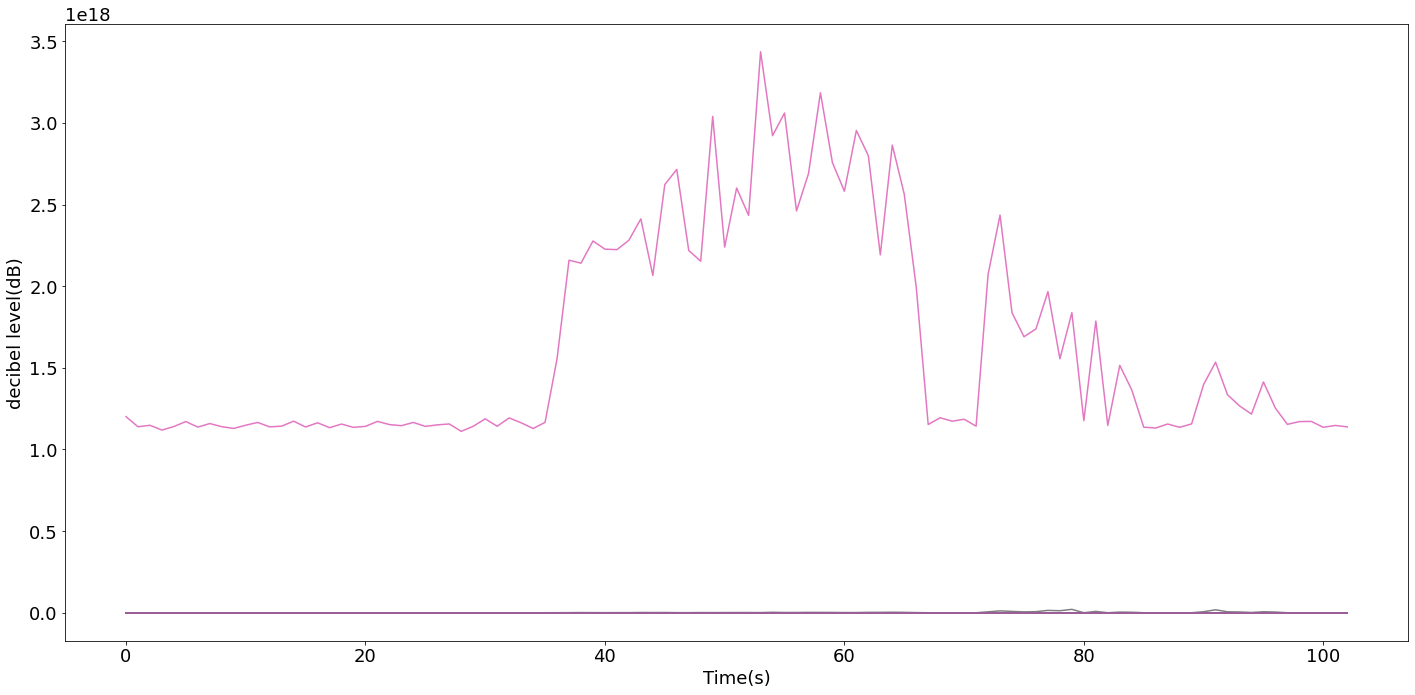

In [11]:
from scipy.io.wavfile import read
samprate, wavdata = read('0606_exp_activtype.wav')
import numpy as np
import math
import statistics 
# import pyaudio
import time
from math import log10
import audioop  
# basically taking a reading every half a second - the size of the data 
# divided by the sample rate gives us 1 second chunks so I chop 
# sample rate in half for half second chunks
dbs2 = []
WIDTH = 2

chunks = np.array_split(wavdata, 103)
for chunk in chunks:
    print (chunk.shape)
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs2.append(a)
# print(dbs)
x = range(0,11600)
plt.plot(dbs2)
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_activtype.png")
print(len(dbs2))

210
(288302,)
zcr 5851
[-152. -180. -210. ...  -98. -124. -147.]
4510784780712634.0
721
Maximum power is 4510784780712634.0 at frequency 120.040790559899
Power at first harmonic is 89249280771257.23 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.8834009366656424e+16
Energy in 1 kHz - 8 kHz 1278929824237204.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.82156867575691


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5900
[-137.  -99.  -68. ...  857.  875.  969.]
4607608041828092.0
721
Maximum power is 4607608041828092.0 at frequency 120.040790559899
Power at first harmonic is 33546153966762.316 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.265509821193741e+16
Energy in 1 kHz - 8 kHz 910297025059291.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.82929031637387


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5478
[  861.   695.   793. ...  -914. -1274. -1529.]
5190198509155697.0
721
Maximum power is 5190198509155697.0 at frequency 120.040790559899
Power at first harmonic is 215716589501822.03 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.950148155596477e+16
Energy in 1 kHz - 8 kHz 880990939339731.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.89012071798768


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5633
[-1640. -1759. -1964. ...  -534.  -569.  -556.]
4347405741507080.5
721
Maximum power is 4347405741507080.5 at frequency 120.040790559899
Power at first harmonic is 11547424495358.2 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.945596514610558e+16
Energy in 1 kHz - 8 kHz 1752975156547444.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.62176240015969


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5329
[-485. -363. -260. ... -396. -426. -450.]
4409429243650016.5
721
Maximum power is 4409429243650016.5 at frequency 120.040790559899
Power at first harmonic is 65346798004939.11 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 5.839010017826997e+16
Energy in 1 kHz - 8 kHz 1190496850340568.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.04683297697611
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6688
[-471. -481. -500. ...  464.  441.  388.]
4362737129772766.0
721
Maximum power is 4362737129772766.0 at frequency 120.040790559899
Power at first harmonic is 76414622162404.6 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.880481798261242e+16
Energy in 1 kHz - 8 kHz 2492545970253425.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.6401186424524
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6375
[ 384.  447.  530. ... 1771. 1832. 1922.]
4637297259264121.0
721
Maximum power is 4637297259264121.0 at frequency 120.040790559899
Power at first harmonic is 11628398664075.871 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.6279669658558435e+17
Energy in 1 kHz - 8 kHz 2804159142018016.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.055441342900224
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6049
[1977. 1970. 1933. ...  733.  788.  879.]
4537042071583505.0
721
Maximum power is 4537042071583505.0 at frequency 120.040790559899
Power at first harmonic is 17528681198801.43 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 8.305827985615854e+16
Energy in 1 kHz - 8 kHz 1440770465443510.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.64851643498316
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6407
[ 986. 1101. 1187. ... 1679. 1673. 1670.]
4272286645021923.0
721
Maximum power is 4272286645021923.0 at frequency 120.040790559899
Power at first harmonic is 29332230171649.992 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.103690297127242e+16
Energy in 1 kHz - 8 kHz 1548379936277261.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.794938398743774
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6056
[1652. 1647. 1641. ... -182. -169. -169.]
4658203460069147.0
721
Maximum power is 4658203460069147.0 at frequency 120.040790559899
Power at first harmonic is 37247777722270.82 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.282442190536986e+16
Energy in 1 kHz - 8 kHz 3654723665063359.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.398478903537193
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7284
[-172. -147. -109. ... -219.   47.  610.]
4120769098541778.0
721
Maximum power is 4120769098541778.0 at frequency 120.040790559899
Power at first harmonic is 12777316602089.107 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.019335134405859e+17
Energy in 1 kHz - 8 kHz 2425428142474583.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.02701851087889
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6094
[  663.   454.   544. ... -3062. -3186. -3298.]
4426885801681076.5
721
Maximum power is 4426885801681076.5 at frequency 120.040790559899
Power at first harmonic is 80877682248971.0 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.0312490975876792e+17
Energy in 1 kHz - 8 kHz 1539594369857168.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.98186988585512
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5299
[-3363. -3383. -3369. ...  -633.  -606.  -573.]
4129178307338593.0
721
Maximum power is 4129178307338593.0 at frequency 120.040790559899
Power at first harmonic is 4142086896371.0195 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.0425774272511498e+17
Energy in 1 kHz - 8 kHz 2372583800832731.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.942701913636306
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5875
[ -532.  -495.  -451. ... -1830. -1866. -1879.]
4027035926525786.0
721
Maximum power is 4027035926525786.0 at frequency 120.040790559899
Power at first harmonic is 9374936380490.195 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.255897018904637e+16
Energy in 1 kHz - 8 kHz 2189312481443811.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.277642398496454
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6020
[-1864. -1832. -1768. ...   652.   643.   658.]
3730515416514027.5
721
Maximum power is 3730515416514027.5 at frequency 120.040790559899
Power at first harmonic is 845964915498.7373 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 7.266660740288286e+16
Energy in 1 kHz - 8 kHz 1459262924285277.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.79678863455931
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6557
[689. 723. 758. ... 817. 754. 795.]
3596118920139142.5
721
Maximum power is 3596118920139142.5 at frequency 120.040790559899
Power at first harmonic is 1507790028031.8108 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.2686257615369238e+17
Energy in 1 kHz - 8 kHz 3105652537904371.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.84892775522679


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6112
[ 853.  815.  737. ... -176. -150. -132.]
3192056014537292.5
721
Maximum power is 3192056014537292.5 at frequency 120.040790559899
Power at first harmonic is 16530370106860.027 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 8.907064788964629e+16
Energy in 1 kHz - 8 kHz 1336663767439809.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.63653946440739
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5664
[-131. -140. -130. ... 1956. 1917. 1876.]
2985201775763889.5
721
Maximum power is 2985201775763889.5 at frequency 120.040790559899
Power at first harmonic is 24153576346170.348 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.491854802103855e+17
Energy in 1 kHz - 8 kHz 2006861330522156.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.33771229802389
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5795
[1815. 1747. 1675. ... 1847. 1911. 1975.]
3644923408534590.0
721
Maximum power is 3644923408534590.0 at frequency 120.040790559899
Power at first harmonic is 75028158182969.88 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.0884005105665141e+17
Energy in 1 kHz - 8 kHz 3899882219036865.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.908548244190587
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5867
[2040. 2062. 1997. ...  268.  318.  390.]
3130599750464734.0
721
Maximum power is 3130599750464734.0 at frequency 120.040790559899
Power at first harmonic is 1651978688772.6199 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.611182943995229e+16
Energy in 1 kHz - 8 kHz 3850698634068681.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.959582292317613
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5451
[459. 531. 560. ... 502. 387. 289.]
2996564491522851.0
721
Maximum power is 2996564491522851.0 at frequency 120.040790559899
Power at first harmonic is 51159871053822.82 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.0418041963690784e+17
Energy in 1 kHz - 8 kHz 3749803221569526.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.78290312346093
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 4879
[ 194.  108.   58. ... 8618. 8605. 8355.]
2648893778831504.0
721
Maximum power is 2648893778831504.0 at frequency 120.040790559899
Power at first harmonic is 73193382428062.06 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.333020944727432e+16
Energy in 1 kHz - 8 kHz 2078213946928562.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.90885531069073
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6595
[7983. 7644. 7308. ... 1620. 1623. 1627.]
3382195105394591.5
721
Maximum power is 3382195105394591.5 at frequency 120.040790559899
Power at first harmonic is 22590379658212.094 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.3713265395595611e+17
Energy in 1 kHz - 8 kHz 6443135077184104.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.283529262262235


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6089
[1667. 1675. 1625. ...  439.  396.  351.]
3577851922980969.0
721
Maximum power is 3577851922980969.0 at frequency 120.040790559899
Power at first harmonic is 13900710242742.498 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.4286807098805931e+17
Energy in 1 kHz - 8 kHz 3127548978818094.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.68052233735102
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5370
[ 300.  210.   98. ... -886. -800. -727.]
3940264159179830.5
721
Maximum power is 3940264159179830.5 at frequency 120.040790559899
Power at first harmonic is 55664839521102.53 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.4211047670106474e+17
Energy in 1 kHz - 8 kHz 2706931913975318.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.49872594407652
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5482
[-663. -580. -511. ...  736.  765.  789.]
3505327061282779.5
721
Maximum power is 3505327061282779.5 at frequency 120.040790559899
Power at first harmonic is 9492633561440.805 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.626035550684867e+16
Energy in 1 kHz - 8 kHz 2504888099806998.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.42900427937901
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5219
[869. 935. 924. ... 111. 147. 183.]
3620939235905482.0
721
Maximum power is 3620939235905482.0 at frequency 120.040790559899
Power at first harmonic is 73872779212463.83 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.38487322395466e+17
Energy in 1 kHz - 8 kHz 7085868083159762.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.544157578179345
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5991
[217. 249. 295. ... 541. 534. 532.]
3270646144339439.5
721
Maximum power is 3270646144339439.5 at frequency 120.040790559899
Power at first harmonic is 8813547022751.39 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 8.66637995046309e+16
Energy in 1 kHz - 8 kHz 1721693958614317.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.33635569841989
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5819
[530. 528. 511. ... 811. 666. 516.]
3209603516639457.0
721
Maximum power is 3209603516639457.0 at frequency 120.040790559899
Power at first harmonic is 816170201816.1687 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.4608314204033264e+17
Energy in 1 kHz - 8 kHz 3807980611596720.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.362364975140636
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5729
[ 456.  409.  352. ... 1799. 1807. 1826.]
3406159562747612.5
721
Maximum power is 3406159562747612.5 at frequency 120.040790559899
Power at first harmonic is 39604365992915.97 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.279444565154374e+16
Energy in 1 kHz - 8 kHz 1312940379363959.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.67681603066931
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6107
[1853. 1895. 1922. ... 2008. 1965. 1899.]
3594676561267621.0
721
Maximum power is 3594676561267621.0 at frequency 120.040790559899
Power at first harmonic is 17681923393720.4 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.2397198438833824e+17
Energy in 1 kHz - 8 kHz 3666284393840819.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.814066523755
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6139
[1838. 1809. 1784. ...  976. 1007. 1034.]
3740720856673902.0
721
Maximum power is 3740720856673902.0 at frequency 120.040790559899
Power at first harmonic is 154496981649346.3 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.2489294474755278e+17
Energy in 1 kHz - 8 kHz 4254414463306092.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.356083151921887
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6500
[1055. 1070. 1105. ... -613. -630. -667.]
4542726350241458.0
721
Maximum power is 4542726350241458.0 at frequency 120.040790559899
Power at first harmonic is 113916675540025.0 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.2172463779514762e+17
Energy in 1 kHz - 8 kHz 2150691183361439.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.59791546868999
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5806
[-636. -565. -537. ...   29.   44.   85.]
4305455052796825.0
721
Maximum power is 4305455052796825.0 at frequency 120.040790559899
Power at first harmonic is 54147717680446.55 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.255178415332486e+16
Energy in 1 kHz - 8 kHz 2063141583515344.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.85963779355744
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5373
[166. 259. 346. ... -27.   0.   0.]
4384677853890226.5
721
Maximum power is 4384677853890226.5 at frequency 120.040790559899
Power at first harmonic is 14374592673139.105 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.1541270665050242e+17
Energy in 1 kHz - 8 kHz 2393273677139758.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.22378140574132
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5635
[ -13.  -13.  -12. ... -652. -638. -584.]
3995788985329590.0
721
Maximum power is 3995788985329590.0 at frequency 120.040790559899
Power at first harmonic is 17570903906374.71 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.1107729514247523e+17
Energy in 1 kHz - 8 kHz 1782410366527491.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.318586801577595


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5772
[-549. -526. -519. ... 1224. 1444. 1636.]
3787703325700291.0
721
Maximum power is 3787703325700291.0 at frequency 120.040790559899
Power at first harmonic is 31883113829792.176 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.2543699998289909e+17
Energy in 1 kHz - 8 kHz 1735919974298490.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.25966740407488
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6243
[1790. 1907. 2034. ... 5662. 5626. 5550.]
3675236686698322.0
721
Maximum power is 3675236686698322.0 at frequency 120.040790559899
Power at first harmonic is 17205986622624.934 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.885539129881493e+16
Energy in 1 kHz - 8 kHz 2529839671696545.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.07575345773637
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5196
[ 5464.  5424.  5421. ... -1213.  -900.  -773.]
3776499694626445.0
721
Maximum power is 3776499694626445.0 at frequency 120.040790559899
Power at first harmonic is 38726328497575.97 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 8.424385743580762e+16
Energy in 1 kHz - 8 kHz 850462295127666.6
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.05654597322436
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5940
[-977. -897. -907. ...  844.  773.  733.]
3343477821093680.5
721
Maximum power is 3343477821093680.5 at frequency 120.040790559899
Power at first harmonic is 101754321448987.25 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.109821574669776e+17
Energy in 1 kHz - 8 kHz 1879266644816305.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.056099235894166


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5823
[711. 703. 674. ... 344. 357. 333.]
3193878090010434.0
721
Maximum power is 3193878090010434.0 at frequency 120.040790559899
Power at first harmonic is 25717609903417.02 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 9.075549735505626e+16
Energy in 1 kHz - 8 kHz 2977728544295862.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.47809630898274


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5631
[ 294.  258.  225. ... 1192. 1275. 1354.]
3648231376424561.0
721
Maximum power is 3648231376424561.0 at frequency 120.040790559899
Power at first harmonic is 99021685498534.27 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.5309935728747376e+17
Energy in 1 kHz - 8 kHz 3639832890524385.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.062194032599386


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6119
[1438. 1499. 1525. ...  689.  640.  609.]
2768251892737304.0
721
Maximum power is 2768251892737304.0 at frequency 120.040790559899
Power at first harmonic is 19510362443582.51 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 9.514151551749491e+16
Energy in 1 kHz - 8 kHz 2622177646965895.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.28339812429663
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5490
[ 604.  620.  628. ... -262. -290. -300.]
2325978217542819.5
721
Maximum power is 2325978217542819.5 at frequency 120.040790559899
Power at first harmonic is 10450034631322.395 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 8.549500694446562e+16
Energy in 1 kHz - 8 kHz 1654887022300534.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.662141156690616
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5557
[ -273.  -230.  -213. ... -1952. -1801. -1639.]
2518717859500568.0
721
Maximum power is 2518717859500568.0 at frequency 120.040790559899
Power at first harmonic is 28131781388788.75 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.0311535613969621e+17
Energy in 1 kHz - 8 kHz 3058607737914327.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.713167877490186
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5885
[-1439. -1229. -1052. ...  -263.  -167.   -85.]
2259344430687819.0
721
Maximum power is 2259344430687819.0 at frequency 120.040790559899
Power at first harmonic is 28510296592122.387 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.1326643875850032e+17
Energy in 1 kHz - 8 kHz 1738742029481348.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.14275081524698


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6128
[    4.   125.   255. ... -2208. -2193. -2123.]
2438245782389375.5
721
Maximum power is 2438245782389375.5 at frequency 120.040790559899
Power at first harmonic is 59367565424956.43 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.0108887947538917e+17
Energy in 1 kHz - 8 kHz 2351490239370557.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.989283043951076


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5480
[-2058. -1997. -1918. ...  3498.  3424.  3333.]
2344107748718652.0
721
Maximum power is 2344107748718652.0 at frequency 120.040790559899
Power at first harmonic is 33449108739277.594 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.1493265426285432e+17
Energy in 1 kHz - 8 kHz 1987581352907837.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.82538364767183


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5487
[3201. 3009. 2758. ... 1366. 1351. 1338.]
1975991842619341.8
721
Maximum power is 1975991842619341.8 at frequency 120.040790559899
Power at first harmonic is 1468866893425.3286 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 8.626689840452502e+16
Energy in 1 kHz - 8 kHz 1509860953483307.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.13565756204502
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5713
[1323. 1296. 1262. ...  682.  692.  695.]
2179444404843363.5
721
Maximum power is 2179444404843363.5 at frequency 120.040790559899
Power at first harmonic is 8833050329447.01 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.0133268931304021e+17
Energy in 1 kHz - 8 kHz 1730550185213560.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.55518677173475
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5403
[ 694.  711.  745. ... 1523. 1174.  814.]
2107839107225344.8
721
Maximum power is 2107839107225344.8 at frequency 120.040790559899
Power at first harmonic is 342858815402.9513 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.4384648409477066e+17
Energy in 1 kHz - 8 kHz 4684689483632005.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.70566034256075
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5707
[ 461.  129. -178. ...  603.  626.  664.]
2102735227720436.8
721
Maximum power is 2102735227720436.8 at frequency 120.040790559899
Power at first harmonic is 21022507129409.75 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.1956135613214584e+17
Energy in 1 kHz - 8 kHz 3152048058140076.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.931323992152336
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5782
[  715.   745.   768. ... -1784. -1911. -2066.]
2611575800572467.0
721
Maximum power is 2611575800572467.0 at frequency 120.040790559899
Power at first harmonic is 17936882386892.8 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.0624971777875982e+17
Energy in 1 kHz - 8 kHz 3665069107938022.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.98982656251636
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 4541
[-2221. -2346. -2459. ...  -725.  -678.  -610.]
3082092953114090.0
721
Maximum power is 3082092953114090.0 at frequency 120.040790559899
Power at first harmonic is 653336866864.6908 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 5.201298298541358e+16
Energy in 1 kHz - 8 kHz 1567368761159059.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.18490471058663
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 4428
[-514. -418. -334. ... 1488. 1475. 1496.]
3015576850036232.0
721
Maximum power is 3015576850036232.0 at frequency 120.040790559899
Power at first harmonic is 27981354995749.46 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 8.85694698669231e+16
Energy in 1 kHz - 8 kHz 828051054277226.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.96136356499407
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3713
[1523. 1525. 1518. ...  744.  697.  632.]
2716775211163335.0
721
Maximum power is 2716775211163335.0 at frequency 120.040790559899
Power at first harmonic is 10128118513228.506 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.180205180626179e+16
Energy in 1 kHz - 8 kHz 369966180797646.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.95934833204657
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3624
[  575.   531.   528. ... -1536. -1585. -1641.]
2731693643098766.5
721
Maximum power is 2731693643098766.5 at frequency 120.040790559899
Power at first harmonic is 3749874888215.8564 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.313864086340982e+16
Energy in 1 kHz - 8 kHz 353192954715298.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.82588305058982
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3428
[-1696. -1725. -1753. ...    78.    89.   122.]
2483120979556301.0
721
Maximum power is 2483120979556301.0 at frequency 120.040790559899
Power at first harmonic is 177681036724.38107 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.5504985035636572e+16
Energy in 1 kHz - 8 kHz 338180321836003.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.98832351592081


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3604
[ 163.  175.  155. ... -703. -756. -816.]
2727721462172980.0
721
Maximum power is 2727721462172980.0 at frequency 120.040790559899
Power at first harmonic is 7193502238762.921 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.2388539519744484e+16
Energy in 1 kHz - 8 kHz 342233966420161.06
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.63858850287535


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3667
[ -867.  -917.  -974. ... -1009.  -988.  -974.]
1931699171853735.0
721
Maximum power is 1931699171853735.0 at frequency 120.040790559899
Power at first harmonic is 3765245708744.0947 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.203611051191273e+16
Energy in 1 kHz - 8 kHz 360854962489004.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.778356520146


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3515
[ -989. -1028. -1052. ...  -948.  -950.  -971.]
2048933333272914.8
721
Maximum power is 2048933333272914.8 at frequency 120.040790559899
Power at first harmonic is 164100598104.4891 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.5726671393529828e+16
Energy in 1 kHz - 8 kHz 365397932091710.06
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.7746950810956


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3740
[-1005. -1025. -1021. ...  1179.  1185.  1152.]
1701184225443480.2
721
Maximum power is 1701184225443480.2 at frequency 120.040790559899
Power at first harmonic is 16960075393182.27 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.2741623569847164e+16
Energy in 1 kHz - 8 kHz 366260060698750.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.39446880280289
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6904
[1117. 1090. 1077. ... -121. -358. -316.]
2334354207759356.5
721
Maximum power is 2334354207759356.5 at frequency 120.040790559899
Power at first harmonic is 3192939986524.0215 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.5700764128484797e+17
Energy in 1 kHz - 8 kHz 6787148156789382.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.133080000292708
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6695
[ -147.  -237.  -538. ... -1489. -1459. -1457.]
2697699994368634.5
721
Maximum power is 2697699994368634.5 at frequency 120.040790559899
Power at first harmonic is 119006921374404.48 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.706578605442073e+17
Energy in 1 kHz - 8 kHz 6401971983070305.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.657077068675633
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7983
[-1454. -1430. -1396. ... -1917. -1878. -1824.]
3254994038222953.5
721
Maximum power is 3254994038222953.5 at frequency 120.040790559899
Power at first harmonic is 66681563415896.49 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.9395766842486672e+17
Energy in 1 kHz - 8 kHz 1.9977346206761292e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.70888056989382
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6678
[-1727. -1584. -1457. ...   715.   665.   607.]
3710112647591252.0
721
Maximum power is 3710112647591252.0 at frequency 120.040790559899
Power at first harmonic is 29622494954092.836 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.0612970728181498e+17
Energy in 1 kHz - 8 kHz 4519106190308099.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.612937293638076
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6833
[574. 558. 513. ... 443. 420. 400.]
3544278778668690.0
721
Maximum power is 3544278778668690.0 at frequency 120.040790559899
Power at first harmonic is 24333406083022.984 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.0940279988690317e+17
Energy in 1 kHz - 8 kHz 1.9926168633486812e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.508934443874598
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7611
[371. 333. 274. ... 708. 724. 729.]
3592262239970883.5
721
Maximum power is 3592262239970883.5 at frequency 120.040790559899
Power at first harmonic is 113856059301418.7 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.2848900948324493e+17
Energy in 1 kHz - 8 kHz 1.1201819212196342e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.397491260568653
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7705
[ 730.  749.  801. ... 2143. 2191. 2224.]
3565036592005284.0
721
Maximum power is 3565036592005284.0 at frequency 120.040790559899
Power at first harmonic is 16641854639722.508 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.3014192392192934e+17
Energy in 1 kHz - 8 kHz 1.7211467551760182e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.371429439693141
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7821
[2260. 2296. 2313. ... 2542. 2507. 2436.]
3173059183154093.5
721
Maximum power is 3173059183154093.5 at frequency 120.040790559899
Power at first harmonic is 62949208132568.67 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.3813933604891302e+17
Energy in 1 kHz - 8 kHz 9782848241622604.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.34253605567684
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6451
[2375. 2358. 2340. ... 1694. 1714. 1725.]
3084430614840929.5
721
Maximum power is 3084430614840929.5 at frequency 120.040790559899
Power at first harmonic is 42045622790220.75 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.1379662134830022e+17
Energy in 1 kHz - 8 kHz 1.8086454462191616e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.82081439981651
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6742
[ 1722.  1707.  1691. ... -1805. -1849. -1886.]
3404259403043788.0
721
Maximum power is 3404259403043788.0 at frequency 120.040790559899
Power at first harmonic is 48242702377649.555 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.2790154876901942e+17
Energy in 1 kHz - 8 kHz 7006759274190296.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.525956701339055
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5940
[-1919. -1946. -1926. ...   523.   406.   363.]
3723387046807084.5
721
Maximum power is 3723387046807084.5 at frequency 120.040790559899
Power at first harmonic is 63995700595070.95 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.1454828326491354e+17
Energy in 1 kHz - 8 kHz 4475266268612227.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.94089790135428
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6604
[ 318.  241.  178. ... -596. -411. -158.]
3086773524919111.0
721
Maximum power is 3086773524919111.0 at frequency 120.040790559899
Power at first harmonic is 39464143291181.48 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.484318876431947e+17
Energy in 1 kHz - 8 kHz 1.1223895140983576e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.224632427400534
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5549
[ 123.  420.  769. ... 2315. 2667. 3063.]
3365923325952274.0
721
Maximum power is 3365923325952274.0 at frequency 120.040790559899
Power at first harmonic is 69442061188795.9 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.358558558686727e+17
Energy in 1 kHz - 8 kHz 5902733887395223.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.015751423045025
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6827
[3461. 3834. 4188. ... 1314. 1142.  933.]
3721354672721137.0
721
Maximum power is 3721354672721137.0 at frequency 120.040790559899
Power at first harmonic is 100012849270615.45 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.7482330510778605e+17
Energy in 1 kHz - 8 kHz 8779051482388325.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.913689475280954
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6187
[673. 375.  65. ... 364. 300. 264.]
3888412890119091.0
721
Maximum power is 3888412890119091.0 at frequency 120.040790559899
Power at first harmonic is 32687331490478.867 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.9321154447415296e+17
Energy in 1 kHz - 8 kHz 1.023373835171492e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.65145994523282
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7364
[267. 274. 264. ... 100.  32. -42.]
4673370884386928.0
721
Maximum power is 4673370884386928.0 at frequency 120.040790559899
Power at first harmonic is 156940184622753.62 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.587829567529473e+17
Energy in 1 kHz - 8 kHz 9311132804957176.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.79285422877582
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6068
[-137. -232. -329. ... -169.  174.  493.]
4209652801923247.5
721
Maximum power is 4209652801923247.5 at frequency 120.040790559899
Power at first harmonic is 49370804944614.266 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.5864200199610077e+17
Energy in 1 kHz - 8 kHz 1.150472727672643e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.481367508756374
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6803
[ 844. 1160. 1442. ... 2882. 3022. 3185.]
4014320596454842.5
721
Maximum power is 4014320596454842.5 at frequency 120.040790559899
Power at first harmonic is 32053181974748.79 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.7580841667526157e+17
Energy in 1 kHz - 8 kHz 5320950221537837.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.040793346202406
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7113
[3345. 3456. 3495. ... 1622. 1439. 1275.]
4325821205211198.0
721
Maximum power is 4325821205211198.0 at frequency 120.040790559899
Power at first harmonic is 392256555221.96 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.794887054936961e+17
Energy in 1 kHz - 8 kHz 1.2249166993826174e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.653135644583996
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6576
[ 1095.   878.   666. ... -1104. -1089. -1087.]
4129799992483575.0
721
Maximum power is 4129799992483575.0 at frequency 120.040790559899
Power at first harmonic is 74314825159536.1 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.370374400450946e+17
Energy in 1 kHz - 8 kHz 8745045189229383.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.105341929740494
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7839
[-1083. -1067. -1032. ... -1466. -1522. -1584.]
4166063005887081.5
721
Maximum power is 4166063005887081.5 at frequency 120.040790559899
Power at first harmonic is 10299853665857.107 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.6237172316720976e+17
Energy in 1 kHz - 8 kHz 6474237775330098.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.079666333220363
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7300
[-1617. -1645. -1701. ...  1804.  1795.  1798.]
3868183958804303.0
721
Maximum power is 3868183958804303.0 at frequency 120.040790559899
Power at first harmonic is 250744915217309.97 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.3251285361264227e+17
Energy in 1 kHz - 8 kHz 9025038235524256.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.763087927697384
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6593
[1832. 1890. 1946. ... -806. -168.  546.]
3772041709408353.0
721
Maximum power is 3772041709408353.0 at frequency 120.040790559899
Power at first harmonic is 39881108576382.65 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.615913059865998e+17
Energy in 1 kHz - 8 kHz 7313776455506763.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.094099671987216
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6830
[1335. 2191. 3041. ... -381. -409. -414.]
4235329231742435.5
721
Maximum power is 4235329231742435.5 at frequency 120.040790559899
Power at first harmonic is 44504838104786.53 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.3867840731883845e+17
Energy in 1 kHz - 8 kHz 4817326653228504.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.787420347735427
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6841
[-401. -367. -368. ... -167. -180. -188.]
4027038114981680.5
721
Maximum power is 4027038114981680.5 at frequency 120.040790559899
Power at first harmonic is 6865815273763.003 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.138416475864837e+17
Energy in 1 kHz - 8 kHz 6830243936561208.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.308054232415248
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7068
[-209. -216. -265. ... 1396. 1422. 1423.]
4254358179615929.0
721
Maximum power is 4254358179615929.0 at frequency 120.040790559899
Power at first harmonic is 6694660354624.529 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.6100022181963094e+17
Energy in 1 kHz - 8 kHz 6095570657775245.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.41265779017196
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6897
[1446. 1500. 1560. ...  745.  625.  498.]
3534851399825430.0
721
Maximum power is 3534851399825430.0 at frequency 120.040790559899
Power at first harmonic is 75531016440862.81 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.3977089040695946e+17
Energy in 1 kHz - 8 kHz 6150388251982684.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.725539377437173
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7228
[  649.   734.   435. ...  -939.  -967. -1003.]
3693250979652535.0
721
Maximum power is 3693250979652535.0 at frequency 120.040790559899
Power at first harmonic is 35232666312461.375 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.7781690106480304e+17
Energy in 1 kHz - 8 kHz 7406754643607281.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.007397250329547
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6149
[-1023. -1023. -1015. ...  -492.  -509.  -546.]
3503701853717212.0
721
Maximum power is 3503701853717212.0 at frequency 120.040790559899
Power at first harmonic is 11688849108576.104 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.526320612112844e+17
Energy in 1 kHz - 8 kHz 1.5777032636047658e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.67431992645739
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7237
[-594. -690. -790. ... -450. -491. -521.]
3160031586922346.5
721
Maximum power is 3160031586922346.5 at frequency 120.040790559899
Power at first harmonic is 47057169464979.88 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.347116774391256e+17
Energy in 1 kHz - 8 kHz 8010952016658958.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.298849493922482


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6276
[-549. -610. -711. ... 3824. 4150. 4249.]
2529550734006007.0
721
Maximum power is 2529550734006007.0 at frequency 120.040790559899
Power at first harmonic is 27859169840572.965 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.6384335903242413e+17
Energy in 1 kHz - 8 kHz 6986873511041799.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.450168200911623


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6520
[4248. 4303. 4226. ...  595.  269.  -52.]
2485643968294650.0
721
Maximum power is 2485643968294650.0 at frequency 120.040790559899
Power at first harmonic is 31110130760727.094 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.1544636996249302e+17
Energy in 1 kHz - 8 kHz 5161619656287194.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.740070812862996
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6876
[ -380.  -727. -1086. ...  4901.  4466.  4058.]
2451929292510674.5
721
Maximum power is 2451929292510674.5 at frequency 120.040790559899
Power at first harmonic is 11365055495162.158 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.0936850746533482e+17
Energy in 1 kHz - 8 kHz 5960226420663908.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.12760970614491
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7213
[3670. 3226. 2745. ... 2030. 2067. 2134.]
2570917048446610.5
721
Maximum power is 2570917048446610.5 at frequency 120.040790559899
Power at first harmonic is 32541454386825.03 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.2499568703882147e+17
Energy in 1 kHz - 8 kHz 6912347607962905.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.549822404711
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6824
[ 2201.  2245.  2260. ... -2732. -3064. -3373.]
2868195823901552.5
721
Maximum power is 2868195823901552.5 at frequency 120.040790559899
Power at first harmonic is 44949985670172.08 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.9479505745946915e+17
Energy in 1 kHz - 8 kHz 5439759931363398.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.80949525664941
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6962
[-3656. -3909. -4157. ...  5069.  5271.  5382.]
3442275837043012.0
721
Maximum power is 3442275837043012.0 at frequency 120.040790559899
Power at first harmonic is 62194296664779.016 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.018522837965651e+17
Energy in 1 kHz - 8 kHz 1.451574176765558e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.905750531215602
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6324
[ 5333.  5048.  4670. ... -3490. -3420. -3236.]
3794391380651483.5
721
Maximum power is 3794391380651483.5 at frequency 120.040790559899
Power at first harmonic is 96659853546959.64 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.0582748792743926e+17
Energy in 1 kHz - 8 kHz 7206871707717011.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.55989342880105
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7114
[-2940. -2498. -1873. ...   -76.    70.   213.]
3314346640337862.5
721
Maximum power is 3314346640337862.5 at frequency 120.040790559899
Power at first harmonic is 20554775518373.547 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.153676211526695e+17
Energy in 1 kHz - 8 kHz 1.617668102476572e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.313461569956905
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6302
[ 354.  507.  672. ... -436. -474. -540.]
3611059936143635.5
721
Maximum power is 3611059936143635.5 at frequency 120.040790559899
Power at first harmonic is 58378176485277.47 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.6180974354238166e+17
Energy in 1 kHz - 8 kHz 8422046715092626.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.212639043240223
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6704
[-605. -652. -660. ...  444.  403.  387.]
3296934900059141.5
721
Maximum power is 3296934900059141.5 at frequency 120.040790559899
Power at first harmonic is 42670687938807.484 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.5178174677588915e+17
Energy in 1 kHz - 8 kHz 4794515444360137.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.657369454181733
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6299
[402. 410. 414. ... 589. 572. 439.]
3743393958653727.0
721
Maximum power is 3743393958653727.0 at frequency 120.040790559899
Power at first harmonic is 51376009072208.266 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.7829535016478966e+17
Energy in 1 kHz - 8 kHz 4317928437175878.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.2918724242227
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6890
[ 343.  380.  478. ... -468. -422. -380.]
3669633840340661.0
721
Maximum power is 3669633840340661.0 at frequency 120.040790559899
Power at first harmonic is 9769154255724.58 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.480499028807442e+17
Energy in 1 kHz - 8 kHz 3497442492616081.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.33090413732668
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6109
[ -397.  -401.  -337. ... -1764. -1697. -1611.]
3580950010516102.0
721
Maximum power is 3580950010516102.0 at frequency 120.040790559899
Power at first harmonic is 15457500746263.78 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.8664738832041606e+17
Energy in 1 kHz - 8 kHz 6510284940868058.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.669618920785542
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7371
[-1530. -1434. -1318. ...   210.  -145.  -471.]
3005188067267379.5
721
Maximum power is 3005188067267379.5 at frequency 120.040790559899
Power at first harmonic is 5594538725526.517 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.3471311884113574e+17
Energy in 1 kHz - 8 kHz 1.435468255366498e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.350979407845543
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6645
[ -767. -1055. -1366. ... -4072. -4080. -4063.]
3300539110720768.0
721
Maximum power is 3300539110720768.0 at frequency 120.040790559899
Power at first harmonic is 68519789498484.88 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.6125313293990618e+17
Energy in 1 kHz - 8 kHz 7075237235834553.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.92499971827309
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6296
[-4039. -4012. -4001. ...   533.   575.   610.]
3383059559411375.0
721
Maximum power is 3383059559411375.0 at frequency 120.040790559899
Power at first harmonic is 26571118093196.746 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.8375235454341792e+17
Energy in 1 kHz - 8 kHz 8530531584510580.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.540551456027497
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7175
[610. 581. 555. ... -36.   2.  15.]
3236111673601566.0
721
Maximum power is 3236111673601566.0 at frequency 120.040790559899
Power at first harmonic is 8590731869142.138 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.652903846228403e+17
Energy in 1 kHz - 8 kHz 8774796049617021.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.83694888043061
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6606
[  47.  157.  337. ... -306. -239. -184.]
3819284868838475.5
721
Maximum power is 3819284868838475.5 at frequency 120.040790559899
Power at first harmonic is 5078836961860.976 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.0506058905021446e+17
Energy in 1 kHz - 8 kHz 6324227875243223.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.42460472573153
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6388
[-141. -111.  -72. ...  278.  252.  207.]
3370648096134107.0
721
Maximum power is 3370648096134107.0 at frequency 120.040790559899
Power at first harmonic is 69195986267428.67 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.4785073975146352e+17
Energy in 1 kHz - 8 kHz 9964165465497260.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.874209547171
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7019
[170. 147. 129. ... 344. 277. 202.]
2963823905775751.0
721
Maximum power is 2963823905775751.0 at frequency 120.040790559899
Power at first harmonic is 16034506014337.277 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.439485197087241e+17
Energy in 1 kHz - 8 kHz 8178316394268269.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.828696757158255
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5885
[171. 168. 170. ... 902. 918. 930.]
2871730182412213.0
721
Maximum power is 2871730182412213.0 at frequency 120.040790559899
Power at first harmonic is 5479369940096.442 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.263087474594517e+17
Energy in 1 kHz - 8 kHz 4605383516382344.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.426325518850753
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7715
[962. 979. 980. ... 229. 334. 430.]
2616044126738377.5
721
Maximum power is 2616044126738377.5 at frequency 120.040790559899
Power at first harmonic is 25869672096648.92 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.5963657476560813e+17
Energy in 1 kHz - 8 kHz 7792139843504676.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.32031765087409
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6350
[  501.   570.   639. ... -1468. -1501. -1549.]
2403110338615908.5
721
Maximum power is 2403110338615908.5 at frequency 120.040790559899
Power at first harmonic is 3059131148987.698 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.951590732547756e+17
Energy in 1 kHz - 8 kHz 8199225326664878.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.80213562616636
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7251
[-1588. -1592. -1573. ... -4104. -4239. -4309.]
2242587366319252.0
721
Maximum power is 2242587366319252.0 at frequency 120.040790559899
Power at first harmonic is 6513036189206.996 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.038545644686363e+17
Energy in 1 kHz - 8 kHz 5444618479403397.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.441478266990345
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6347
[-4319. -4305. -4265. ...  -604.  -502.  -374.]
2585069225077465.0
721
Maximum power is 2585069225077465.0 at frequency 120.040790559899
Power at first harmonic is 38777049822650.29 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.7643734383171766e+17
Energy in 1 kHz - 8 kHz 8213398702827762.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.65687626202099
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6332
[-223.  -63.  118. ... 6297. 6597. 6893.]
2584769556284084.5
721
Maximum power is 2584769556284084.5 at frequency 120.040790559899
Power at first harmonic is 18481789882315.727 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.1899091953919043e+17
Energy in 1 kHz - 8 kHz 5130244509722265.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.686253866493765
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6477
[7231. 7550. 7811. ...  645.  657.  659.]
3365314286829298.0
721
Maximum power is 3365314286829298.0 at frequency 120.040790559899
Power at first harmonic is 37965241267885.49 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.672274349551999e+17
Energy in 1 kHz - 8 kHz 8114937155224000.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.60736044610611
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6559
[ 659.  650.  639. ... 2512. 2535. 2549.]
2916560576113922.5
721
Maximum power is 2916560576113922.5 at frequency 120.040790559899
Power at first harmonic is 46112167935473.875 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.115007622974276e+17
Energy in 1 kHz - 8 kHz 6712219959703471.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.50980801689508
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6055
[2558. 2555. 2524. ... 1814. 1826. 1844.]
3369859414979855.5
721
Maximum power is 3369859414979855.5 at frequency 120.040790559899
Power at first harmonic is 36359635366798.375 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.4333988356850584e+17
Energy in 1 kHz - 8 kHz 3232763739075682.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.339733781315495
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5597
[1863. 1864. 1827. ... 3147. 2825. 2500.]
3502089581767667.0
721
Maximum power is 3502089581767667.0 at frequency 120.040790559899
Power at first harmonic is 91384020058114.75 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.7989845769475488e+17
Energy in 1 kHz - 8 kHz 8115998619758843.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.165905407719297
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6995
[2173. 1826. 1450. ... 1310. 1325. 1330.]
3196621487354618.5
721
Maximum power is 3196621487354618.5 at frequency 120.040790559899
Power at first harmonic is 56333906102518.35 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.7194786492465178e+17
Energy in 1 kHz - 8 kHz 6603820023031902.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.03763644753423
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7456
[1369. 1421. 1423. ... -436. -551. -678.]
3283020380698238.0
721
Maximum power is 3283020380698238.0 at frequency 120.040790559899
Power at first harmonic is 44282042841782.31 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.5252184093175907e+17
Energy in 1 kHz - 8 kHz 6911451740988647.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.53672924230491
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7302
[-785. -834. -858. ... 2938. 2998. 3040.]
2813531963177052.5
721
Maximum power is 2813531963177052.5 at frequency 120.040790559899
Power at first harmonic is 6410776901050.608 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.995871189169444e+17
Energy in 1 kHz - 8 kHz 9006172441173207.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.26464387327655
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5943
[3068. 3101. 3118. ...  163.  207.  527.]
2415141255569845.5
721
Maximum power is 2415141255569845.5 at frequency 120.040790559899
Power at first harmonic is 5769816388902.431 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.1173302512617e+17
Energy in 1 kHz - 8 kHz 1.818177880090356e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.645341605170541
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7033
[ 678.  753.  770. ... 1355. 2252. 3134.]
2250061110130881.8
721
Maximum power is 2250061110130881.8 at frequency 120.040790559899
Power at first harmonic is 62669468455541.1 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.0069386125702614e+17
Energy in 1 kHz - 8 kHz 1.0424691551747118e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.251779322275585
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6416
[ 3959.  4680.  5282. ... -4004. -4369. -4708.]
1831040387624497.8
721
Maximum power is 1831040387624497.8 at frequency 120.040790559899
Power at first harmonic is 5971100882709.833 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 2.3521841175425232e+17
Energy in 1 kHz - 8 kHz 1.0362649711437514e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.69867440319206
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6615
[-5014. -5294. -5526. ... -4571. -4711. -4822.]
2361416422003166.5
721
Maximum power is 2361416422003166.5 at frequency 120.040790559899
Power at first harmonic is 67629624551385.6 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 1.9556142503252845e+17
Energy in 1 kHz - 8 kHz 1.4350605925952398e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.627398455619549
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6711
[-4910. -4990. -5072. ... -4931. -4516. -4070.]
2032661616454070.0
4239
Maximum power is 2032661616454070.0 at frequency 705.7599322932202
Power at first harmonic is 491419507053.2019 at frequency 1411.5198645864405


Energy in 0 Hz - 1 kHz 3.0634559426685325e+17
Energy in 1 kHz - 8 kHz 1.191833622993742e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.703721421900326
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 6708
[-3584. -3064. -2533. ...  1210.  1177.  1138.]
2470665741100570.5
721
Maximum power is 2470665741100570.5 at frequency 120.040790559899
Power at first harmonic is 15007057215576.867 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.6199794949099974e+17
Energy in 1 kHz - 8 kHz 6806376298662045.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.493015665693015


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 7732
[1079. 1007.  939. ... -588. -454. -308.]
2434471038044027.0
721
Maximum power is 2434471038044027.0 at frequency 120.040790559899
Power at first harmonic is 28882210721611.45 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.406058978169043e+17
Energy in 1 kHz - 8 kHz 1.4518732877052868e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.572100324070735


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 5323
[-184.  -56.   67. ... -745. -669. -593.]
2538651284155098.5
721
Maximum power is 2538651284155098.5 at frequency 120.040790559899
Power at first harmonic is 31081039543468.965 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.254300513272411e+17
Energy in 1 kHz - 8 kHz 3425309828979087.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.81303957383336


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3800
[-528. -499. -473. ...  380.  342.  290.]
2596615510956472.5
721
Maximum power is 2596615510956472.5 at frequency 120.040790559899
Power at first harmonic is 3561632411541.765 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.233914463348871e+16
Energy in 1 kHz - 8 kHz 336048093525774.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.2336798110964


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3609
[225. 181. 152. ... 805. 857. 913.]
3093063094058668.0
721
Maximum power is 3093063094058668.0 at frequency 120.040790559899
Power at first harmonic is 12007902844063.537 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.396405434670879e+16
Energy in 1 kHz - 8 kHz 329584798494235.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.05103421601783


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3699
[ 970. 1027. 1080. ...  873.  881.  873.]
3021649744781252.0
721
Maximum power is 3021649744781252.0 at frequency 120.040790559899
Power at first harmonic is 66223023649133.91 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.1918186617552772e+16
Energy in 1 kHz - 8 kHz 351526501670943.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.79880596721192
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3855
[ 821.  766.  734. ...  765.  908. 1041.]
3532309751915099.5
721
Maximum power is 3532309751915099.5 at frequency 120.040790559899
Power at first harmonic is 578681113576.3589 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.232763146613884e+16
Energy in 1 kHz - 8 kHz 354244076381048.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.25807210778905
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 4058
[ 1115.  1166.  1199. ... -2150. -2154. -2147.]
3796569382872467.5
721
Maximum power is 3796569382872467.5 at frequency 120.040790559899
Power at first harmonic is 9210048324653.266 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.2741142578138944e+16
Energy in 1 kHz - 8 kHz 395416352873872.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.80169077524849
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3733
[-2143. -2148. -2150. ...  -400.  -396.  -419.]
3788779749473113.0
721
Maximum power is 3788779749473113.0 at frequency 120.040790559899
Power at first harmonic is 16657311641950.818 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.2935963595261156e+16
Energy in 1 kHz - 8 kHz 338070553398515.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.42334333518977
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3822
[-465. -521. -587. ...  277.  261.  249.]
3445691780221707.0
721
Maximum power is 3445691780221707.0 at frequency 120.040790559899
Power at first harmonic is 367008548473.46625 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.28486913694175e+16
Energy in 1 kHz - 8 kHz 355997820814130.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.27216979670243
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3865
[ 220.  216.  248. ... 1212. 1225. 1215.]
3076806361048780.5
721
Maximum power is 3076806361048780.5 at frequency 120.040790559899
Power at first harmonic is 2046392135973.3171 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.1732964209672868e+16
Energy in 1 kHz - 8 kHz 352299892816046.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.07372655160646
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3902
[1216. 1190. 1158. ... -122. -123.  -99.]
2710947156355265.5
721
Maximum power is 2710947156355265.5 at frequency 120.040790559899
Power at first harmonic is 9653284135097.465 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.1444772585597136e+16
Energy in 1 kHz - 8 kHz 343605383180710.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.51420241009308
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3666
[-61. -29.  13. ... 259. 244. 191.]
2657339067578341.5
721
Maximum power is 2657339067578341.5 at frequency 120.040790559899
Power at first harmonic is 17266037363968.729 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.096297714346192e+16
Energy in 1 kHz - 8 kHz 333328897189106.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.89016765292853
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3901
[121.  90.  90. ... 413. 411. 408.]
2632580766342697.0
721
Maximum power is 2632580766342697.0 at frequency 120.040790559899
Power at first harmonic is 6562179641882.895 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.2056315071759028e+16
Energy in 1 kHz - 8 kHz 345870150966382.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.68309214366066
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3604
[ 381.  339.  302. ... -856. -869. -870.]
1867813494723842.2
721
Maximum power is 1867813494723842.2 at frequency 120.040790559899
Power at first harmonic is 8696875108649.585 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.218259112996992e+16
Energy in 1 kHz - 8 kHz 347343945338212.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.65338164634888
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3574
[-859. -842. -841. ...  183.  171.  179.]
2704500514818761.0
721
Maximum power is 2704500514818761.0 at frequency 120.040790559899
Power at first harmonic is 9513744486973.768 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.4433815398147852e+16
Energy in 1 kHz - 8 kHz 366403932649326.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.97774513272853
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288302,)
zcr 3797
[ 216.  269.  318. ... 2333. 2333. 2345.]
2638433117172233.0
721
Maximum power is 2638433117172233.0 at frequency 120.040790559899
Power at first harmonic is 3292473658927.681 at frequency 240.081581119798


Energy in 0 Hz - 1 kHz 3.0913777933418936e+16
Energy in 1 kHz - 8 kHz 365201694594204.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.64850626656852
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3604
[2368. 2375. 2350. ...   78.   20.  -53.]
2438033381067219.5
721
Maximum power is 2438033381067219.5 at frequency 120.04162330905307
Power at first harmonic is 5290152026442.014 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.2694324012027036e+16
Energy in 1 kHz - 8 kHz 354716243303997.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.17036047601422
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3712
[-112. -160. -216. ...  338.  349.  363.]
2910374678758851.5
721
Maximum power is 2910374678758851.5 at frequency 120.04162330905307
Power at first harmonic is 30248138696114.914 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.2882936540996252e+16
Energy in 1 kHz - 8 kHz 350318124844761.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.86592987607429
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3661
[405. 477. 536. ... 365. 312. 286.]
3330825898001340.0
721
Maximum power is 3330825898001340.0 at frequency 120.04162330905307
Power at first harmonic is 4760146762639.27 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.310539512781879e+16
Energy in 1 kHz - 8 kHz 348803076350824.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.91141957280664


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 4056
[  267.   268.   265. ... -3718. -3865. -3959.]
3218418111634847.0
721
Maximum power is 3218418111634847.0 at frequency 120.04162330905307
Power at first harmonic is 8104350946906.643 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 5.257566879303221e+16
Energy in 1 kHz - 8 kHz 802928842602120.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.47986073416637


(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6533
[-3993. -3922. -3733. ... -1061. -1042. -1046.]
3188302003077627.0
721
Maximum power is 3188302003077627.0 at frequency 120.04162330905307
Power at first harmonic is 4559717045193.773 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 7.330644974227685e+16
Energy in 1 kHz - 8 kHz 1101515946896342.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.55051154622576
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6035
[-1067. -1085. -1074. ... -1349. -1239. -1130.]
3383536708388429.5
721
Maximum power is 3383536708388429.5 at frequency 120.04162330905307
Power at first harmonic is 1423161528753.7383 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.5966205897081053e+17
Energy in 1 kHz - 8 kHz 1911946925186110.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.5075790376707
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6485
[-970. -834. -691. ... -106. -211. -115.]
2940111136165410.5
721
Maximum power is 2940111136165410.5 at frequency 120.04162330905307
Power at first harmonic is 4711358992076.316 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.2426640609133363e+17
Energy in 1 kHz - 8 kHz 2838575487977826.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.777735211776886
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 8046
[ -5. -18.  21. ... 750. 761. 739.]
3218057144028819.0
721
Maximum power is 3218057144028819.0 at frequency 120.04162330905307
Power at first harmonic is 12197135061769.008 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.2794951775161227e+17
Energy in 1 kHz - 8 kHz 3805841349703157.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.61924630977902
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6121
[713. 653. 593. ... 307. 311. 357.]
2880439227576657.5
721
Maximum power is 2880439227576657.5 at frequency 120.04162330905307
Power at first harmonic is 12028954350186.463 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.2341014275863312e+17
Energy in 1 kHz - 8 kHz 1748690752145266.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.57288008599318
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6041
[399. 437. 448. ... 837. 842. 875.]
2828371854742691.0
721
Maximum power is 2828371854742691.0 at frequency 120.04162330905307
Power at first harmonic is 49734453286377.53 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 9.20822757741939e+16
Energy in 1 kHz - 8 kHz 2126707190361957.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.29805071027284
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6836
[895. 886. 894. ... -63. -65. -51.]
1944707749556295.0
721
Maximum power is 1944707749556295.0 at frequency 120.04162330905307
Power at first harmonic is 1354454410190.42 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.578109060183559e+17
Energy in 1 kHz - 8 kHz 7515204425462611.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.998884006890016
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6265
[  -35.   -39.   -66. ... -1975. -1980. -1941.]
3272668463831936.5
721
Maximum power is 3272668463831936.5 at frequency 120.04162330905307
Power at first harmonic is 2101114714757.973 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.3627730150055923e+17
Energy in 1 kHz - 8 kHz 5517517599906725.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.699024340740305
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 8334
[-1858. -1776. -1707. ...  2179.  1975.  1739.]
3262712085203754.0
721
Maximum power is 3262712085203754.0 at frequency 120.04162330905307
Power at first harmonic is 7485910733526.2295 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.3270967354753798e+17
Energy in 1 kHz - 8 kHz 6726151877450933.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.730400973019968
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 7197
[1551. 1481. 1490. ... 4416. 4570. 4592.]
5074989898200038.0
2948
Maximum power is 5074989898200038.0 at frequency 490.8220603537981
Power at first harmonic is 33711558450101.02 at frequency 981.6441207075962


Energy in 0 Hz - 1 kHz 1.7498070696648163e+17
Energy in 1 kHz - 8 kHz 1.379766120264954e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.681910680114424
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6170
[ 4514.  4448.  4333. ... -1788. -2099. -2357.]
2899739549138223.0
721
Maximum power is 2899739549138223.0 at frequency 120.04162330905307
Power at first harmonic is 7867234287849.831 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.3287403792557307e+17
Energy in 1 kHz - 8 kHz 2813124623357828.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.233612340633066
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6399
[-2560. -2745. -2928. ... -2175. -2304. -2376.]
3052463525361533.5
721
Maximum power is 3052463525361533.5 at frequency 120.04162330905307
Power at first harmonic is 50368456533715.51 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.2112951389147294e+17
Energy in 1 kHz - 8 kHz 5141937459808315.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.557173699267143
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5804
[-2409. -2428. -2454. ...  3453.  3151.  2798.]
2441103746260853.0
721
Maximum power is 2441103746260853.0 at frequency 120.04162330905307
Power at first harmonic is 3596649865386.776 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.6111938042760467e+17
Energy in 1 kHz - 8 kHz 9075549132195296.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.753127450551446
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6507
[2436. 2084. 1757. ...  708.  696.  683.]
2900905339613027.0
721
Maximum power is 2900905339613027.0 at frequency 120.04162330905307
Power at first harmonic is 1226307081065.9402 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.632412337509656e+17
Energy in 1 kHz - 8 kHz 6681908266882363.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.430331460855346
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6890
[ 657.  612.  540. ... -108.  -42.  -13.]
3068732610727702.5
721
Maximum power is 3068732610727702.5 at frequency 120.04162330905307
Power at first harmonic is 4324220783609.6855 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 2.0718948549193578e+17
Energy in 1 kHz - 8 kHz 1.2251382284794896e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.91151909846754
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 7228
[ -4.  13.  42. ... 462. 414. 329.]
2551350631206233.5
721
Maximum power is 2551350631206233.5 at frequency 120.04162330905307
Power at first harmonic is 12802819735461.736 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.520033455738128e+17
Energy in 1 kHz - 8 kHz 7093052198712534.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.42989242365974
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6656
[256. 216. 171. ... 560. 257. -92.]
5255859906500224.0
2448
Maximum power is 5255859906500224.0 at frequency 407.5754422476587
Power at first harmonic is 111152533852858.86 at frequency 815.1508844953174


Energy in 0 Hz - 1 kHz 2.4894463368060432e+17
Energy in 1 kHz - 8 kHz 6315682466102723.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.41690150141809
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6629
[ -443.  -776. -1096. ...  -674.  -685.  -683.]
2072607590268165.0
2418
Maximum power is 2072607590268165.0 at frequency 402.5806451612903
Power at first harmonic is 509680861382112.94 at frequency 805.1612903225806


Energy in 0 Hz - 1 kHz 1.857623738130835e+17
Energy in 1 kHz - 8 kHz 3679850224554617.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.480960494952434
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6306
[-669. -653. -630. ... 2230. 1981. 1675.]
2044112172112404.2
2638
Maximum power is 2044112172112404.2 at frequency 439.20915712799166
Power at first harmonic is 16933963571509.453 at frequency 878.4183142559833


Energy in 0 Hz - 1 kHz 1.74965374374742e+17
Energy in 1 kHz - 8 kHz 3964600756484710.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.13190258528792
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6128
[1341. 1035.  756. ... -152. -229. -290.]
2064054234664462.2
2454
Maximum power is 2064054234664462.2 at frequency 408.57440166493234
Power at first harmonic is 4883327670288.225 at frequency 817.1488033298647


Energy in 0 Hz - 1 kHz 1.45444791046242e+17
Energy in 1 kHz - 8 kHz 2444586179459099.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.49669202434245
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6894
[-353. -404. -447. ... 3358. 3547. 3708.]
1109817004402750.0
720
Maximum power is 1109817004402750.0 at frequency 119.87513007284079
Power at first harmonic is 9938008363294.725 at frequency 239.75026014568158


Energy in 0 Hz - 1 kHz 1.4613622593171664e+17
Energy in 1 kHz - 8 kHz 1.2350339778174474e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.832567245637131
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6382
[3884. 4069. 4232. ... -474. -510. -537.]
1415988864064747.2
721
Maximum power is 1415988864064747.2 at frequency 120.04162330905307
Power at first harmonic is 10484175133524.193 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.965289119980496e+17
Energy in 1 kHz - 8 kHz 7431350250360125.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.445922393245528
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6541
[ -549.  -547.  -571. ...  -706.  -894. -1068.]
3119297748594954.0
2489
Maximum power is 3119297748594954.0 at frequency 414.4016649323621
Power at first harmonic is 15719359494579.672 at frequency 828.8033298647242


Energy in 0 Hz - 1 kHz 1.828781395082615e+17
Energy in 1 kHz - 8 kHz 5359455815902633.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.12252023155477
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6681
[-1211. -1304. -1368. ... -2748. -2987. -3181.]
2269125379077330.0
721
Maximum power is 2269125379077330.0 at frequency 120.04162330905307
Power at first harmonic is 7190055091477.507 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.895366044931362e+17
Energy in 1 kHz - 8 kHz 1.4805516254573752e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.801755861406328
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6361
[-3346. -3503. -3630. ... -1204. -1222. -1217.]
3214127705953662.0
721
Maximum power is 3214127705953662.0 at frequency 120.04162330905307
Power at first harmonic is 58729258634122.77 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.3821602189118806e+17
Energy in 1 kHz - 8 kHz 1.517102401700324e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.11052686597026
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5953
[-1206. -1187. -1163. ... -1787. -2027. -2278.]
3503509977901624.0
721
Maximum power is 3503509977901624.0 at frequency 120.04162330905307
Power at first harmonic is 18492794924357.44 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.283504468614394e+17
Energy in 1 kHz - 8 kHz 2385038317354400.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.814836402214254
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6455
[-2458. -2561. -2626. ... -1245. -1266. -1292.]
3003723788517622.0
721
Maximum power is 3003723788517622.0 at frequency 120.04162330905307
Power at first harmonic is 7157371853021.781 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.2023613799885368e+17
Energy in 1 kHz - 8 kHz 1720918471158317.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.86742255019499
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6124
[-1315. -1325. -1297. ...  1137.  1126.  1100.]
2265298964565908.0
721
Maximum power is 2265298964565908.0 at frequency 120.04162330905307
Power at first harmonic is 40284590177350.11 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.0855345210029642e+17
Energy in 1 kHz - 8 kHz 2240930247061823.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.44124543484802
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6658
[ 1092.  1093.  1092. ... -2375. -2250. -2109.]
2568191264864458.5
721
Maximum power is 2568191264864458.5 at frequency 120.04162330905307
Power at first harmonic is 15358214818413.588 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 8.978813786372398e+16
Energy in 1 kHz - 8 kHz 1733940353759936.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.78271424909413
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5549
[-1930. -1690. -1439. ... -1352. -1470. -1589.]
3102042624468038.0
721
Maximum power is 3102042624468038.0 at frequency 120.04162330905307
Power at first harmonic is 12848391646400.275 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 8.728440713849864e+16
Energy in 1 kHz - 8 kHz 2403596094000117.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.31409093914694
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6360
[-1685. -1789. -1900. ...   145.   126.   103.]
2846699331393680.0
721
Maximum power is 2846699331393680.0 at frequency 120.04162330905307
Power at first harmonic is 9254534085738.027 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 8.58024647719336e+16
Energy in 1 kHz - 8 kHz 5858488302865381.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.645837003714371
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6122
[   62.     6.   -24. ... -3122. -3114. -3062.]
2665853235780944.0
721
Maximum power is 2665853235780944.0 at frequency 120.04162330905307
Power at first harmonic is 3807533047583.143 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.8861635443457488e+17
Energy in 1 kHz - 8 kHz 1998481097052585.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.37985413659977
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6489
[-2988. -2933. -2915. ...  -591.  -410.  -235.]
4574218285471479.0
3126
Maximum power is 4574218285471479.0 at frequency 520.4578563995838
Power at first harmonic is 131437593387129.08 at frequency 1040.9157127991675


Energy in 0 Hz - 1 kHz 1.356127474149343e+17
Energy in 1 kHz - 8 kHz 1.6404080660092912e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.267012960064669
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5675
[ -85.   44.  158. ... -200. -236. -273.]
2657614996480590.0
721
Maximum power is 2657614996480590.0 at frequency 120.04162330905307
Power at first harmonic is 17998271001218.285 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.1869008553798003e+17
Energy in 1 kHz - 8 kHz 4819063643233255.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.62928367933885
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5464
[-282. -279. -271. ...  -53.  125.  299.]
2714022179761478.5
721
Maximum power is 2714022179761478.5 at frequency 120.04162330905307
Power at first harmonic is 3240688343612.385 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 8.312431695236126e+16
Energy in 1 kHz - 8 kHz 2313452409253997.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.930852357220424
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5912
[ 412.  421.  238. ... -578. -718. -832.]
2888733463293722.0
721
Maximum power is 2888733463293722.0 at frequency 120.04162330905307
Power at first harmonic is 1806300159672.1035 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.6075177076981014e+17
Energy in 1 kHz - 8 kHz 2630891050810200.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.10164490479588
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6053
[ -908.  -964. -1027. ... -1325. -1346. -1390.]
2221005002274549.2
721
Maximum power is 2221005002274549.2 at frequency 120.04162330905307
Power at first harmonic is 19816068699657.293 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.7561288574026397e+17
Energy in 1 kHz - 8 kHz 2269163755057843.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.39101479513425
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6359
[-1469. -1537. -1554. ... -1590. -1108.  -637.]
2698843982332874.0
721
Maximum power is 2698843982332874.0 at frequency 120.04162330905307
Power at first harmonic is 16905474489918.348 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.4122541966673091e+17
Energy in 1 kHz - 8 kHz 2266347162594896.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.314115859033805
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6848
[-218.  196.  637. ...  678.  710.  710.]
2511996072293199.5
721
Maximum power is 2511996072293199.5 at frequency 120.04162330905307
Power at first harmonic is 32053456854490.418 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.527337822620029e+17
Energy in 1 kHz - 8 kHz 4468016721574735.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.18379826657687
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6497
[ 680.  649.  606. ... 1477. 1499. 1523.]
3129747601103319.5
721
Maximum power is 3129747601103319.5 at frequency 120.04162330905307
Power at first harmonic is 6109047812646.046 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 2.238274424448815e+17
Energy in 1 kHz - 8 kHz 4455991806552701.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.23066741633926
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6207
[1519. 1503. 1517. ...  310.  269.  264.]
2926601217124587.5
721
Maximum power is 2926601217124587.5 at frequency 120.04162330905307
Power at first harmonic is 11762746825081.69 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.3658957974056728e+17
Energy in 1 kHz - 8 kHz 2678455193506979.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.99565603026817
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6195
[284. 313. 335. ... 910. 963. 994.]
2489790958801707.0
721
Maximum power is 2489790958801707.0 at frequency 120.04162330905307
Power at first harmonic is 36538171326451.06 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 2.1788498195306976e+17
Energy in 1 kHz - 8 kHz 3068546595173131.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.00592257448722
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6380
[ 1011.  1016.  1029. ... -2270. -2256. -2227.]
2421390223640539.0
721
Maximum power is 2421390223640539.0 at frequency 120.04162330905307
Power at first harmonic is 10647473426326.285 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.7635006073430208e+17
Energy in 1 kHz - 8 kHz 2848370026132322.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.91262340088593
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5917
[-2187. -2145. -2088. ...  -790.  -750.  -710.]
2566302707256226.0
721
Maximum power is 2566302707256226.0 at frequency 120.04162330905307
Power at first harmonic is 5156917238594.194 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 2.278190969381045e+17
Energy in 1 kHz - 8 kHz 3395240874868590.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.09953883520033
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5755
[ -673.  -650.  -629. ... -1224. -1202. -1178.]
2972486337157221.5
721
Maximum power is 2972486337157221.5 at frequency 120.04162330905307
Power at first harmonic is 11587473214402.021 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.0010051008438566e+17
Energy in 1 kHz - 8 kHz 5199219090823759.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.720304692302946
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6638
[-1156. -1133. -1091. ...  2100.  1336.   603.]
2581979996795819.0
721
Maximum power is 2581979996795819.0 at frequency 120.04162330905307
Power at first harmonic is 5863579058520.515 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 2.905802199995934e+17
Energy in 1 kHz - 8 kHz 9586068864802268.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.312761581187242
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6517
[  -93.  -759. -1387. ... -1613. -1838. -2015.]
2778399935662614.5
2952
Maximum power is 2778399935662614.5 at frequency 491.4880332986472
Power at first harmonic is 2559229132495.157 at frequency 982.9760665972944


Energy in 0 Hz - 1 kHz 2.6793350375655136e+17
Energy in 1 kHz - 8 kHz 1.7213444886926068e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.56536216408674
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5235
[-2163. -2260. -2303. ... -2934. -3002. -3054.]
2080628570735521.8
721
Maximum power is 2080628570735521.8 at frequency 120.04162330905307
Power at first harmonic is 12148361771857.084 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 2.1183239335192918e+17
Energy in 1 kHz - 8 kHz 1410736148250703.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 150.15734417424474
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6043
[-3078. -3086. -3112. ...  -212.  -262.  -309.]
2025579532561891.0
721
Maximum power is 2025579532561891.0 at frequency 120.04162330905307
Power at first harmonic is 25262247567253.98 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.9541927429335174e+17
Energy in 1 kHz - 8 kHz 2498950595619892.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.20053531105359
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6281
[-321. -325. -327. ... -354. -330. -326.]
1602064945370068.2
721
Maximum power is 1602064945370068.2 at frequency 120.04162330905307
Power at first harmonic is 638973225803.122 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.860022109512208e+17
Energy in 1 kHz - 8 kHz 3182969635708448.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.43669033613681
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5731
[-303. -241. -165. ... -589. -392. -199.]
2008839037861724.8
721
Maximum power is 2008839037861724.8 at frequency 120.04162330905307
Power at first harmonic is 750194087138.2378 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.8396650588402374e+17
Energy in 1 kHz - 8 kHz 4125775294169535.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.5895602079933
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5929
[  -14.   152.   311. ... -1460. -1519. -1586.]
1639885413716847.0
721
Maximum power is 1639885413716847.0 at frequency 120.04162330905307
Power at first harmonic is 10791245176577.723 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.3020486807085541e+17
Energy in 1 kHz - 8 kHz 4999194968118513.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.045167052138208
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6155
[-1641. -1661. -1659. ...  -678.  -668.  -654.]
1381337993409636.0
721
Maximum power is 1381337993409636.0 at frequency 120.04162330905307
Power at first harmonic is 25940728967956.39 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.436114976867638e+17
Energy in 1 kHz - 8 kHz 3721272136496166.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.59204390839954
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6455
[-666. -667. -693. ... -284. -286. -267.]
1581367164210712.0
721
Maximum power is 1581367164210712.0 at frequency 120.04162330905307
Power at first harmonic is 19962114768593.227 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.2335550856547288e+17
Energy in 1 kHz - 8 kHz 1570149514463307.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.56290590749062
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5919
[ -274.  -311.  -344. ... -3081. -3367. -3678.]
1431919159882049.0
721
Maximum power is 1431919159882049.0 at frequency 120.04162330905307
Power at first harmonic is 3571801073271.595 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 9.69615492531732e+16
Energy in 1 kHz - 8 kHz 1282022867605576.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.63168466274516
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6491
[-3993. -4304. -4599. ...   -80.  -122.  -191.]
1080247855872647.1
720
Maximum power is 1080247855872647.1 at frequency 119.87513007284079
Power at first harmonic is 23936047077405.273 at frequency 239.75026014568158


Energy in 0 Hz - 1 kHz 1.3691285310608749e+17
Energy in 1 kHz - 8 kHz 2863629475964261.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.8109525884054
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6242
[-269. -343. -398. ...  111.  111.  115.]
1083920506517474.6
4188
Maximum power is 1083920506517474.6 at frequency 697.2736732570239
Power at first harmonic is 2056178799.0627303 at frequency 1394.5473465140478


Energy in 0 Hz - 1 kHz 1.2954523141245138e+17
Energy in 1 kHz - 8 kHz 2562262632270729.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.55891998770078
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6300
[ 109.  110.  105. ...  -21. -128. -233.]
1238146267237899.0
720
Maximum power is 1238146267237899.0 at frequency 119.87513007284079
Power at first harmonic is 4062758745635.2104 at frequency 239.75026014568158


Energy in 0 Hz - 1 kHz 8.5060531378268e+16
Energy in 1 kHz - 8 kHz 4207002423379982.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.218797808518687
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6861
[ -343.  -455.  -553. ...  -784. -1227. -1653.]
3128511857102102.5
2948
Maximum power is 3128511857102102.5 at frequency 490.8220603537981
Power at first harmonic is 125587187531801.58 at frequency 981.6441207075962


Energy in 0 Hz - 1 kHz 2.1744260360052496e+17
Energy in 1 kHz - 8 kHz 2.027686513179636e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.723679532668537
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 7183
[-2002. -2273. -2503. ...  -287.  -359.  -363.]
1162477812218129.8
222
Maximum power is 1162477812218129.8 at frequency 36.96149843912591
Power at first harmonic is 212723539949190.78 at frequency 73.92299687825182


Energy in 0 Hz - 1 kHz 1.2926297837465011e+17
Energy in 1 kHz - 8 kHz 5529007689544415.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.379055633995918
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6214
[-331. -374. -417. ...  418.  392.  374.]
2408188112934738.5
720
Maximum power is 2408188112934738.5 at frequency 119.87513007284079
Power at first harmonic is 31760811128921.87 at frequency 239.75026014568158


Energy in 0 Hz - 1 kHz 1.3608354554958026e+17
Energy in 1 kHz - 8 kHz 4934870192989230.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.575911873610906
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6046
[  377.   357.   324. ... -2972. -3552. -4165.]
2085675741594469.5
720
Maximum power is 2085675741594469.5 at frequency 119.87513007284079
Power at first harmonic is 6522707494782.012 at frequency 239.75026014568158


Energy in 0 Hz - 1 kHz 2.0143127434493126e+17
Energy in 1 kHz - 8 kHz 5551850628286906.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.28182525636239
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6564
[-4787. -5426. -6106. ...  4772.  4973.  5121.]
1918724460463180.0
720
Maximum power is 1918724460463180.0 at frequency 119.87513007284079
Power at first harmonic is 22684201395226.67 at frequency 239.75026014568158


Energy in 0 Hz - 1 kHz 2.220765565290988e+17
Energy in 1 kHz - 8 kHz 1.01796078009544e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.815826392474353
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6409
[5262. 5413. 5560. ...  393.  290.  103.]
1975982147864103.2
222
Maximum power is 1975982147864103.2 at frequency 36.96149843912591
Power at first harmonic is 149664934291164.12 at frequency 73.92299687825182


Energy in 0 Hz - 1 kHz 1.7469899645056582e+17
Energy in 1 kHz - 8 kHz 9550992368770798.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.291187942080764
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6752
[-116. -326. -480. ... 2096. 2082. 2055.]
1974534293705000.0
721
Maximum power is 1974534293705000.0 at frequency 120.04162330905307
Power at first harmonic is 2566515089903.8145 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 2.0221522561827645e+17
Energy in 1 kHz - 8 kHz 2.2305076446566596e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.065883549096883
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 4483
[2026. 2015. 2005. ...  172.  167.  138.]
1566330878168127.8
721
Maximum power is 1566330878168127.8 at frequency 120.04162330905307
Power at first harmonic is 5031412230196.974 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.016652737045666e+17
Energy in 1 kHz - 8 kHz 5200572426413233.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.5488621960571
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3733
[  81.   22.  -12. ... 1467. 1446. 1412.]
1929956013856799.5
721
Maximum power is 1929956013856799.5 at frequency 120.04162330905307
Power at first harmonic is 17639912490323.664 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.1971947880065156e+16
Energy in 1 kHz - 8 kHz 336118049365259.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.1211871556508
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3600
[1356. 1287. 1226. ... -922. -901. -891.]
2208734923332148.8
721
Maximum power is 2208734923332148.8 at frequency 120.04162330905307
Power at first harmonic is 11952133716391.998 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.2158804884488148e+16
Energy in 1 kHz - 8 kHz 300659593689233.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.96084728208612
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3518
[-859. -833. -800. ...  546.  580.  616.]
2031164336154311.5
721
Maximum power is 2031164336154311.5 at frequency 120.04162330905307
Power at first harmonic is 19196978813735.777 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.325972122620668e+16
Energy in 1 kHz - 8 kHz 311260170203560.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.85505056575408
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3545
[647. 653. 663. ... 314. 360. 418.]
2390628696859822.5
721
Maximum power is 2390628696859822.5 at frequency 120.04162330905307
Power at first harmonic is 8766328803.668835 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.455151557669094e+16
Energy in 1 kHz - 8 kHz 322641416261659.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.08952364835254
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3502
[ 430.  453.  530. ... -256. -212. -158.]
2869581494146430.0
721
Maximum power is 2869581494146430.0 at frequency 120.04162330905307
Power at first harmonic is 31598697919542.996 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.1918958118430504e+16
Energy in 1 kHz - 8 kHz 306788098131572.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.04236120249153
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3471
[-126. -116. -118. ... -412. -393. -379.]
3311480262365730.5
721
Maximum power is 3311480262365730.5 at frequency 120.04162330905307
Power at first harmonic is 51100105861397.52 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.3098555852268176e+16
Energy in 1 kHz - 8 kHz 305522576680026.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.33423903377266
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3458
[-360. -375. -417. ...  171.  174.  185.]
3882303737503148.0
721
Maximum power is 3882303737503148.0 at frequency 120.04162330905307
Power at first harmonic is 42061202200987.4 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.2084350128429896e+16
Energy in 1 kHz - 8 kHz 292656068799719.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.63158994111593
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3647
[192. 159. 102. ... 654. 626. 591.]
4023982614025032.5
721
Maximum power is 4023982614025032.5 at frequency 120.04162330905307
Power at first harmonic is 17105196289204.945 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.1511430833182596e+16
Energy in 1 kHz - 8 kHz 289631613064788.44
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.79831279375475
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3528
[  557.   513.   460. ... -1402. -1452. -1475.]
3764875066105922.0
721
Maximum power is 3764875066105922.0 at frequency 120.04162330905307
Power at first harmonic is 7102161026022.114 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.234646397844729e+16
Energy in 1 kHz - 8 kHz 282066111963872.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.67688817077855
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3442
[-1450. -1415. -1393. ...  1249.  1199.  1162.]
4004548719466126.0
721
Maximum power is 4004548719466126.0 at frequency 120.04162330905307
Power at first harmonic is 39217511400659.68 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.1943187328398228e+16
Energy in 1 kHz - 8 kHz 290275415102777.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.04441184620511
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3558
[1118. 1043.  993. ... -766. -791. -814.]
3432268946797933.0
721
Maximum power is 3432268946797933.0 at frequency 120.04162330905307
Power at first harmonic is 23210020128865.914 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.046134011426328e+16
Energy in 1 kHz - 8 kHz 278331730565055.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.44257074973868
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3445
[-818. -813. -795. ... -991. -950. -917.]
3772169421250880.0
721
Maximum power is 3772169421250880.0 at frequency 120.04162330905307
Power at first harmonic is 35904138744789.47 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.301453441276493e+16
Energy in 1 kHz - 8 kHz 314854070260316.06
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.85662257905405
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3522
[-895. -872. -838. ...   36.   48.   89.]
3127683530472262.5
721
Maximum power is 3127683530472262.5 at frequency 120.04162330905307
Power at first harmonic is 5542508970993.935 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.1727781867517948e+16
Energy in 1 kHz - 8 kHz 307262323220951.06
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.25959113673248
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 4920
[  124.   151.   149. ... -1075. -1035.  -995.]
2923664353714782.5
721
Maximum power is 2923664353714782.5 at frequency 120.04162330905307
Power at first harmonic is 7227261031133.486 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.25592659603746e+17
Energy in 1 kHz - 8 kHz 1.4269881079195874e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.801240802689527
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5057
[-960. -942. -914. ...  -92. -151. -212.]
2645084653916755.0
721
Maximum power is 2645084653916755.0 at frequency 120.04162330905307
Power at first harmonic is 33362265281245.367 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.3662151787749293e+17
Energy in 1 kHz - 8 kHz 1.691344346424313e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.077687915315753
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 4687
[ -257.  -287.  -324. ... -1470. -1481. -1498.]
1922956761488795.0
721
Maximum power is 1922956761488795.0 at frequency 120.04162330905307
Power at first harmonic is 9189214814734.139 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.696313971608741e+17
Energy in 1 kHz - 8 kHz 1.4854398443004702e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.419607317774465
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 4852
[-1507. -1496. -1465. ...    32.    26.    16.]
1862371277367271.8
721
Maximum power is 1862371277367271.8 at frequency 120.04162330905307
Power at first harmonic is 11082104524953.986 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.4332031100466488e+17
Energy in 1 kHz - 8 kHz 1.2052612794530986e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.891223376038276
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5076
[  11.   13.   12. ... -547. -524. -520.]
2708381301672067.0
721
Maximum power is 2708381301672067.0 at frequency 120.04162330905307
Power at first harmonic is 15167450565591.492 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.0531505246149954e+17
Energy in 1 kHz - 8 kHz 1.6869837337606674e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.242801892744308
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 4910
[-538. -544. -521. ...  760.  718.  696.]
2883919557636154.5
721
Maximum power is 2883919557636154.5 at frequency 120.04162330905307
Power at first harmonic is 13256488754345.13 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.205091632671933e+17
Energy in 1 kHz - 8 kHz 1.6449790652528054e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.325878232296718
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 6131
[ 664.  657.  657. ... 1301. 1234. 1605.]
3036025211565326.0
721
Maximum power is 3036025211565326.0 at frequency 120.04162330905307
Power at first harmonic is 5494357331802.981 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.0815772102662936e+17
Energy in 1 kHz - 8 kHz 1.6828066139797022e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.427222244559941
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 5128
[ 1817.  1410.  1481. ... -1350. -1370. -1370.]
2997113189224100.5
721
Maximum power is 2997113189224100.5 at frequency 120.04162330905307
Power at first harmonic is 7347108113603.327 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 7.905024683007822e+16
Energy in 1 kHz - 8 kHz 5397182913954332.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.646575461745988
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 4450
[-1333. -1273. -1208. ...   584.   629.   667.]
2670992619026419.5
721
Maximum power is 2670992619026419.5 at frequency 120.04162330905307
Power at first harmonic is 1333991163424.7803 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 7.093882595959592e+16
Energy in 1 kHz - 8 kHz 6575903308655097.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.787692979948076
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3329
[675. 678. 713. ... 193. 204. 221.]
2745173200457308.5
721
Maximum power is 2745173200457308.5 at frequency 120.04162330905307
Power at first harmonic is 9854004606944.96 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.508061715400713e+16
Energy in 1 kHz - 8 kHz 251451863110880.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.51225781348828
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3403
[252. 296. 316. ... 333. 363. 398.]
2188601708530981.2
721
Maximum power is 2188601708530981.2 at frequency 120.04162330905307
Power at first harmonic is 29306587581617.977 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.256761599349274e+16
Energy in 1 kHz - 8 kHz 255675382562343.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.37877095207433
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3600
[ 414.  413.  407. ... -766. -718. -679.]
2000121921045890.5
721
Maximum power is 2000121921045890.5 at frequency 120.04162330905307
Power at first harmonic is 3046887331708.7085 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.184247414837727e+16
Energy in 1 kHz - 8 kHz 289377722907083.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.03775214100236
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3371
[-661. -651. -644. ... -713. -733. -755.]
2031674528800014.2
721
Maximum power is 2031674528800014.2 at frequency 120.04162330905307
Power at first harmonic is 22291606987820.68 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.303894824211396e+16
Energy in 1 kHz - 8 kHz 292644708804191.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.89781515995337
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3560
[-741. -737. -755. ... 1623. 1630. 1624.]
2586858130967539.5
721
Maximum power is 2586858130967539.5 at frequency 120.04162330905307
Power at first harmonic is 464125781722.1306 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.2106147251830764e+16
Energy in 1 kHz - 8 kHz 299667713886247.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.1391603568549
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3399
[1578. 1523. 1457. ... 1390. 1333. 1273.]
2755591034565034.5
721
Maximum power is 2755591034565034.5 at frequency 120.04162330905307
Power at first harmonic is 5957538084058.455 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.3527988908451464e+16
Energy in 1 kHz - 8 kHz 303052898406908.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.6341139936351
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3643
[1214. 1132. 1050. ...  995. 1101. 1192.]
3182165437657418.0
721
Maximum power is 3182165437657418.0 at frequency 120.04162330905307
Power at first harmonic is 13778393755016.342 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.078418851618187e+16
Energy in 1 kHz - 8 kHz 306535004903663.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.42633964710343
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3943
[1283. 1346. 1382. ...  561.  602.  629.]
2964586257797247.5
721
Maximum power is 2964586257797247.5 at frequency 120.04162330905307
Power at first harmonic is 15958237649472.908 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.3031204404844144e+16
Energy in 1 kHz - 8 kHz 332853960813803.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.23632671843622
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3449
[664. 681. 690. ... 731. 787. 839.]
3026125863624564.5
721
Maximum power is 3026125863624564.5 at frequency 120.04162330905307
Power at first harmonic is 8996720571606.254 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.254417154006489e+16
Energy in 1 kHz - 8 kHz 306084958158047.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.32398186408322
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3406
[ 876.  882.  859. ... -198. -146.  -99.]
2457999374180301.5
721
Maximum power is 2457999374180301.5 at frequency 120.04162330905307
Power at first harmonic is 13073341594519.408 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.365352712144197e+16
Energy in 1 kHz - 8 kHz 309812559585063.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.6254449029264
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3523
[ -40.   12.   56. ... -341. -363. -396.]
2429036815733242.0
721
Maximum power is 2429036815733242.0 at frequency 120.04162330905307
Power at first harmonic is 7572264369101.954 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.3123758901183748e+16
Energy in 1 kHz - 8 kHz 315279723625898.06
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.06149434616816
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3302
[-412. -410. -387. ... 1149. 1189. 1243.]
2240466837483360.5
721
Maximum power is 2240466837483360.5 at frequency 120.04162330905307
Power at first harmonic is 696437068833.4602 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.2418233017274628e+16
Energy in 1 kHz - 8 kHz 293586330422001.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.42146604944637
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 3315
[1302. 1352. 1371. ...  424.  420.  430.]
2135694154362456.5
721
Maximum power is 2135694154362456.5 at frequency 120.04162330905307
Power at first harmonic is 9487855336633.61 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.4368922065778176e+16
Energy in 1 kHz - 8 kHz 294177640349323.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.83050426594822
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 8603
[440. 430. 410. ... 469. 580. 729.]
2468531652432424.0
721
Maximum power is 2468531652432424.0 at frequency 120.04162330905307
Power at first harmonic is 873918363044.989 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.712526808696907e+16
Energy in 1 kHz - 8 kHz 2.6546934919464104e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.3984766301494558
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 8871
[858. 890. 855. ... 915. 951. 973.]
2652009262117373.5
721
Maximum power is 2652009262117373.5 at frequency 120.04162330905307
Power at first harmonic is 10293109929961.594 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 3.2797461184622384e+16
Energy in 1 kHz - 8 kHz 2.0863402666869612e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.5720092119347175
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 7762
[ 997. 1032. 1072. ... -595. -631. -694.]
2286927141819285.5
721
Maximum power is 2286927141819285.5 at frequency 120.04162330905307
Power at first harmonic is 1373890423713.529 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.1198387262824213e+17
Energy in 1 kHz - 8 kHz 1.132826733463449e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.885348687514472
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 9194
[-760. -804. -791. ...  716.  623.  550.]
1924155724712065.2
721
Maximum power is 1924155724712065.2 at frequency 120.04162330905307
Power at first harmonic is 7524266049515.302 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 5.648510018016035e+16
Energy in 1 kHz - 8 kHz 2.9780026187998676e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.8967444764344699
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
(288301,)
zcr 7644
[ 500.  438.  381. ... -431. -512. -578.]
1797901617972463.0
721
Maximum power is 1797901617972463.0 at frequency 120.04162330905307
Power at first harmonic is 5786077645276.58 at frequency 240.08324661810613


Energy in 0 Hz - 1 kHz 1.4150494242832216e+17
Energy in 1 kHz - 8 kHz 2.620329584833158e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.400272669795929
(600, 12) (12,) (12,)
Filter bank:  (600, 12)
210


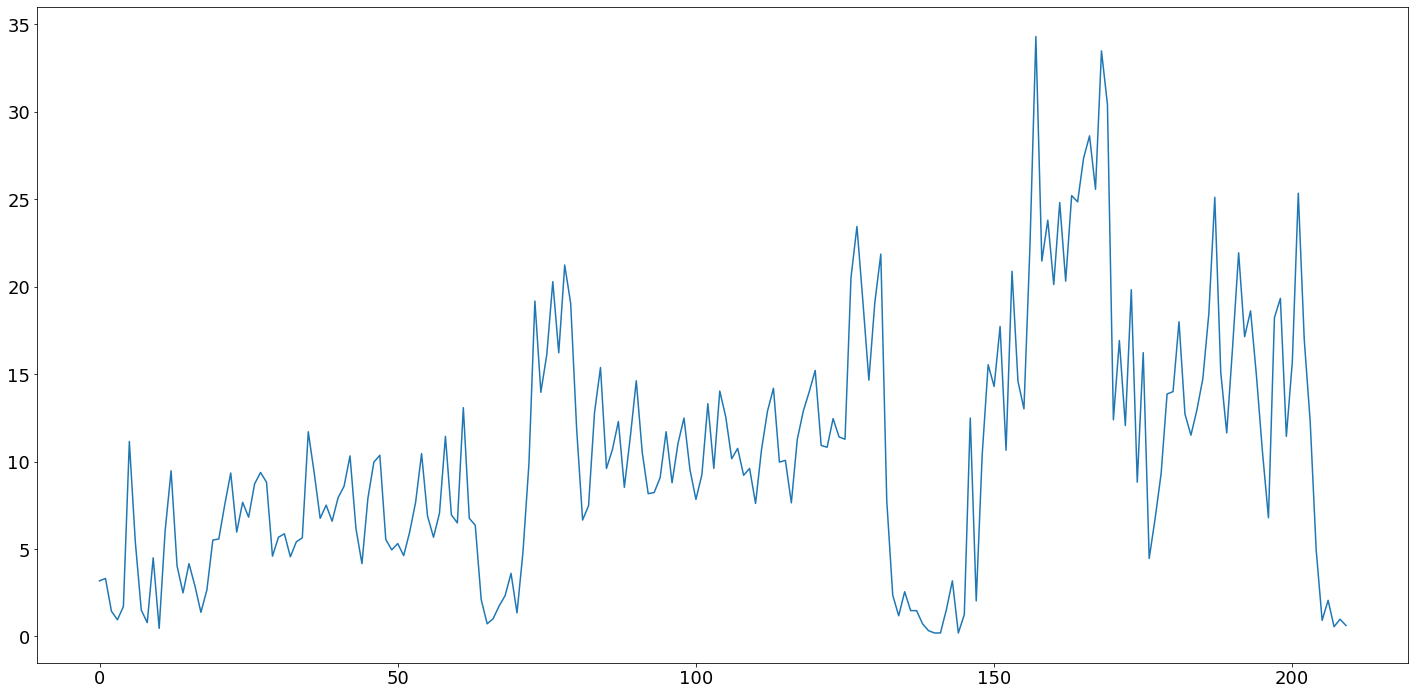

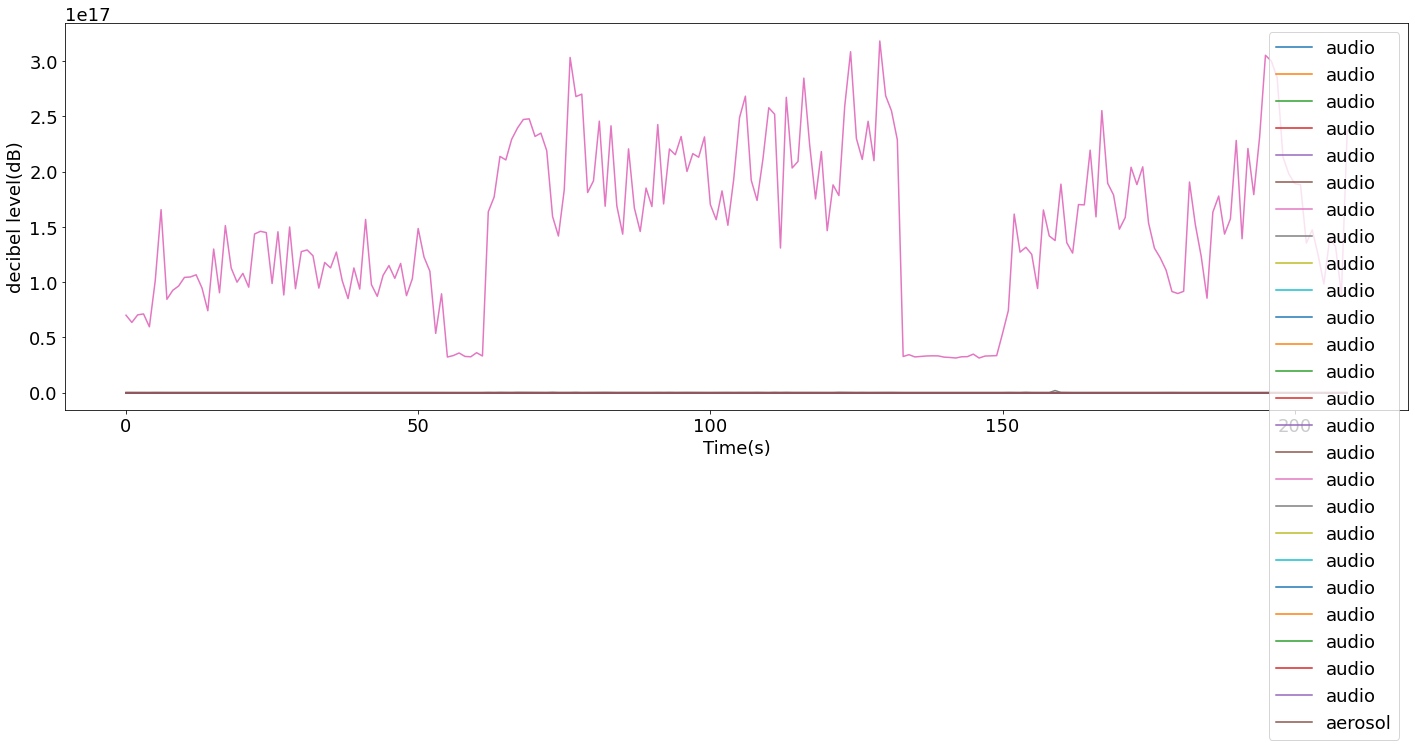

In [12]:
##get data from other file

var = pd.read_csv('exp_0415/mask_test_counting.csv')
df5 = var[85:]
# df4 = df4.drop('Sample #', 1)
# df4 = df4.drop('Sample Length', 1)
# df4 = df4.drop('Averaging Interval (s)', 1)
# df4 = df4.drop('Title', 1)
# df5 = df4[:-12]
df5 = df5.drop(df.index[(df['Start Time'] < "13:52")])
# plt.plot(df5['Conc Mean'])
temp = df5['Conc Mean'].tolist()[125:335]
plt.plot(temp)

print (len(temp))

samprate, wavdata = read('exp_0415/4-15-butanol_exp.wav')

dbs3 = []
WIDTH = 2

chunks = np.array_split(wavdata, 1544/6)
for chunk in chunks:
    print(chunk.shape)
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs3.append(a)
# print(dbs)
dbs3 = dbs3[:210]

x = range(0,11600)
plt.figure(figsize=(20,10))
print(len(dbs3))

plt.plot(dbs3, label="audio")
plt.plot(temp, label="aerosol")
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_activities_415.png")


In [13]:
print(len(dbs3), len(temp))
print (len(dbs2[1:66]), len(df['Conc Mean'].tolist()[:65]))
print (len(dbs1[:-6]), len(df2['Conc Mean'].tolist()))
db = dbs2[1:66]+ dbs1[:-6] + dbs3[:145]
print(len(db))

df_temp = df['Conc Mean'].tolist()[:65] + df2['Conc Mean'].tolist() + temp[:145]

print(len(df_temp))

210 210
65 65
110 110
320
320


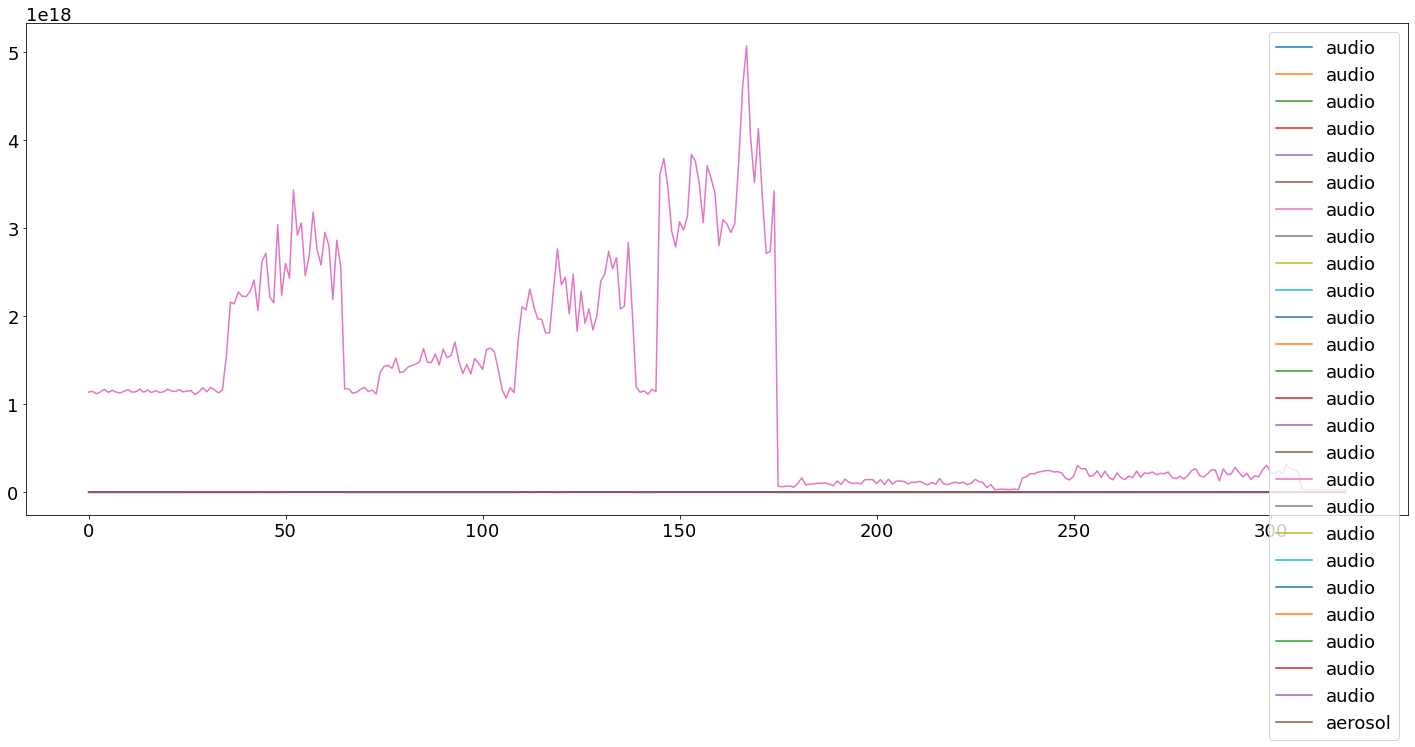

In [14]:
plt.plot(db, label="audio")
plt.plot(df_temp, label="aerosol")
plt.legend()



In [15]:
len(db[200])

25

Train Mean Squared Error: 1.1079260379400067
Regression score:  0.8690833582162367
Mean Absolute Error: 2.1590090235844874
Mean Squared Error: 10.23297369992445
Root Mean Squared Error: 3.198901952221176


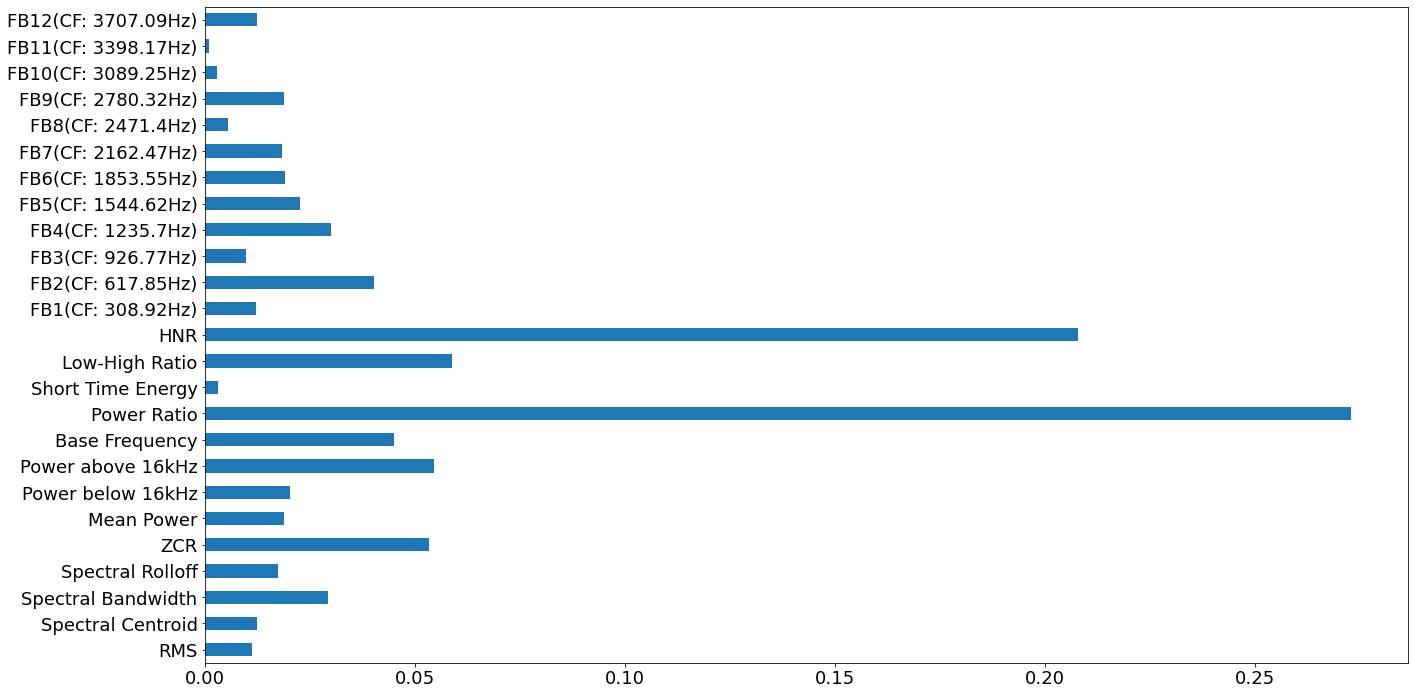

In [20]:
X = np.array(db , dtype=object)
y = np.array(df_temp)

from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# reg.fit(X_train, y_train)
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



import pandas as pd
columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 16kHz", "Power above 16kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR" ]


fb_cf26 = [148.74145111,  297.48290221,  446.22435332,  594.96580443,
         743.70725553,  892.44870664, 1041.19015774, 1189.93160885,
        1338.67305996, 1487.41451106, 1636.15596217, 1784.89741328,
        1933.63886438, 2082.38031549, 2231.1217666 , 2379.8632177 ,
        2528.60466881, 2677.34611991, 2826.08757102, 2974.82902213,
        3123.57047323, 3272.31192434, 3421.05337545, 3569.79482655,
        3718.53627766, 3867.27772877]

fb_cf12 = [ 308.9245523 ,  617.8491046 ,  926.77365689, 1235.69820919,
        1544.62276149, 1853.54731379, 2162.47186608, 2471.39641838,
        2780.32097068, 3089.24552298, 3398.17007528, 3707.09462757]

for i in range(0,12):
    val = round(fb_cf12[i],2)
    columns.append("FB"+str(i+1)+"(CF: "+str(val)+"Hz)")

fb_cf6 = [ 573.7170257 , 1147.43405139, 1721.15107709, 2294.86810278,
        2868.58512848, 3442.30215418]

# for i in range(0,6):
#     val = round(fb_cf6[i],2)
#     columns.append("FB"+str(i+1)+"(CF: "+str(val)+"Hz)")

feat_importances = pd.Series(reg.feature_importances_, index=columns)
feat_importances.plot(kind='barh')
plt.show()

In [21]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))



print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Train Mean Squared Error: 12.457830605870846
Regression score:  0.4566480739733487
Mean Absolute Error: 2.4240935286190144
Mean Squared Error: 11.032452011199402
Root Mean Squared Error: 3.3215135121205517


In [22]:
from sklearn import svm

regr = svm.SVR(kernel='rbf', C=1, epsilon=0.1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test.shape

Train Mean Squared Error: 17.737812229866254
Regression score:  0.22445378695001683
Mean Absolute Error: 3.075292625873982
Mean Squared Error: 15.92185765056919
Root Mean Squared Error: 3.990220250884554


(64, 25)

In [23]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test.shape

Train Mean Squared Error: 4.09268164233624
Regression score:  0.7646702152226602
Mean Absolute Error: 2.126533892016079
Mean Squared Error: 9.989829549762106
Root Mean Squared Error: 3.1606691617064424


(64, 25)

Train Mean Squared Error: 9.027796614315168e-36
Regression score:  0.8228309947322344
Mean Absolute Error: 3.09642078125
Mean Squared Error: 19.84565409068872
Root Mean Squared Error: 4.454846135467387


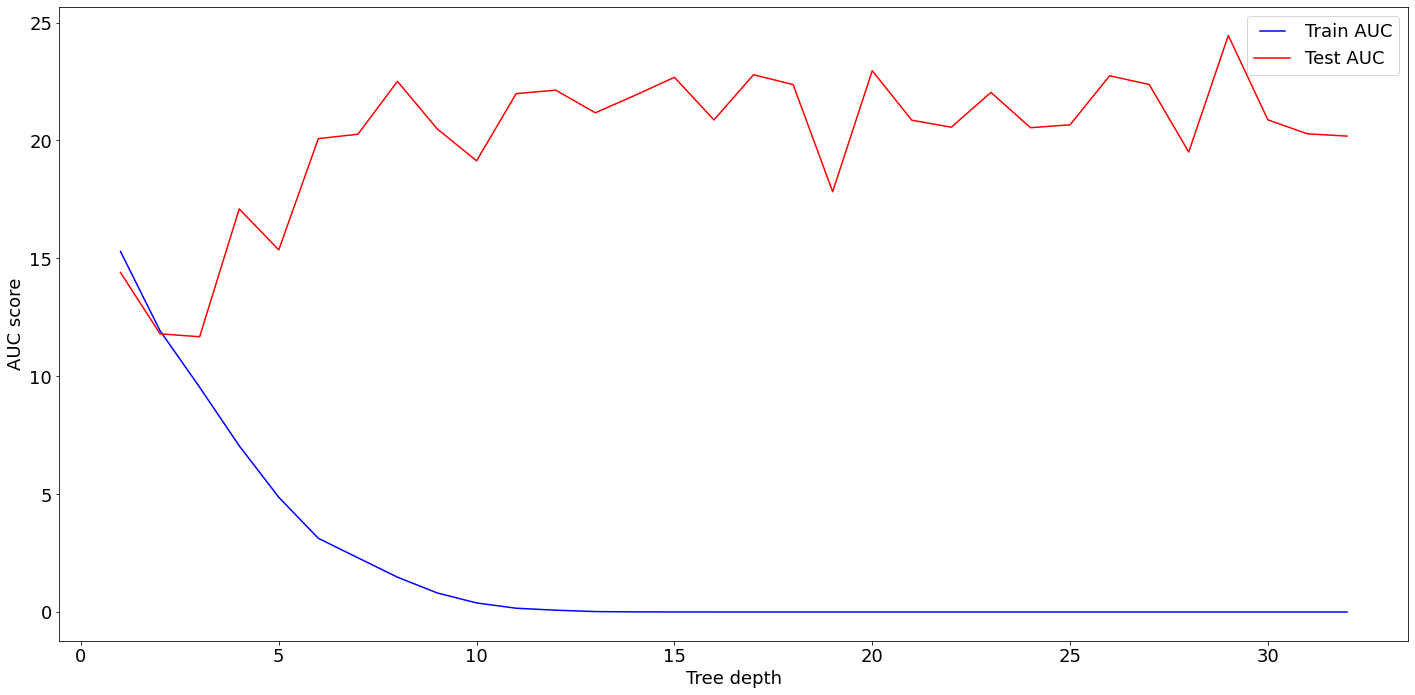

In [24]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))




print ("Regression score: ", clf.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


x_train = X_train
x_test = X_test
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = tree.DecisionTreeRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   train_results.append(metrics.mean_squared_error(train_pred, y_train))
   y_pred = dt.predict(x_test)
   test_results.append(metrics.mean_squared_error(y_pred, y_test))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()



In [25]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=1, alpha=0.5, link='log')

reg.fit(X_train, y_train)


y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X.shape

Train Mean Squared Error: 22.42885323971315
Regression score:  -0.00020211752549625928
Mean Absolute Error: 3.8005483447265633
Mean Squared Error: 22.324746931814985
Root Mean Squared Error: 4.724907081818116


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)


(320, 25)

In [26]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)
print(model.feature_importances_)
y_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))

from sklearn import metrics
print ("Regression score: ", model.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


[0.04498458 0.03756471 0.04112517 0.03302079 0.04223514 0.04578396
 0.05934631 0.0264863  0.03092412 0.1358086  0.01923345 0.05039167
 0.20834777 0.01559558 0.01829647 0.0167294  0.02052439 0.03242955
 0.02699217 0.01466639 0.01578181 0.01710206 0.01582791 0.01476604
 0.01603567]
Train Mean Squared Error: 9.497702991912311e-29
Regression score:  0.912879284546257
Mean Absolute Error: 2.0612690625000005
Mean Squared Error: 9.758860362822583
Root Mean Squared Error: 3.1239174705524126


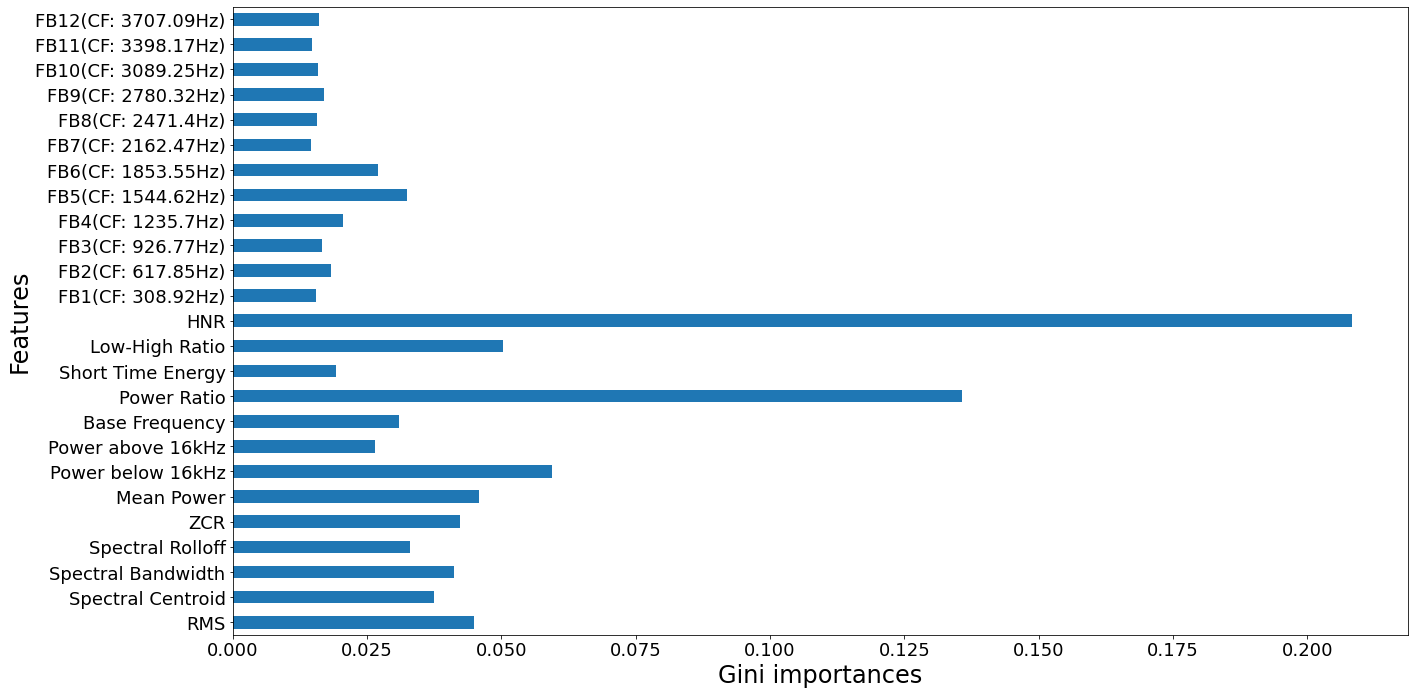

In [27]:
import pandas as pd
feat_importances = pd.Series(model.feature_importances_, index=columns)
feat_importances.plot(kind='barh', label=True)
plt.xlabel('Gini importances',fontsize=24)
plt.ylabel('Features', fontsize=24)
plt.show()

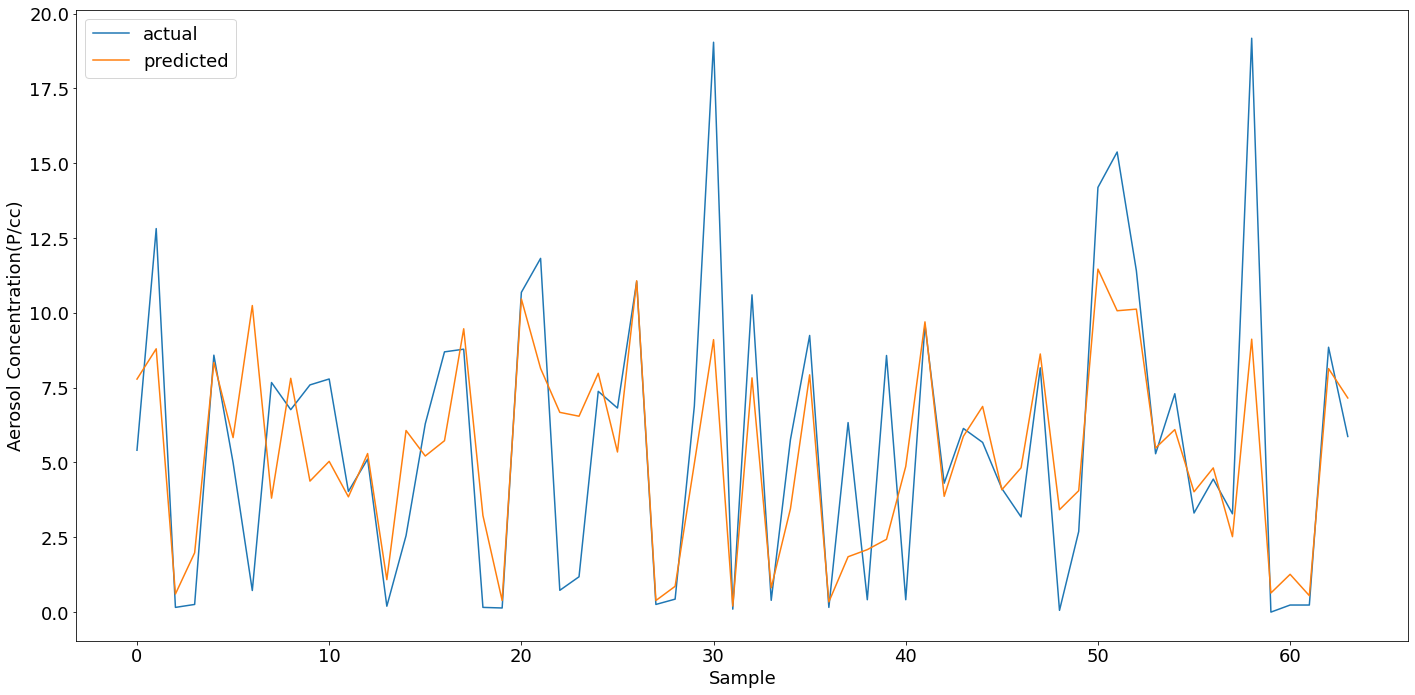

In [28]:
plt.plot(y_test, label="actual")
plt.plot(y_pred, label="predicted")
plt.ylabel("Aerosol Concentration(P/cc)")
plt.xlabel("Sample")
plt.legend()
plt.savefig("aerosol_predictions_GB.png")

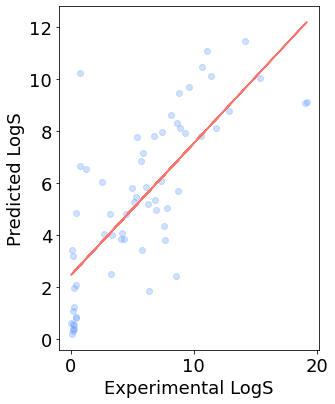

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,11))

plt.subplot(2, 1, 2)
plt.scatter(x=y_test, y=y_pred, c="#619CFF", alpha=0.3)

z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

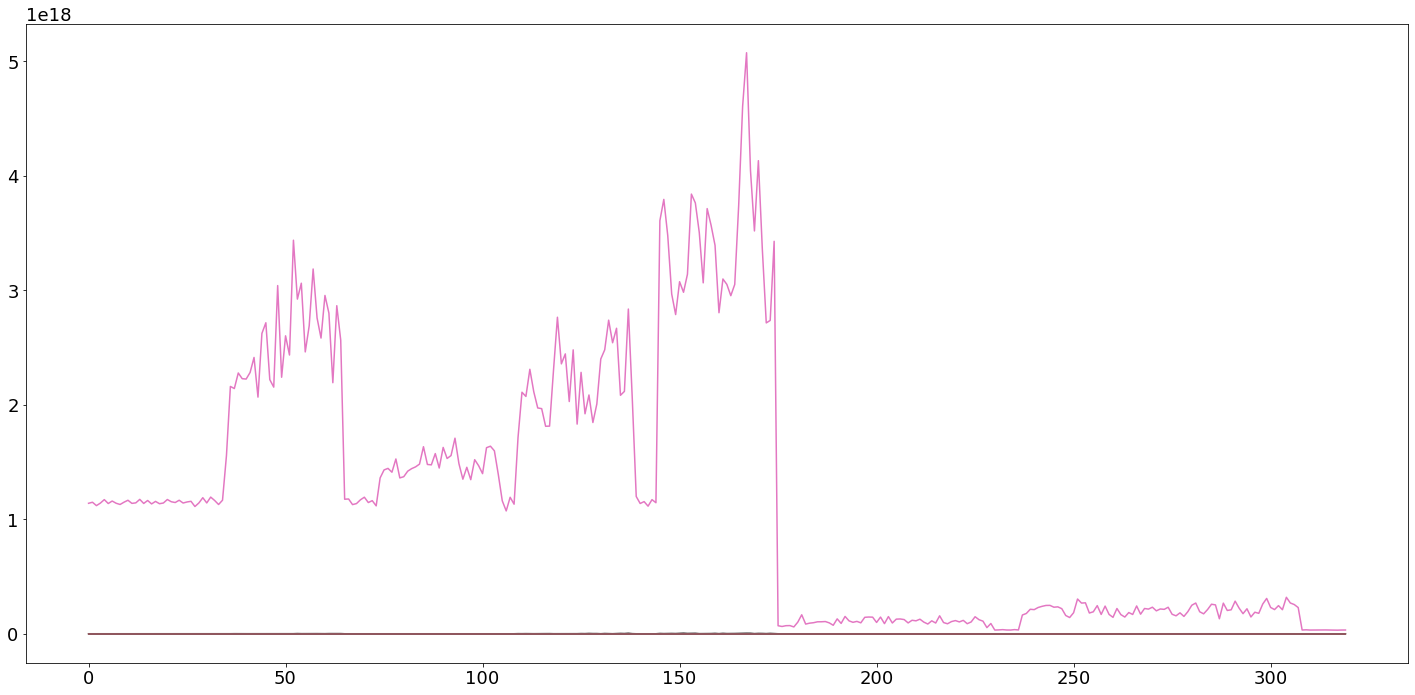

In [30]:
plt.plot(X)
plt.plot(y)

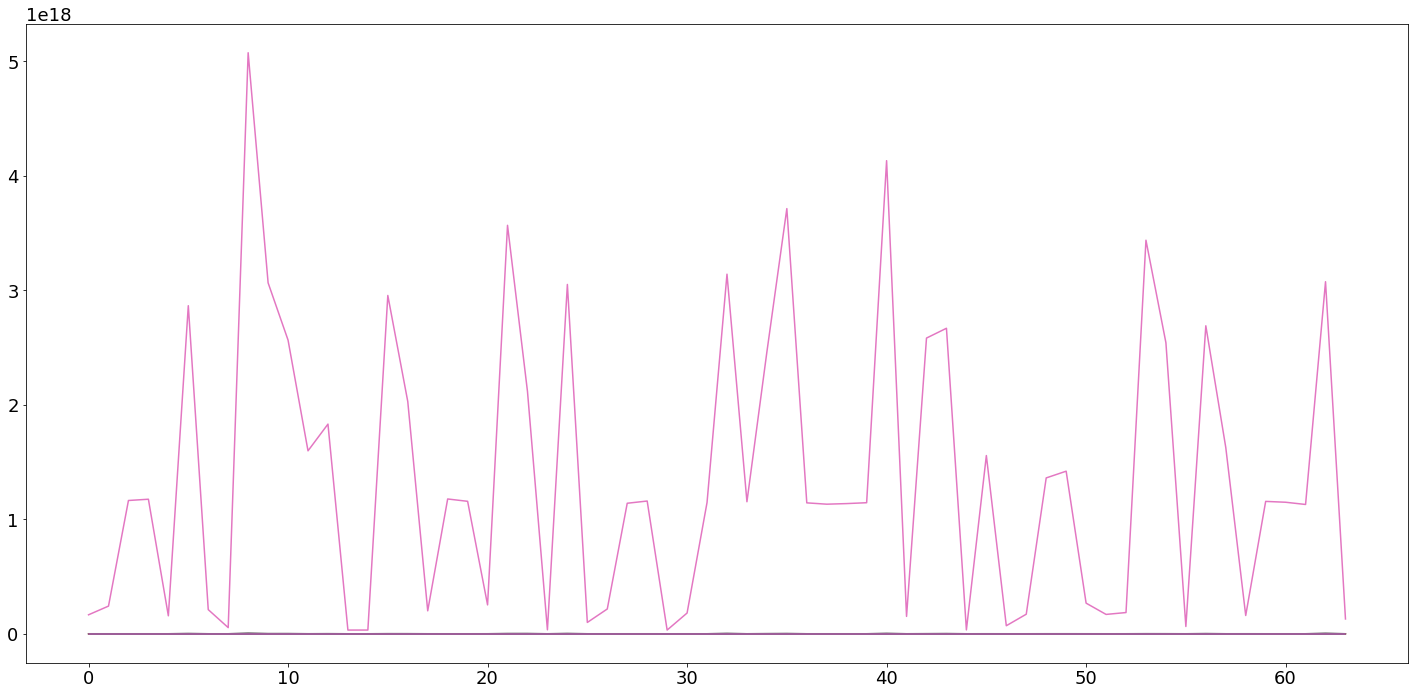

In [31]:
plt.plot(X_test)

REMOVING CORRELATED FEATURES

In [122]:
import numpy as np

df = pd.DataFrame(X, columns = columns)
df = df.astype(float)
# Create correlation matrix
corr_matrix = df.corr().abs()


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
# newdf = df.drop(to_drop, axis=1, inplace=True)

In [123]:
corr_matrix = df.corr().abs()
high_corr_var=np.where(corr_matrix>0.85)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('RMS', 'Mean Power'),
 ('RMS', 'Power below 16kHz'),
 ('Spectral Centroid', 'Spectral Rolloff'),
 ('Spectral Rolloff', 'ZCR'),
 ('ZCR', 'Mean Power'),
 ('Mean Power', 'Power below 16kHz'),
 ('FB2(CF: 617.85Hz)', 'FB3(CF: 926.77Hz)'),
 ('FB2(CF: 617.85Hz)', 'FB5(CF: 1544.62Hz)'),
 ('FB3(CF: 926.77Hz)', 'FB4(CF: 1235.7Hz)'),
 ('FB3(CF: 926.77Hz)', 'FB5(CF: 1544.62Hz)'),
 ('FB4(CF: 1235.7Hz)', 'FB5(CF: 1544.62Hz)'),
 ('FB5(CF: 1544.62Hz)', 'FB6(CF: 1853.55Hz)'),
 ('FB5(CF: 1544.62Hz)', 'FB7(CF: 2162.47Hz)'),
 ('FB6(CF: 1853.55Hz)', 'FB7(CF: 2162.47Hz)'),
 ('FB7(CF: 2162.47Hz)', 'FB8(CF: 2471.4Hz)'),
 ('FB8(CF: 2471.4Hz)', 'FB9(CF: 2780.32Hz)'),
 ('FB8(CF: 2471.4Hz)', 'FB10(CF: 3089.25Hz)'),
 ('FB8(CF: 2471.4Hz)', 'FB11(CF: 3398.17Hz)'),
 ('FB9(CF: 2780.32Hz)', 'FB10(CF: 3089.25Hz)'),
 ('FB9(CF: 2780.32Hz)', 'FB11(CF: 3398.17Hz)'),
 ('FB10(CF: 3089.25Hz)', 'FB11(CF: 3398.17Hz)'),
 ('FB10(CF: 3089.25Hz)', 'FB12(CF: 3707.09Hz)'),
 ('FB11(CF: 3398.17Hz)', 'FB12(CF: 3707.09Hz)')]

In [124]:
to_drop.remove('ZCR')

<Figure size 1368x1080 with 0 Axes>

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


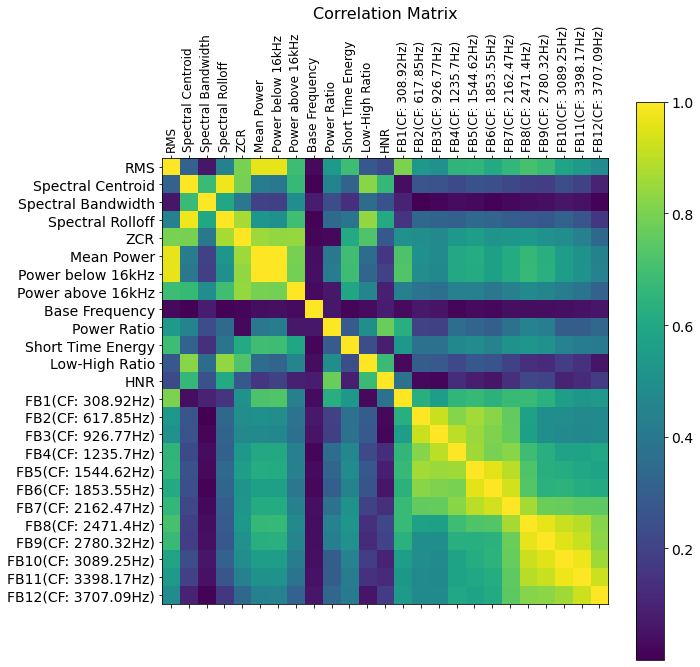

In [125]:
dff = plt.figure(figsize=(19, 15))
plt.matshow(df.corr().abs())
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [126]:
newdf = df.drop(to_drop, axis=1, inplace=True)

In [127]:
newdf

In [128]:
df

,RMS,Spectral Centroid,Spectral Bandwidth,ZCR,Power above 16kHz,Base Frequency,Power Ratio,Short Time Energy,Low-High Ratio,HNR,FB1(CF: 308.92Hz),FB2(CF: 617.85Hz)
0,3121.204244,461.174037,1018.677800,4998.0,4.964316e+13,119.991479,0.394140,5.629518e+06,115.629131,1.664749,14.790149,14.044210
1,3134.713682,453.150510,1004.705736,5314.0,4.686085e+13,119.991479,0.351649,7.261170e+06,118.429751,1.497360,15.126461,13.628799
2,3095.452847,475.083973,1049.677509,5196.0,7.308088e+13,119.991479,0.352903,9.719066e+06,118.235973,1.590013,13.909249,13.260772
3,3127.765924,456.274413,1007.309629,5087.0,4.693908e+13,119.991479,0.384451,5.907956e+06,114.374329,1.707672,13.855212,13.587570
4,3166.951577,450.831908,1007.254880,5124.0,4.927943e+13,119.991479,0.313792,4.818282e+06,121.383975,1.669985,14.508313,13.096039
...,...,...,...,...,...,...,...,...,...,...,...,...
315,868.542370,514.420570,1125.973801,3865.0,3.122898e+12,120.040791,0.095958,8.858400e+05,90.073727,0.770600,11.103783,11.918865
316,862.841707,515.485427,1129.101096,3902.0,2.933994e+12,120.040791,0.085585,1.066165e+06,91.514202,1.105180,11.604681,12.111742
317,857.607864,506.004539,1109.218129,3666.0,2.678095e+12,120.040791,0.085461,4.651960e+05,92.890168,0.340816,11.997987,11.202794
318,871.958376,530.375774,1166.137671,3901.0,3.554600e+12,120.040791,0.081450,9.031706e+05,92.683092,0.524454,12.372190,11.808461


In [135]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
X_new = np.asarray(df)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)


model = ExtraTreesRegressor(n_estimators=150)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

model.fit(X_train, y_train)
# print(model.feature_importances_)
y_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))

from sklearn import metrics
print ("Regression score: ", model.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))




MAE: -10.953 (3.238)
Train Mean Squared Error: 2.3102680576529942e-28
Regression score:  0.921051770902358
Mean Absolute Error: 1.9039023413541667
Mean Squared Error: 8.843416168512586
Root Mean Squared Error: 2.973788184876755


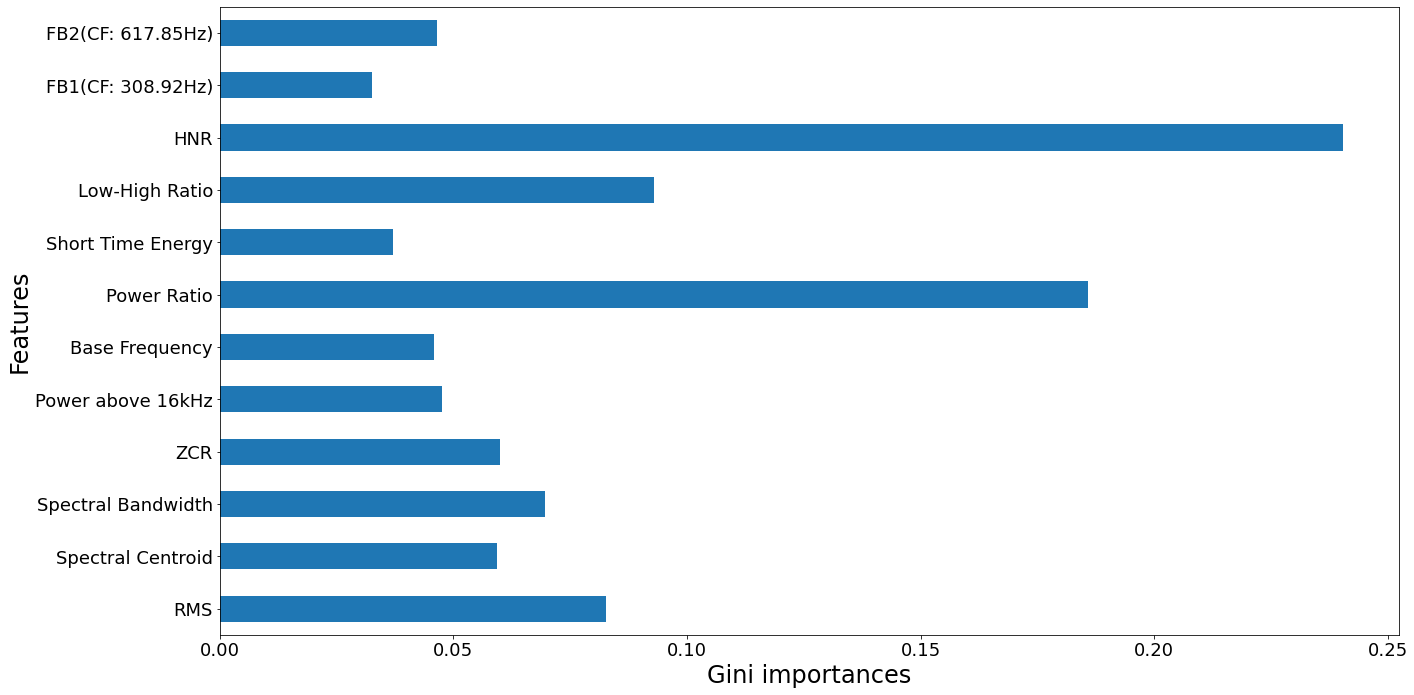

In [136]:
feat_importances = pd.Series(model.feature_importances_, index=df.columns)
feat_importances.plot(kind='barh', label=True)
plt.xlabel('Gini importances',fontsize=24)
plt.ylabel('Features', fontsize=24)
plt.show()

In [121]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

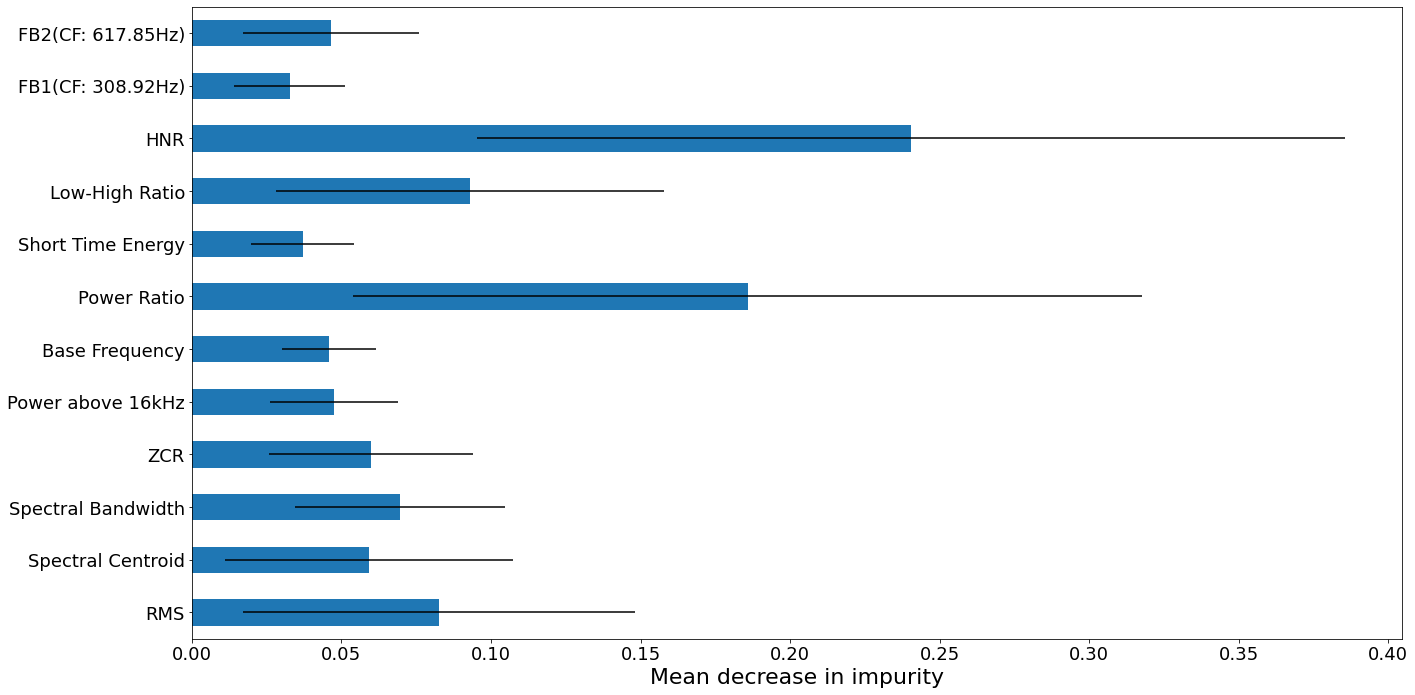

In [137]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df.columns)
indices = np.argsort(importances)
# plt.figure()
# plt.barh(range(X_new.shape[1]), importances[indices], xerr=std[indices], align="center")
# # ax.set_title("Feature importances using MDI")
# plt.yticks(range(X_new.shape[1]), indices)
# plt.ylim([-1, X_new.shape[1]])
# plt.show()

forest_importances = pd.Series(importances, index=df.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity", fontsize=22)
fig.tight_layout()

In [ ]:
samprate

In [ ]:
###Filter banks center frequency: 
#         148.74145111,  297.48290221,  446.22435332,  594.96580443,
#          743.70725553,  892.44870664, 1041.19015774, 1189.93160885,
#         1338.67305996, 1487.41451106, 1636.15596217, 1784.89741328,
#         1933.63886438, 2082.38031549, 2231.1217666 , 2379.8632177 ,
#         2528.60466881, 2677.34611991, 2826.08757102, 2974.82902213,
#         3123.57047323, 3272.31192434, 3421.05337545, 3569.79482655,
#         3718.53627766, 3867.27772877

In [138]:
regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Train Mean Squared Error: 4.353665445618215
Regression score:  0.756942452197384
Mean Absolute Error: 2.0746425068998655
Mean Squared Error: 9.811522676436987
Root Mean Squared Error: 3.132335019827379


In [139]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Train Mean Squared Error: 1.2544769250625332
Regression score:  0.8719769418103
Mean Absolute Error: 2.0102349676045312
Mean Squared Error: 9.322644275108047
Root Mean Squared Error: 3.0533005543359217


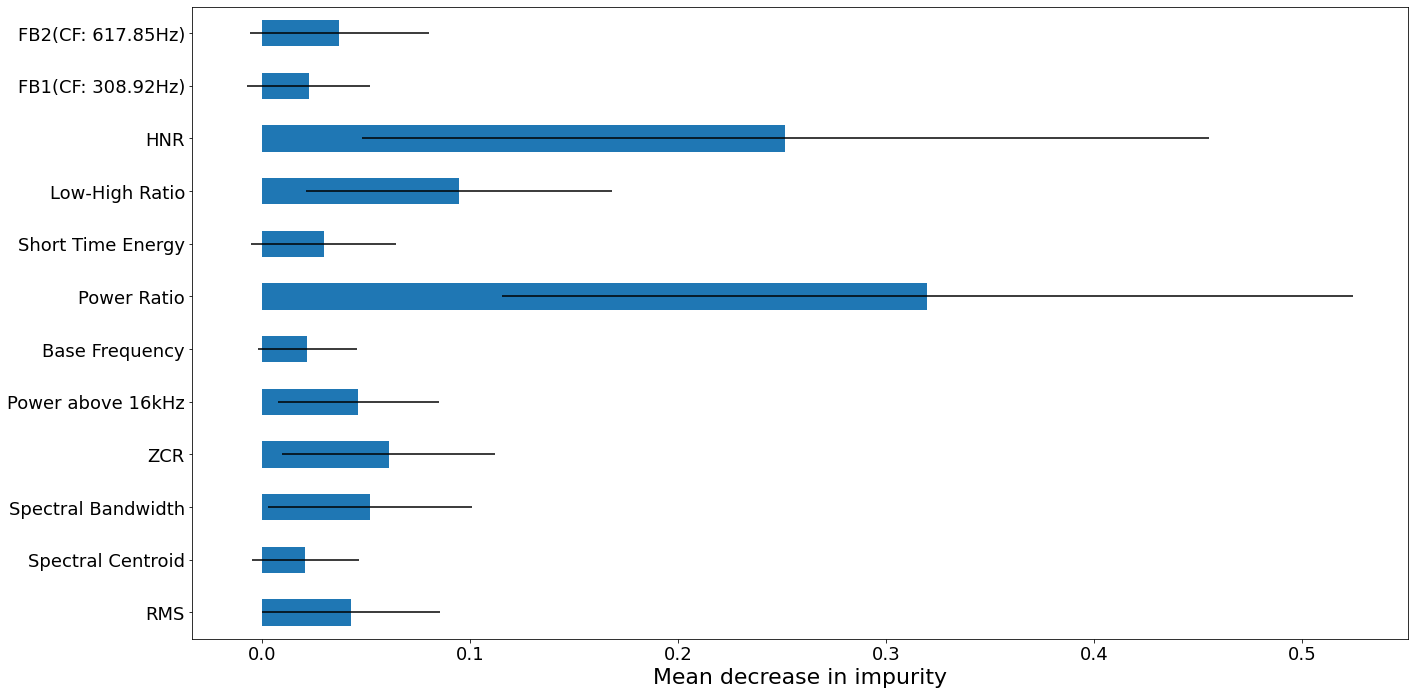

In [141]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df.columns)
indices = np.argsort(importances)
# plt.figure()
# plt.barh(range(X_new.shape[1]), importances[indices], xerr=std[indices], align="center")
# # ax.set_title("Feature importances using MDI")
# plt.yticks(range(X_new.shape[1]), indices)
# plt.ylim([-1, X_new.shape[1]])
# plt.show()

forest_importances = pd.Series(importances, index=df.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity", fontsize=22)
fig.tight_layout()

In [17]:
freq = melfrequencies_mel_filterbank(num_bands=12, freq_min=0, freq_max=24000, num_fft_bands=513)

NameError: name 'melfrequencies_mel_filterbank' is not defined

In [18]:
for i in range(freq[0].shape[0]-1):
    print(freq[0][i+1]- freq[0][i])

NameError: name 'freq' is not defined

In [19]:
freq

NameError: name 'freq' is not defined